In [1]:
import math
from math import log
import os
import pandas as pd
import numpy as np
from numpy.linalg import norm

import matplotlib
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf

from clearn.utils.data_loader import load_images, TrainValDataIterator
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import Experiment, initialize_model_train_and_get_features, get_model,  MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.analysis.encode_decode import decode
from clearn.analysis.cluster_utils import cluster_and_decode_latent_vectors, display_cluster_center_images,get_cluster
from clearn.analysis.cluster_utils import get_cluster_groups, get_samples_for_cluster
from clearn.analysis import ManualAnnotation, Cluster, ClusterGroup
from clearn.utils.data_loader import TrainValDataIterator
from clearn.dao.dao_factory import get_dao
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label
from clearn.analysis.cluster_utils import assign_manual_label_and_confidence, plot_distance_distribution
from PIL import Image


%matplotlib inline


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"
cluster_column_name_3 ="cluster_level_3"

In [3]:
def distance(row,cluster_center,z_col_names):
    return norm(row[z_col_names].values - cluster_center)
from scipy.spatial.distance import mahalanobis
def distance(row, inv_cov, cluster_center,z_col_names):
    return mahalanobis(row[z_col_names].values, cluster_center, inv_cov)


import scipy as sp

def compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers):

    for i in range(num_clusters):
        df["distance_{}".format(i)] = 100000
    for cluster_num in range(num_clusters):
        indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
        lv= df[z_col_names].values[indices, :]
        print(lv.shape)
        cov = np.cov(lv.T)
        inv_cov = sp.linalg.inv(cov)
        df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                       inv_cov,
                                                                                                       cluster_centers[cluster_num],
                                                                                                       z_col_names),
                                                                                     axis=1)


In [4]:
def compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers):
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            lv= df[z_col_names].values[indices, :]
            cov = np.cov(lv.T)
            inv_cov = sp.linalg.inv(cov)

            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               inv_cov,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


# Set experiment parameters

In [5]:
z_dim = 10
run_id = 45
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

In [6]:
experiment_name = "semi_sup_gaussian_mah_k5"
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

exp_config = ExperimentConfig(root_path=ROOT_PATH,
                               num_decoder_layer=4,
                               z_dim=z_dim,
                               num_units=num_units,
                               num_cluster_config=num_cluster_config,
                               confidence_decay_factor=5,
                               beta=5,
                               supervise_weight=150,
                               dataset_name="mnist",
                               split_name="Split_1",
                               model_name="VAE",
                               batch_size=64,
                               eval_interval_in_epochs=1,
                               name=experiment_name,
                               num_val_samples=128,
                               total_training_samples=60000,
                               manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                               reconstruction_weight=1,
                               activation_hidden_layer="RELU",
                               activation_output_layer="SIGMOID")
exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name


In [7]:
# K = exp_config.confidence_decay_factor
# def convert_distance_to_confidence(dist):
#     return np.exp(-1 / K * dist)

# def get_percentage_correct(confidence):
#     df1 = df[df["manual_annotation_confidence"] > confidence]
#     if df1.shape[0] != 0:
#         df2 = df1[df1["manual_annotation"] == df1["label"]]        
#         return df2.shape[0] / df1.shape[0]
#     else:
#         return 1
# def get_distance(confidence):
#     return -K * log(confidence)
# def get_confidence(distance):
#     return np.exp(-distance/K)

K = exp_config.confidence_decay_factor
def convert_distance_to_confidence(dist):
    return np.exp(-1 / K * dist * dist)

def get_percentage_correct(confidence):
    df1 = df[df["manual_annotation_confidence"] > confidence]
    if df1.shape[0] != 0:
        df2 = df1[df1["manual_annotation"] == df1["label"]]        
        return df2.shape[0] / df1.shape[0]
    else:
        return 1
def get_distance(confidence):
    return math.sqrt(-K * log(confidence))

def get_confidence(distance):
    return np.exp(-distance * distance/K)


In [8]:
dao = get_dao(exp_config.dataset_name, exp_config.split_name, exp_config.num_val_samples)

# Train model

In [9]:
num_epochs = 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
train_val_data_iterator, exp_config, model = initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
                                       )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k5'}
Warning /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k5/Exp_32_128_64_10_ELBOW_45/analysis/manual_annotation_epoch_-1.0.csv path does not exist. Creating random prior 

Epoch: 0/46, Nll_loss : 228.26251220703125 KLD:1.2242369651794434  Supervised loss:0.0
Epoch: 0/47, Nll_loss : 204.4985809326172 KLD:1.4279301166534424  Supervised loss:0.0
Epoch: 0/48, Nll_loss : 204.49427795410156 KLD:1.2457059621810913  Supervised loss:0.0
Epoch: 0/49, Nll_loss : 209.6018524169922 KLD:1.0778782367706299  Supervised loss:0.0
Epoch: 0/50, Nll_loss : 211.17564392089844 KLD:1.0869362354278564  Supervised loss:0.0
Epoch: 0/51, Nll_loss : 208.56173706054688 KLD:1.0476715564727783  Supervised loss:0.0
Epoch: 0/52, Nll_loss : 204.43362426757812 KLD:1.078273057937622  Supervised loss:0.0
Epoch: 0/53, Nll_loss : 207.20932006835938 KLD:1.1045595407485962  Supervised loss:0.0
Epoch: 0/54, Nll_loss : 214.86419677734375 KLD:1.2250726222991943  Supervised loss:0.0
Epoch: 0/55, Nll_loss : 218.76626586914062 KLD:1.1616277694702148  Supervised loss:0.0
Epoch: 0/56, Nll_loss : 212.53271484375 KLD:1.1468684673309326  Supervised loss:0.0
Epoch: 0/57, Nll_loss : 220.55154418945312 KLD:1.

Epoch: 0/141, Nll_loss : 188.74932861328125 KLD:2.0496933460235596  Supervised loss:0.0
Epoch: 0/142, Nll_loss : 194.71290588378906 KLD:2.0222229957580566  Supervised loss:0.0
Epoch: 0/143, Nll_loss : 187.85391235351562 KLD:2.145353317260742  Supervised loss:0.0
Epoch: 0/144, Nll_loss : 187.91012573242188 KLD:2.0936338901519775  Supervised loss:0.0
Epoch: 0/145, Nll_loss : 181.19879150390625 KLD:2.1766486167907715  Supervised loss:0.0
Epoch: 0/146, Nll_loss : 185.70175170898438 KLD:2.361542224884033  Supervised loss:0.0
Epoch: 0/147, Nll_loss : 185.04017639160156 KLD:2.6171021461486816  Supervised loss:0.0
Epoch: 0/148, Nll_loss : 188.85549926757812 KLD:2.6503093242645264  Supervised loss:0.0
Epoch: 0/149, Nll_loss : 176.60333251953125 KLD:2.521228551864624  Supervised loss:0.0
Epoch: 0/150, Nll_loss : 198.43072509765625 KLD:2.267512798309326  Supervised loss:0.0
Epoch: 0/151, Nll_loss : 182.73489379882812 KLD:2.332265853881836  Supervised loss:0.0
Epoch: 0/152, Nll_loss : 184.91381835

Epoch: 0/237, Nll_loss : 165.8397979736328 KLD:4.014075756072998  Supervised loss:0.0
Epoch: 0/238, Nll_loss : 154.83523559570312 KLD:4.258303642272949  Supervised loss:0.0
Epoch: 0/239, Nll_loss : 159.70477294921875 KLD:4.147756576538086  Supervised loss:0.0
Epoch: 0/240, Nll_loss : 154.66555786132812 KLD:4.248524188995361  Supervised loss:0.0
Epoch: 0/241, Nll_loss : 160.039794921875 KLD:4.178991317749023  Supervised loss:0.0
Epoch: 0/242, Nll_loss : 160.06854248046875 KLD:3.974947929382324  Supervised loss:0.0
Epoch: 0/243, Nll_loss : 158.68792724609375 KLD:3.662471294403076  Supervised loss:0.0
Epoch: 0/244, Nll_loss : 167.286376953125 KLD:3.754502773284912  Supervised loss:0.0
Epoch: 0/245, Nll_loss : 167.5087432861328 KLD:3.808016300201416  Supervised loss:0.0
Epoch: 0/246, Nll_loss : 166.55471801757812 KLD:3.8903098106384277  Supervised loss:0.0
Epoch: 0/247, Nll_loss : 163.4417266845703 KLD:3.822871208190918  Supervised loss:0.0
Epoch: 0/248, Nll_loss : 165.24539184570312 KLD:3

Epoch: 0/332, Nll_loss : 146.9123077392578 KLD:4.369942665100098  Supervised loss:0.0
Epoch: 0/333, Nll_loss : 159.80226135253906 KLD:4.817781925201416  Supervised loss:0.0
Epoch: 0/334, Nll_loss : 155.58834838867188 KLD:4.791264057159424  Supervised loss:0.0
Epoch: 0/335, Nll_loss : 150.9774932861328 KLD:4.725498199462891  Supervised loss:0.0
Epoch: 0/336, Nll_loss : 155.52838134765625 KLD:4.971939563751221  Supervised loss:0.0
Epoch: 0/337, Nll_loss : 151.70904541015625 KLD:4.837492942810059  Supervised loss:0.0
Epoch: 0/338, Nll_loss : 148.73770141601562 KLD:4.57547664642334  Supervised loss:0.0
Epoch: 0/339, Nll_loss : 168.3104705810547 KLD:4.264692783355713  Supervised loss:0.0
Epoch: 0/340, Nll_loss : 157.35763549804688 KLD:4.265233993530273  Supervised loss:0.0
Epoch: 0/341, Nll_loss : 149.4349365234375 KLD:4.402414321899414  Supervised loss:0.0
Epoch: 0/342, Nll_loss : 151.74420166015625 KLD:4.203121185302734  Supervised loss:0.0
Epoch: 0/343, Nll_loss : 152.3589630126953 KLD:4

Epoch: 0/428, Nll_loss : 144.9665069580078 KLD:4.772097587585449  Supervised loss:0.0
Epoch: 0/429, Nll_loss : 157.24710083007812 KLD:4.707265853881836  Supervised loss:0.0
Epoch: 0/430, Nll_loss : 151.14694213867188 KLD:4.891505241394043  Supervised loss:0.0
Epoch: 0/431, Nll_loss : 142.02207946777344 KLD:4.728657245635986  Supervised loss:0.0
Epoch: 0/432, Nll_loss : 150.08969116210938 KLD:4.876608848571777  Supervised loss:0.0
Epoch: 0/433, Nll_loss : 151.15301513671875 KLD:5.174695014953613  Supervised loss:0.0
Epoch: 0/434, Nll_loss : 142.01881408691406 KLD:4.987236022949219  Supervised loss:0.0
Epoch: 0/435, Nll_loss : 143.19944763183594 KLD:4.799129486083984  Supervised loss:0.0
Epoch: 0/436, Nll_loss : 152.05148315429688 KLD:4.979537487030029  Supervised loss:0.0
Epoch: 0/437, Nll_loss : 160.33810424804688 KLD:4.728679656982422  Supervised loss:0.0
Epoch: 0/438, Nll_loss : 145.81622314453125 KLD:4.920366287231445  Supervised loss:0.0
Epoch: 0/439, Nll_loss : 141.66253662109375 

Epoch: 0/525, Nll_loss : 143.35430908203125 KLD:5.222280979156494  Supervised loss:0.0
Epoch: 0/526, Nll_loss : 138.3921356201172 KLD:5.094122886657715  Supervised loss:0.0
Epoch: 0/527, Nll_loss : 139.0335235595703 KLD:5.090903282165527  Supervised loss:0.0
Epoch: 0/528, Nll_loss : 133.1623992919922 KLD:5.044669151306152  Supervised loss:0.0
Epoch: 0/529, Nll_loss : 146.09559631347656 KLD:5.0300984382629395  Supervised loss:0.0
Epoch: 0/530, Nll_loss : 143.32032775878906 KLD:5.148538112640381  Supervised loss:0.0
Epoch: 0/531, Nll_loss : 138.04812622070312 KLD:5.085127830505371  Supervised loss:0.0
Epoch: 0/532, Nll_loss : 151.347900390625 KLD:5.179443359375  Supervised loss:0.0
Epoch: 0/533, Nll_loss : 144.74978637695312 KLD:5.264439582824707  Supervised loss:0.0
Epoch: 0/534, Nll_loss : 152.49375915527344 KLD:5.071961402893066  Supervised loss:0.0
Epoch: 0/535, Nll_loss : 141.6685028076172 KLD:4.838952541351318  Supervised loss:0.0
Epoch: 0/536, Nll_loss : 138.60635375976562 KLD:5.0

Epoch: 0/621, Nll_loss : 149.48245239257812 KLD:5.164604187011719  Supervised loss:0.0
Epoch: 0/622, Nll_loss : 136.52310180664062 KLD:5.06125545501709  Supervised loss:0.0
Epoch: 0/623, Nll_loss : 132.55227661132812 KLD:5.159971237182617  Supervised loss:0.0
Epoch: 0/624, Nll_loss : 151.00601196289062 KLD:5.012533187866211  Supervised loss:0.0
Epoch: 0/625, Nll_loss : 151.20745849609375 KLD:5.047665596008301  Supervised loss:0.0
Epoch: 0/626, Nll_loss : 146.8675994873047 KLD:5.0597429275512695  Supervised loss:0.0
Epoch: 0/627, Nll_loss : 136.62460327148438 KLD:4.950834274291992  Supervised loss:0.0
Epoch: 0/628, Nll_loss : 139.50509643554688 KLD:5.037761688232422  Supervised loss:0.0
Epoch: 0/629, Nll_loss : 146.7921142578125 KLD:4.877615928649902  Supervised loss:0.0
Epoch: 0/630, Nll_loss : 143.70257568359375 KLD:5.106025695800781  Supervised loss:0.0
Epoch: 0/631, Nll_loss : 143.5383758544922 KLD:4.841265678405762  Supervised loss:0.0
Epoch: 0/632, Nll_loss : 136.19900512695312 KL

Epoch: 0/717, Nll_loss : 145.47998046875 KLD:5.798015117645264  Supervised loss:0.0
Epoch: 0/718, Nll_loss : 135.079833984375 KLD:5.213513374328613  Supervised loss:0.0
Epoch: 0/719, Nll_loss : 145.1231689453125 KLD:5.055466651916504  Supervised loss:0.0
Epoch: 0/720, Nll_loss : 141.41146850585938 KLD:5.130512237548828  Supervised loss:0.0
Epoch: 0/721, Nll_loss : 140.22654724121094 KLD:5.244528293609619  Supervised loss:0.0
Epoch: 0/722, Nll_loss : 136.5842742919922 KLD:5.246737480163574  Supervised loss:0.0
Epoch: 0/723, Nll_loss : 137.15042114257812 KLD:5.457414627075195  Supervised loss:0.0
Epoch: 0/724, Nll_loss : 146.81680297851562 KLD:5.559778213500977  Supervised loss:0.0
Epoch: 0/725, Nll_loss : 142.44541931152344 KLD:5.4504499435424805  Supervised loss:0.0
Epoch: 0/726, Nll_loss : 137.36178588867188 KLD:5.602167129516602  Supervised loss:0.0
Epoch: 0/727, Nll_loss : 137.69020080566406 KLD:5.615494728088379  Supervised loss:0.0
Epoch: 0/728, Nll_loss : 135.00161743164062 KLD:5

Epoch: 0/813, Nll_loss : 142.4044952392578 KLD:5.09640645980835  Supervised loss:0.0
Epoch: 0/814, Nll_loss : 133.27883911132812 KLD:5.267050743103027  Supervised loss:0.0
Epoch: 0/815, Nll_loss : 146.5425567626953 KLD:5.44875955581665  Supervised loss:0.0
Epoch: 0/816, Nll_loss : 141.24488830566406 KLD:5.403143405914307  Supervised loss:0.0
Epoch: 0/817, Nll_loss : 141.92132568359375 KLD:5.417929172515869  Supervised loss:0.0
Epoch: 0/818, Nll_loss : 124.78633117675781 KLD:5.7417802810668945  Supervised loss:0.0
Epoch: 0/819, Nll_loss : 144.40322875976562 KLD:6.018989086151123  Supervised loss:0.0
Epoch: 0/820, Nll_loss : 137.4503936767578 KLD:5.9990668296813965  Supervised loss:0.0
Epoch: 0/821, Nll_loss : 152.17416381835938 KLD:5.787083625793457  Supervised loss:0.0
Epoch: 0/822, Nll_loss : 141.13218688964844 KLD:5.376629829406738  Supervised loss:0.0
Epoch: 0/823, Nll_loss : 145.28280639648438 KLD:5.368056297302246  Supervised loss:0.0
Epoch: 0/824, Nll_loss : 140.6255645751953 KLD

Epoch: 0/909, Nll_loss : 133.61636352539062 KLD:5.526952743530273  Supervised loss:0.0
Epoch: 0/910, Nll_loss : 143.15042114257812 KLD:5.815133094787598  Supervised loss:0.0
Epoch: 0/911, Nll_loss : 130.43553161621094 KLD:5.819389820098877  Supervised loss:0.0
Epoch: 0/912, Nll_loss : 138.6627960205078 KLD:5.574869632720947  Supervised loss:0.0
Epoch: 0/913, Nll_loss : 133.43063354492188 KLD:5.789428234100342  Supervised loss:0.0
Epoch: 0/914, Nll_loss : 135.760498046875 KLD:5.82192325592041  Supervised loss:0.0
Epoch: 0/915, Nll_loss : 148.6592559814453 KLD:5.399661064147949  Supervised loss:0.0
Epoch: 0/916, Nll_loss : 138.2664794921875 KLD:5.555909156799316  Supervised loss:0.0
Epoch: 0/917, Nll_loss : 129.97442626953125 KLD:5.649343490600586  Supervised loss:0.0
Epoch: 0/918, Nll_loss : 145.31405639648438 KLD:5.585277080535889  Supervised loss:0.0
Epoch: 0/919, Nll_loss : 133.35043334960938 KLD:5.726363182067871  Supervised loss:0.0
Epoch: 0/920, Nll_loss : 143.86224365234375 KLD:5

# Load the trained model

In [10]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k5/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS
Number of steps completed=936
Number of epochs completed 1.0


# Read the latent vectors for train data

In [11]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=45 z_min=-4.7493042999999995 z_max=4.2447386
Latent vectors shape (59840, 10)


# Load training images,  labels and manual annotations

In [12]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
images, labels, _ = load_images(exp_config,
                                train_val_data_iterator,
                                "train"
                               )
unique_labels = train_val_data_iterator.get_unique_labels()
num_batches = images.shape[0] / exp_config.BATCH_SIZE
epochs_completed = num_steps_completed // num_batches
print("Number of epochs completed {}".format(epochs_completed))


Number of epochs completed 1.0


# Use Elbow method to to find out number of optimum clusters k

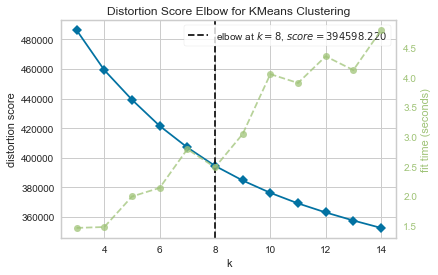

In [13]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

In [14]:
if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
    num_clusters = visualizer.elbow_value_
else:
    num_clusters = 2 * visualizer.elbow_value_
if num_clusters < 10:
    num_clusters = 10
#num_clusters = 16

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k5/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS


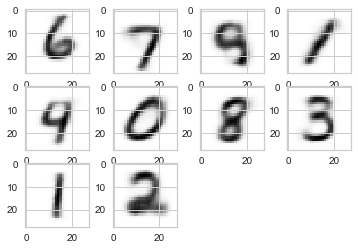

In [15]:
import json
import cv2
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
if not os.path.isfile(manual_annotation_file_json):
    #Cluster and decode the cluster center
    decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                        num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        dao
                                                                                       )
    display_cluster_center_images(decoded_images, image_filename, cluster_centers)
else:
    #TODO fix the issues in image display
#     plt.figure()
#     plt.imshow(cv2.imread(image_filename))
    with open(manual_annotation_file_json, "r") as json_file:
        manual_annotation_json = json.load(json_file)
    cluster_labels = np.asarray(manual_annotation_json["cluster_labels"])
    cluster_centers = np.asarray(manual_annotation_json["cluster_centers"])   
    img = Image.open(image_filename)
    img.show()
    

# Get the labels and confidence manualy,  -1 for unknown/invalid label

## Important:- Edit the values of `manual_annotation_json["manual_labels"]` and `manual_annotation_json["manual_confidence"]` manually looking at the cluster centers above. Also show  the images and  get  annotaions from few other samples closer to the cluster cetner

In [16]:
manual_annotation_json = None
if manual_annotation_json is None:
    #TODO get the input from console or a gui app. For now edit the values directly here
    print("Getting manual_annotation")
    manual_annotation_json = dict()
    manual_annotation_json["manual_labels"] = [6,7,-1,1,
                                               4,0,8,3,
                                               1,2
                                              ]
    manual_annotation_json["manual_confidence"] = [0.8,0.7,0,0.9,
                                                  0.6,1,0.8,0.7,
                                                  1, 0.9
                                                  ]
    
    manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
    manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
    with open(manual_annotation_file_json, "w") as json_file:
        json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [17]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

# TODO Split each of the cluster  into two/three  clusters, based on the manual label and confidence

In [18]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

In [19]:
cluster_group_dict

{'good_clusters': <clearn.analysis.ClusterGroup at 0x7fa89142dbd0>,
 'unknown_cluster': <clearn.analysis.ClusterGroup at 0x7fa8949a3c90>,
 'average_clusters': <clearn.analysis.ClusterGroup at 0x7fa89143da10>,
 None: <clearn.analysis.ClusterGroup at 0x7fa89143d590>}

In [20]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
legend_string = "Cluster Number={} Label={}"
matplotlib.rc('font', **font)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


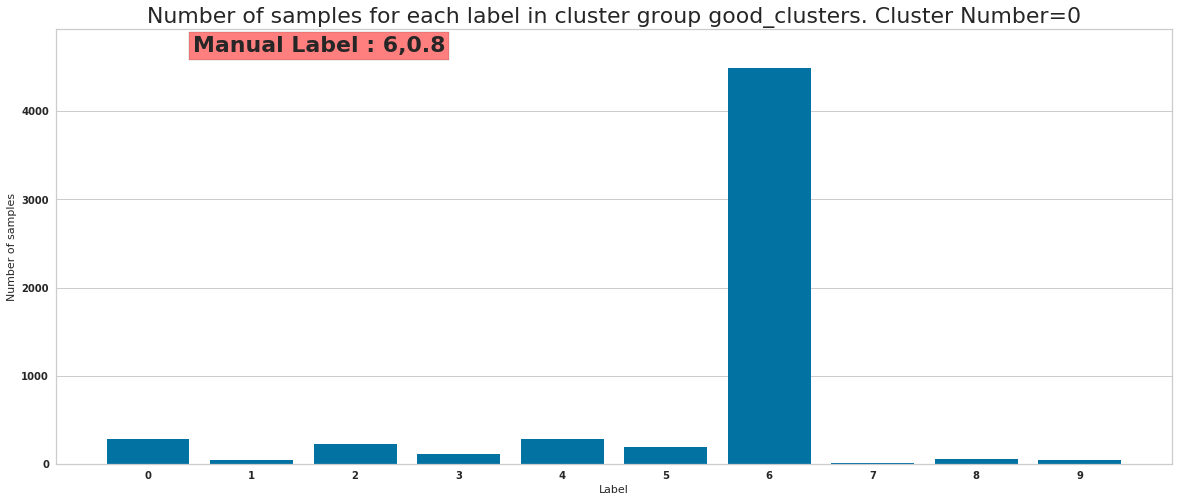

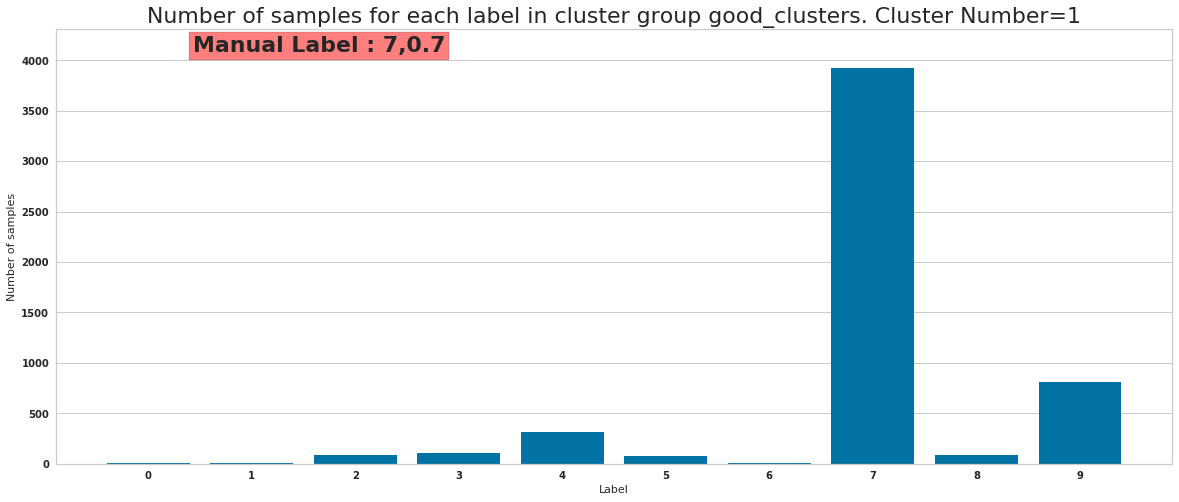

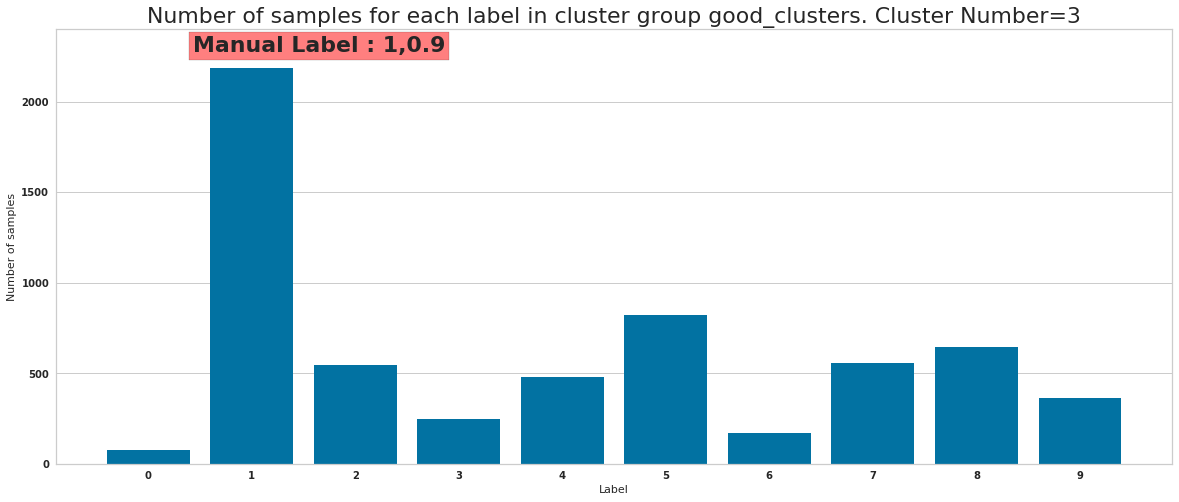

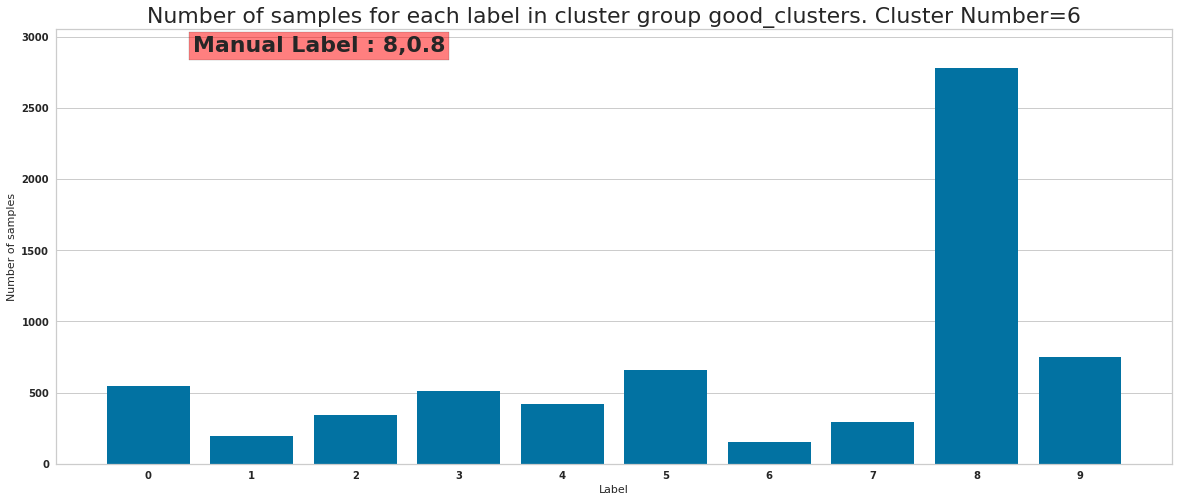

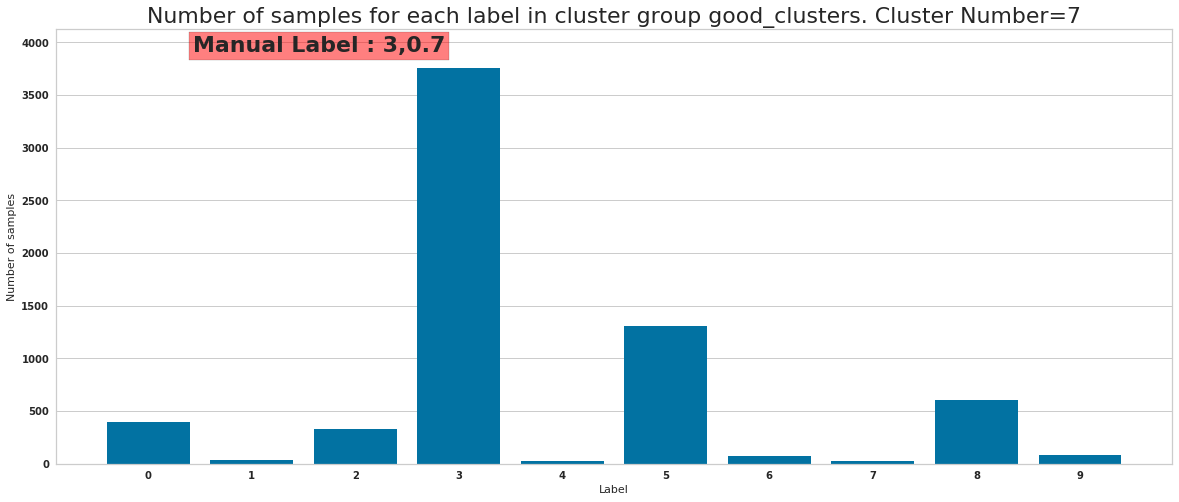

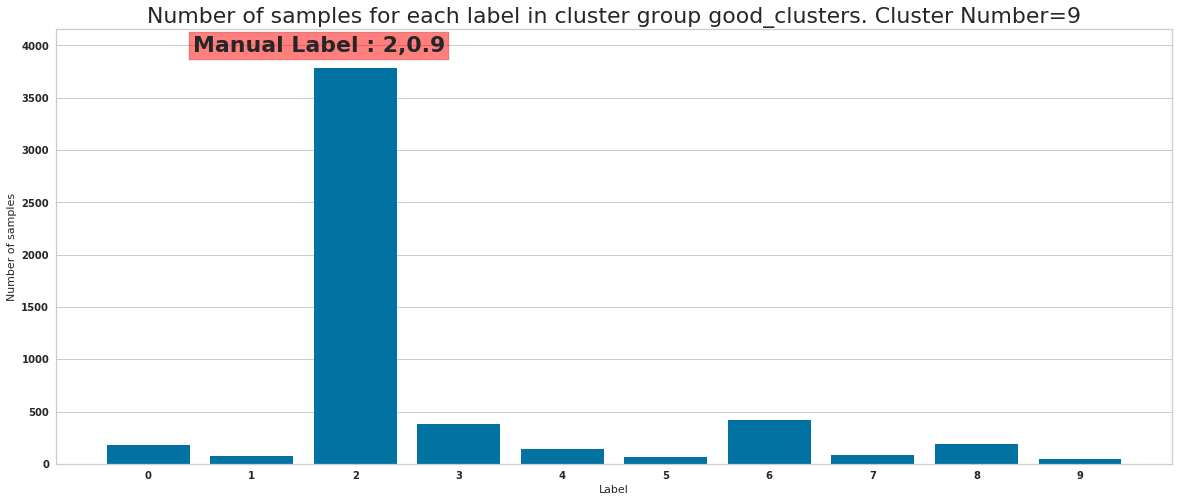

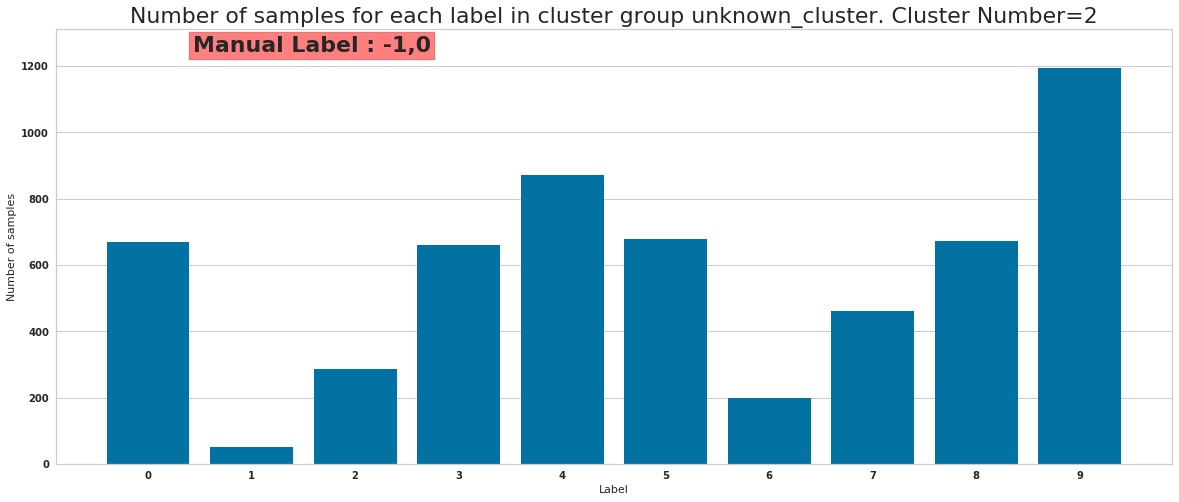

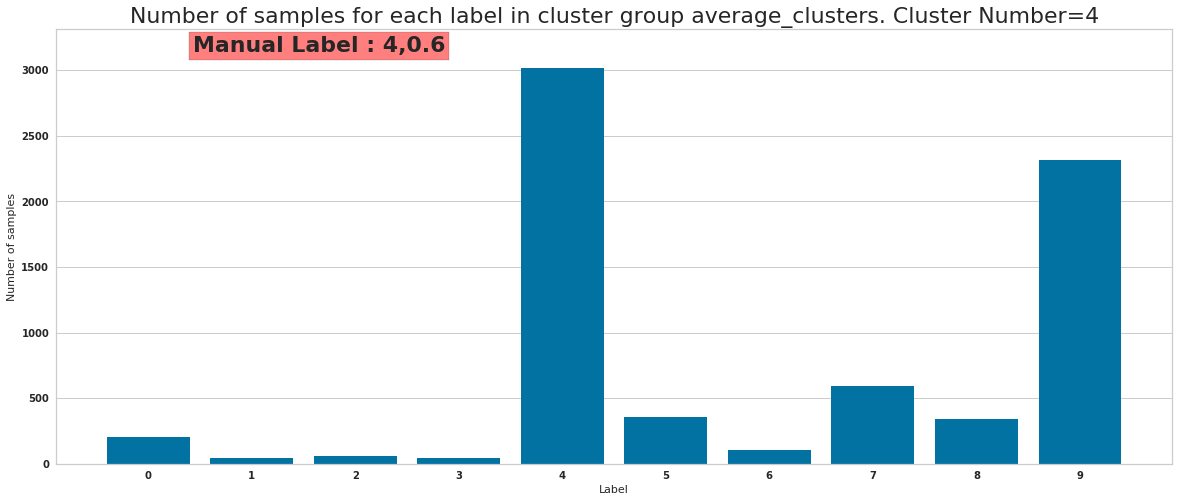

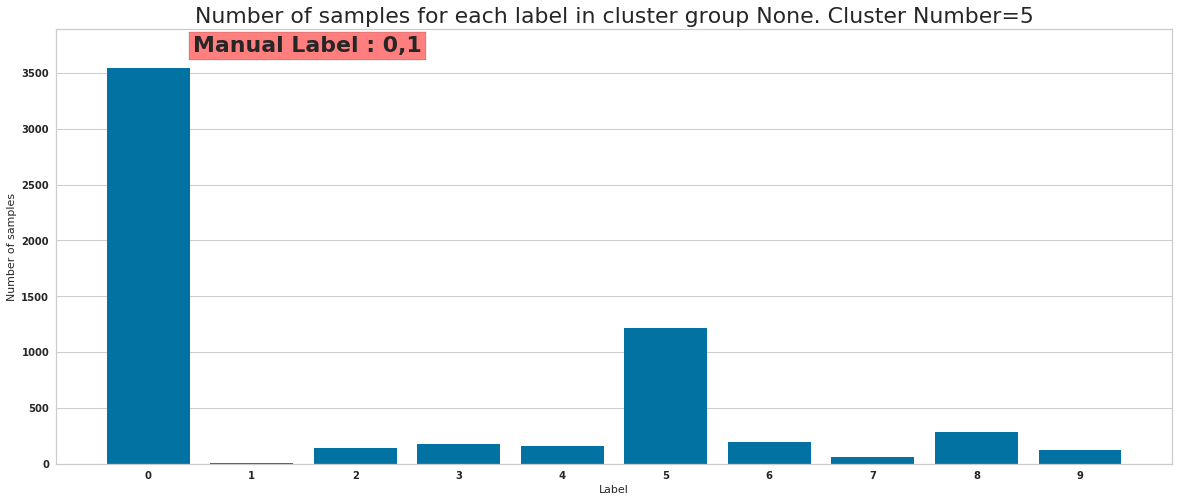

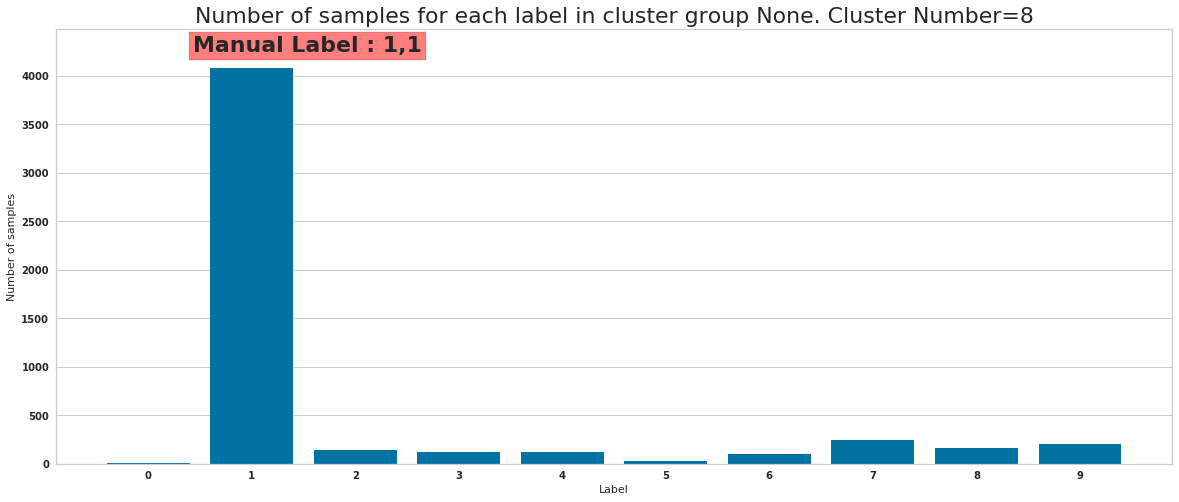

In [21]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

# For each sample, compute distance from respective cluster center

In [22]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(5747, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5442, 10)
(5742, 10)
(6078, 10)
(7072, 10)
(5898, 10)
(6654, 10)
(6626, 10)
(5213, 10)
(5368, 10)


2
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k5/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


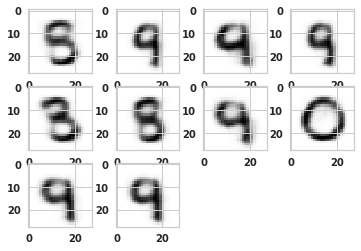

In [23]:
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [24]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1, 9, -1, -1,
                                        3,-1,-1,0,
                                         9,9
                                        ]
level_2_cluster_dict["manual_confidences"] = [0,0.8,0.7,0,
                                              0.6, 0, 0, 0.9,
                                              0.8,0.8
                                              ]
level2_manual_annotations[2] = level_2_cluster_dict


# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1,3,-1,
#                                         -1,-1,-1,2,
#                                         -1,2]
# level_2_cluster_dict["manual_confidences"] = [0.8,0.7,0,0.7,
#                                               0.6,0.6,0,0,
#                                               0,0.6
#                                              ]

# level2_manual_annotations[4] = level_2_cluster_dict


# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,9,4,7,
#                                         9,4,9,4,
#                                         4, 9]
# level_2_cluster_dict["manual_confidences"] = [0,0.9,0.6,0.6,
#                                               0.9,0.8,0.8,0.8,
#                                               0.7,0.8
#                                              ]
# level2_manual_annotations[9] = level_2_cluster_dict


# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1, 1, -1,
#                                         -1, -1, -1, 1,
#                                         -1, 1]
# level_2_cluster_dict["manual_confidences"] = [0,0,0,0,
#                                               0,0,0,0,
#                                               0,0
#                                              ]

# level2_manual_annotations[4] = level_2_cluster_dict



In [25]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)

2


In [26]:
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

10
Skipping distance computation for unknown cluster
1 (617,)
7 (626,)
8 (576,)
9 (567,)
4 (639,)


In [27]:
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster

In [28]:
level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [3,3,-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0.7,0.7,0,0]


In [29]:
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)

In [30]:
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


In [31]:
cluster_group_dict

{'good_clusters': <clearn.analysis.ClusterGroup at 0x7fa89142dbd0>,
 'unknown_cluster': <clearn.analysis.ClusterGroup at 0x7fa8949a3c90>,
 'average_clusters': <clearn.analysis.ClusterGroup at 0x7fa89143da10>,
 None: <clearn.analysis.ClusterGroup at 0x7fa89143d590>}

In [32]:
def assign_manual_label_and_confidence(df,
                                       manual_annotation_dict,
                                       dist_to_conf,
                                       cluster_group_dict,
                                       cluster_column_name_2,
                                       assign_only_correct=False
                                       ):
    def assign_label(_df, _manual_label):
        _indices = np.where((np.asarray(cluster_labels) == cluster.id)
                            & (_df[cluster_column_name_2].values == _cluster.id))[0]
        _df["manual_annotation"].iloc[_indices] = _manual_label
        dst = _distance_df.iloc[_indices]
        _df["manual_annotation_confidence"].iloc[_indices] = _cluster.manual_annotation.confidence * dist_to_conf(dst)
        _df["distance_to_confidence"].iloc[_indices] = dist_to_conf(dst)
        if assign_only_correct:
            wrong_indices = (_df["manual_annotation"] == _manual_label) & (_df["label"] != _manual_label)
            _df["manual_annotation_confidence"].loc[wrong_indices] = 0

    df["manual_annotation"] = np.ones(df.shape[0]) * -1
    df["manual_annotation_confidence"] = np.zeros(df.shape[0])
    df["distance_to_confidence"] = np.zeros(df.shape[0])
    # manually given label for each cluster center -1 for unknown (cluster which has no semantic meaning)
    manual_labels = manual_annotation_dict["manual_labels"]
    cluster_labels = np.asarray(manual_annotation_dict["cluster_labels"])

    num_clusters = len(manual_labels)
    for annotate_cluster in range(num_clusters):
        distance_df = df["distance_{}".format(annotate_cluster)]
        manual_label = manual_labels[annotate_cluster]
        _manual_confidence = manual_annotation_dict["manual_confidence"][annotate_cluster]
        if isinstance(manual_label, tuple) or isinstance(manual_label, list):
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            for _cluster in cluster.next_level_clusters["good_clusters"]:
                _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
                _manual_label = _cluster.manual_annotation.label
                if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                    # TODO add this code
                    pass
                elif _manual_label != -1:
                    assign_label(df, _manual_label)
        elif manual_label != -1:
            print("Manual Label", manual_label)
            indices = np.where(cluster_labels == annotate_cluster)

            df["manual_annotation"].iloc[indices] = manual_label
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(df[df["manual_annotation"] == manual_label].shape, cluster.details["cluster_data_frame"].shape)
            num_correct = df[(manual_label == df["manual_annotation"]) & (df["label"] == manual_label)].shape[0]
            print("Num correct={}".format(num_correct))

            percentage_correct = 100 * num_correct / df[df["manual_annotation"] == manual_label].shape[0]
            print(f"Cluster {annotate_cluster} Manual Label {manual_label} Percentage correct {percentage_correct}")
            dist = distance_df.iloc[indices]
            df["manual_annotation_confidence"].iloc[indices] = _manual_confidence * dist_to_conf(dist)
            if assign_only_correct:
                wrong_indices = (df["manual_annotation"] == manual_label) & (df["label"] != manual_label)
                print(len(wrong_indices), wrong_indices.shape)
                df["manual_annotation_confidence"].loc[wrong_indices] = 0
            df["distance_to_confidence"].iloc[indices] = dist_to_conf(dist)
        else:
            print("unknown")
            # TODO second level clustering is not used now so commenting the code
            # unknown, check if second level clustering is done or not
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(type(cluster.next_level_clusters))
            print(list(cluster.next_level_clusters.keys()))

            for cluster_group_name, cluster_group in cluster.next_level_clusters.items():
                for _cluster in cluster_group:
                    _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
                    _manual_label = _cluster.manual_annotation.label
                    print(f"********{_manual_label}*******")
                    if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                        # TODO add this code
                        pass
                    elif _manual_label != -1:
                        print("Manual_label", _manual_label)
                        assign_label(df, _manual_label)
                    else:
                        # Manual label is -1
                        # Label all the 600 samples in the second level cluster
                        indices = np.where((np.asarray(cluster_labels) == cluster.id)
                                           & (df[cluster_column_name_2].values == _cluster.id))[0]
                        print(f"Annotating individual samples {indices.shape}")
                        df["manual_annotation"].iloc[indices] = df["label"][indices].values
                        df["manual_annotation_confidence"].iloc[indices] = 1

                        _dist = _distance_df.iloc[indices]
                        df["distance_to_confidence"].iloc[indices] = dist_to_conf(_dist)

        print("********************************")


In [33]:
assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False
                                  )

Manual Label 6
(5747, 57) (5747, 33)
Num correct=4485
Cluster 0 Manual Label 6 Percentage correct 78.04071689577171
********************************
Manual Label 7
(5442, 57) (5442, 33)
Num correct=3919
Cluster 1 Manual Label 7 Percentage correct 72.01396545387725
********************************
unknown
<class 'dict'>
['unknown_cluster', 'good_clusters', 'average_clusters']
********-1*******
Annotating individual samples (588,)
********-1*******
Annotating individual samples (491,)
********-1*******
Annotating individual samples (536,)
********-1*******
Annotating individual samples (524,)
********-1*******
Annotating individual samples (578,)
********9*******
Manual_label 9
********0*******
Manual_label 0
********9*******
Manual_label 9
********9*******
Manual_label 9
********3*******
Manual_label 3
********************************
Manual Label 1
(6103, 57) (6078, 33)
Num correct=2208
Cluster 3 Manual Label 1 Percentage correct 36.178928395870884
********************************
Manu

# Save the dataframe with manual annotations

In [34]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([5747., 5442., 5742., 6078., 7072., 5898., 6654., 6626., 5213.,
        5368.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

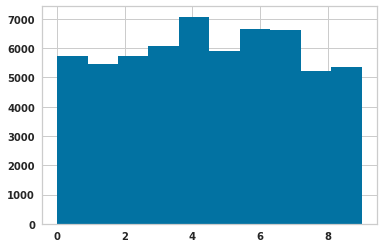

In [35]:
plt.hist(cluster_labels)

# Distribution of distance from cluster center

In [36]:
from clearn.analysis.cluster_utils import plot_distance_distribution

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


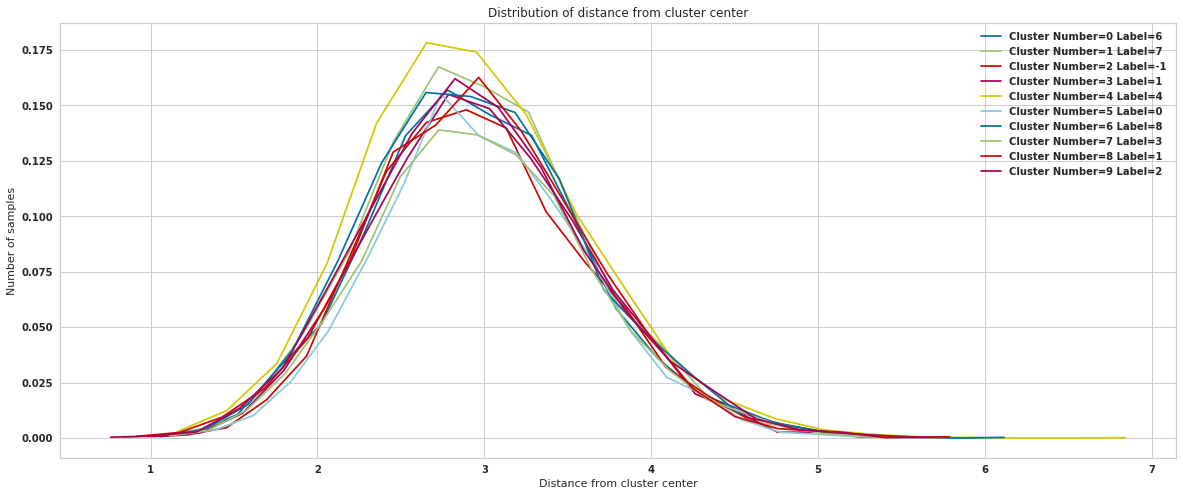

In [37]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

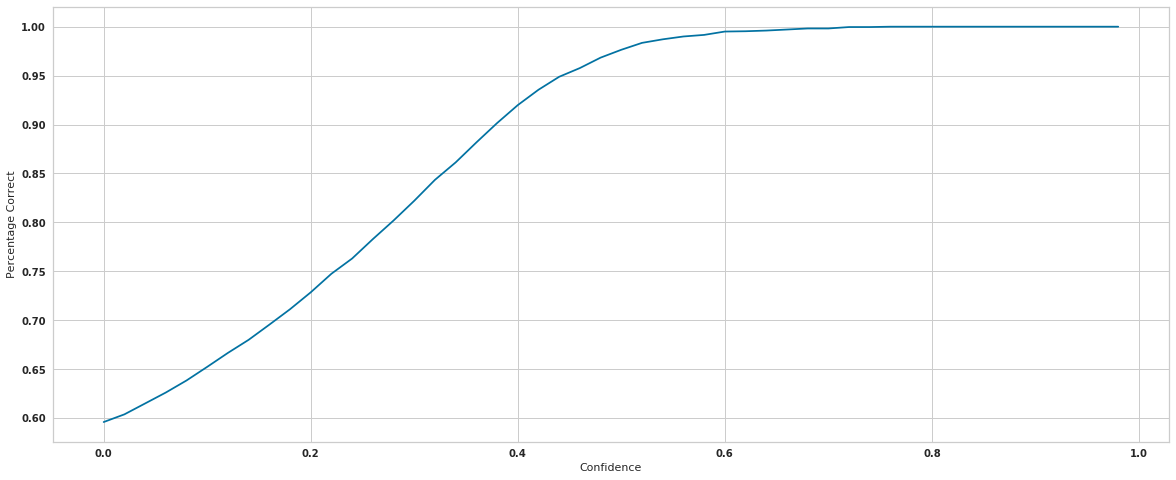

In [38]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

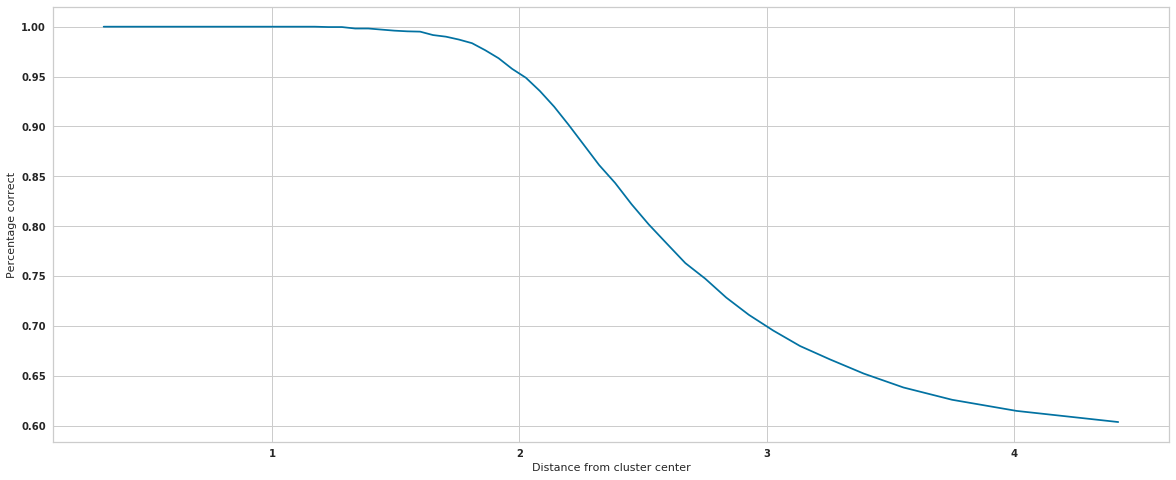

In [39]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [40]:
from shutil import copy2

In [41]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging 
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

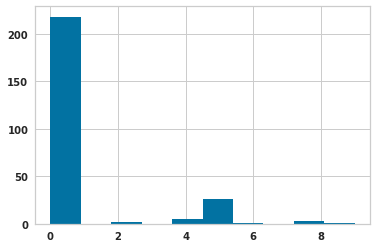

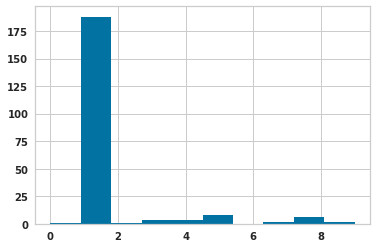

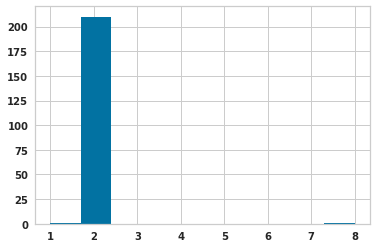

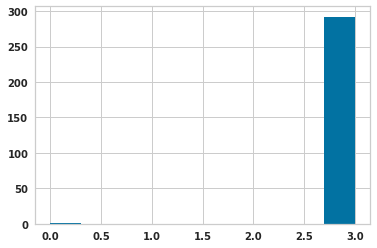

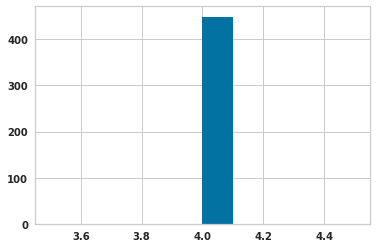

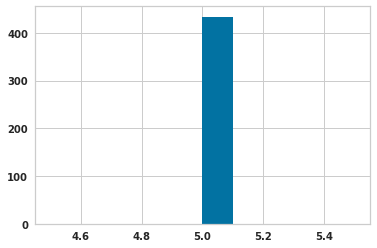

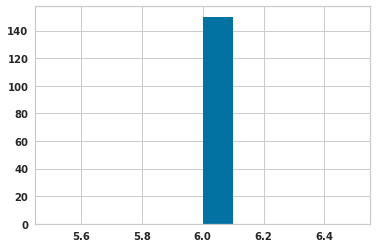

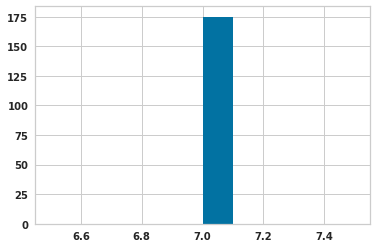

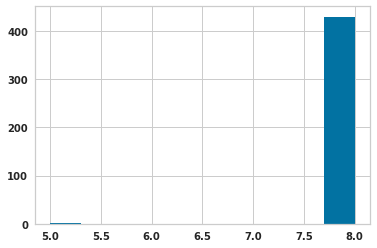

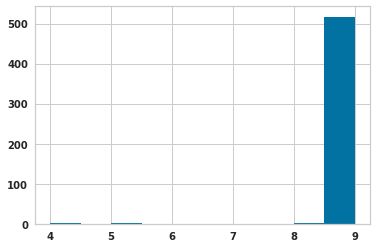

In [42]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [43]:
df.columns

Index(['label', 'label_predicted', 'mu_0', 'mu_1', 'mu_2', 'mu_3', 'mu_4',
       'mu_5', 'mu_6', 'mu_7', 'mu_8', 'mu_9', 'sigma_0', 'sigma_1', 'sigma_2',
       'sigma_3', 'sigma_4', 'sigma_5', 'sigma_6', 'sigma_7', 'sigma_8',
       'sigma_9', 'z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7',
       'z_8', 'z_9', 'cluster_level_1', 'distance_0', 'distance_1',
       'distance_2', 'distance_3', 'distance_4', 'distance_5', 'distance_6',
       'distance_7', 'distance_8', 'distance_9', 'cluster_level_2',
       'distance_level_2_2_0', 'distance_level_2_2_1', 'distance_level_2_2_2',
       'distance_level_2_2_3', 'distance_level_2_2_4', 'distance_level_2_2_5',
       'distance_level_2_2_6', 'distance_level_2_2_7', 'distance_level_2_2_8',
       'distance_level_2_2_9', 'manual_annotation',
       'manual_annotation_confidence', 'distance_to_confidence'],
      dtype='object')

# Iteration 2

In [44]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k5'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 11061.873580346637
INFO:tensorflow:Summary name Negative Log Likel

Epoch: 1/66, Nll_loss : 139.98980712890625 KLD:7.425905227661133  Supervised loss:0.2628166973590851
Epoch: 1/67, Nll_loss : 123.57636260986328 KLD:6.90704345703125  Supervised loss:0.25017979741096497
Epoch: 1/68, Nll_loss : 131.91366577148438 KLD:6.412666320800781  Supervised loss:0.2589893937110901
Epoch: 1/69, Nll_loss : 136.13023376464844 KLD:6.778510093688965  Supervised loss:0.42857593297958374
Epoch: 1/70, Nll_loss : 142.49954223632812 KLD:6.889223098754883  Supervised loss:0.2814730703830719
Epoch: 1/71, Nll_loss : 133.52061462402344 KLD:7.1388630867004395  Supervised loss:0.2453722059726715
Epoch: 1/72, Nll_loss : 132.4818115234375 KLD:7.383172988891602  Supervised loss:0.2551734447479248
Epoch: 1/73, Nll_loss : 134.42770385742188 KLD:7.648408889770508  Supervised loss:0.32402369379997253
Epoch: 1/74, Nll_loss : 133.84945678710938 KLD:7.665553092956543  Supervised loss:0.26388782262802124
Epoch: 1/75, Nll_loss : 141.28138732910156 KLD:7.684332847595215  Supervised loss:0.2417

Epoch: 1/149, Nll_loss : 139.8734893798828 KLD:8.365108489990234  Supervised loss:0.2799857258796692
Epoch: 1/150, Nll_loss : 130.31776428222656 KLD:7.809108734130859  Supervised loss:0.1972707211971283
Epoch: 1/151, Nll_loss : 139.28091430664062 KLD:7.698776721954346  Supervised loss:0.15287280082702637
Epoch: 1/152, Nll_loss : 131.27528381347656 KLD:7.169354438781738  Supervised loss:0.2039003074169159
Epoch: 1/153, Nll_loss : 132.33407592773438 KLD:6.708388328552246  Supervised loss:0.30250513553619385
Epoch: 1/154, Nll_loss : 131.43936157226562 KLD:6.585291862487793  Supervised loss:0.24963229894638062
Epoch: 1/155, Nll_loss : 139.47085571289062 KLD:6.696141242980957  Supervised loss:0.22181491553783417
Epoch: 1/156, Nll_loss : 141.06301879882812 KLD:6.99568510055542  Supervised loss:0.26020923256874084
Epoch: 1/157, Nll_loss : 134.4814453125 KLD:7.090932846069336  Supervised loss:0.19285456836223602
Epoch: 1/158, Nll_loss : 130.49057006835938 KLD:8.310781478881836  Supervised loss

Epoch: 1/231, Nll_loss : 134.42205810546875 KLD:7.648703575134277  Supervised loss:0.20834848284721375
Epoch: 1/232, Nll_loss : 137.35345458984375 KLD:7.74360990524292  Supervised loss:0.28655242919921875
Epoch: 1/233, Nll_loss : 127.2462158203125 KLD:8.079130172729492  Supervised loss:0.14879794418811798
Epoch: 1/234, Nll_loss : 130.12152099609375 KLD:8.32444953918457  Supervised loss:0.15033838152885437
Epoch: 1/235, Nll_loss : 131.44290161132812 KLD:7.840572357177734  Supervised loss:0.24834558367729187
Epoch: 1/236, Nll_loss : 132.46728515625 KLD:7.956751823425293  Supervised loss:0.2643676996231079
Epoch: 1/237, Nll_loss : 127.44556427001953 KLD:8.066917419433594  Supervised loss:0.1729695200920105
Epoch: 1/238, Nll_loss : 138.7841033935547 KLD:7.509398460388184  Supervised loss:0.27002596855163574
Epoch: 1/239, Nll_loss : 125.51891326904297 KLD:7.877081394195557  Supervised loss:0.20136040449142456
Epoch: 1/240, Nll_loss : 126.31378173828125 KLD:7.752412796020508  Supervised loss

Epoch: 1/312, Nll_loss : 139.6601104736328 KLD:7.557424545288086  Supervised loss:0.17423167824745178
Epoch: 1/313, Nll_loss : 137.54400634765625 KLD:7.881918907165527  Supervised loss:0.27321332693099976
Epoch: 1/314, Nll_loss : 137.32339477539062 KLD:7.563015937805176  Supervised loss:0.16593068838119507
Epoch: 1/315, Nll_loss : 124.64300537109375 KLD:7.493051052093506  Supervised loss:0.19035446643829346
Epoch: 1/316, Nll_loss : 127.92819213867188 KLD:7.5432915687561035  Supervised loss:0.22291719913482666
Epoch: 1/317, Nll_loss : 127.16715240478516 KLD:7.47067928314209  Supervised loss:0.19177283346652985
Epoch: 1/318, Nll_loss : 126.97675323486328 KLD:7.324544429779053  Supervised loss:0.16734428703784943
Epoch: 1/319, Nll_loss : 123.86107635498047 KLD:7.579540252685547  Supervised loss:0.1718597710132599
Epoch: 1/320, Nll_loss : 130.50091552734375 KLD:7.89945650100708  Supervised loss:0.18007180094718933
Epoch: 1/321, Nll_loss : 123.72650146484375 KLD:7.644622802734375  Supervise

Epoch: 1/393, Nll_loss : 128.59814453125 KLD:7.592296600341797  Supervised loss:0.2038605660200119
Epoch: 1/394, Nll_loss : 138.03717041015625 KLD:7.93504524230957  Supervised loss:0.19886262714862823
Epoch: 1/395, Nll_loss : 129.59091186523438 KLD:8.016773223876953  Supervised loss:0.16965511441230774
Epoch: 1/396, Nll_loss : 129.10386657714844 KLD:7.836069107055664  Supervised loss:0.2710569202899933
Epoch: 1/397, Nll_loss : 122.15371704101562 KLD:8.40938949584961  Supervised loss:0.1352073699235916
Epoch: 1/398, Nll_loss : 121.16926574707031 KLD:7.575193405151367  Supervised loss:0.11213432252407074
Epoch: 1/399, Nll_loss : 135.61476135253906 KLD:7.937898635864258  Supervised loss:0.16433236002922058
Epoch: 1/400, Nll_loss : 134.2273712158203 KLD:7.973356246948242  Supervised loss:0.1477000117301941
Epoch: 1/401, Nll_loss : 132.2747344970703 KLD:7.5556721687316895  Supervised loss:0.21527504920959473
Epoch: 1/402, Nll_loss : 122.45500183105469 KLD:7.920948028564453  Supervised loss:

Epoch: 1/475, Nll_loss : 126.06153869628906 KLD:7.655017852783203  Supervised loss:0.15066415071487427
Epoch: 1/476, Nll_loss : 131.65042114257812 KLD:7.8238115310668945  Supervised loss:0.25038406252861023
Epoch: 1/477, Nll_loss : 121.98636627197266 KLD:8.51824951171875  Supervised loss:0.18624542653560638
Epoch: 1/478, Nll_loss : 129.02088928222656 KLD:8.318710327148438  Supervised loss:0.1969412863254547
Epoch: 1/479, Nll_loss : 122.6600112915039 KLD:8.38402271270752  Supervised loss:0.219844788312912
Epoch: 1/480, Nll_loss : 134.91030883789062 KLD:8.09776782989502  Supervised loss:0.18034571409225464
Epoch: 1/481, Nll_loss : 127.33775329589844 KLD:7.746664524078369  Supervised loss:0.1691223680973053
Epoch: 1/482, Nll_loss : 132.45193481445312 KLD:7.191278457641602  Supervised loss:0.1583687663078308
Epoch: 1/483, Nll_loss : 129.38304138183594 KLD:7.432055473327637  Supervised loss:0.20143574476242065
Epoch: 1/484, Nll_loss : 128.50474548339844 KLD:7.203402519226074  Supervised los

Epoch: 1/558, Nll_loss : 123.39926147460938 KLD:7.686498641967773  Supervised loss:0.1596904695034027
Epoch: 1/559, Nll_loss : 126.93010711669922 KLD:7.403255939483643  Supervised loss:0.18958693742752075
Epoch: 1/560, Nll_loss : 123.02742767333984 KLD:7.96489143371582  Supervised loss:0.2517837584018707
Epoch: 1/561, Nll_loss : 122.66551971435547 KLD:7.391261100769043  Supervised loss:0.15446147322654724
Epoch: 1/562, Nll_loss : 124.72808837890625 KLD:7.409528732299805  Supervised loss:0.1902027279138565
Epoch: 1/563, Nll_loss : 128.47479248046875 KLD:7.4237141609191895  Supervised loss:0.24311473965644836
Epoch: 1/564, Nll_loss : 129.39402770996094 KLD:7.84894323348999  Supervised loss:0.21374571323394775
Epoch: 1/565, Nll_loss : 125.23605346679688 KLD:8.257545471191406  Supervised loss:0.13189837336540222
Epoch: 1/566, Nll_loss : 122.09162139892578 KLD:7.652918815612793  Supervised loss:0.12975111603736877
Epoch: 1/567, Nll_loss : 129.85919189453125 KLD:7.719961166381836  Supervised

Epoch: 1/639, Nll_loss : 125.69952392578125 KLD:7.590789794921875  Supervised loss:0.2206636667251587
Epoch: 1/640, Nll_loss : 133.38145446777344 KLD:7.566391468048096  Supervised loss:0.20609787106513977
Epoch: 1/641, Nll_loss : 128.744873046875 KLD:7.34894323348999  Supervised loss:0.324383944272995
Epoch: 1/642, Nll_loss : 123.00413513183594 KLD:7.3088765144348145  Supervised loss:0.1776958853006363
Epoch: 1/643, Nll_loss : 142.04531860351562 KLD:7.644500255584717  Supervised loss:0.24751576781272888
Epoch: 1/644, Nll_loss : 131.4747772216797 KLD:7.450201988220215  Supervised loss:0.16157741844654083
Epoch: 1/645, Nll_loss : 129.28407287597656 KLD:7.373615264892578  Supervised loss:0.13077667355537415
Epoch: 1/646, Nll_loss : 125.05701446533203 KLD:7.404454231262207  Supervised loss:0.15208987891674042
Epoch: 1/647, Nll_loss : 131.25596618652344 KLD:7.330709934234619  Supervised loss:0.1794954240322113
Epoch: 1/648, Nll_loss : 130.52618408203125 KLD:7.283675670623779  Supervised los

Epoch: 1/721, Nll_loss : 127.21253204345703 KLD:7.644330024719238  Supervised loss:0.16694718599319458
Epoch: 1/722, Nll_loss : 126.61292266845703 KLD:7.658797264099121  Supervised loss:0.17308515310287476
Epoch: 1/723, Nll_loss : 117.87109375 KLD:7.8544182777404785  Supervised loss:0.26532772183418274
Epoch: 1/724, Nll_loss : 123.48928833007812 KLD:8.215926170349121  Supervised loss:0.15872004628181458
Epoch: 1/725, Nll_loss : 127.83198547363281 KLD:8.239913940429688  Supervised loss:0.1688351184129715
Epoch: 1/726, Nll_loss : 127.4913558959961 KLD:7.787952423095703  Supervised loss:0.1459043025970459
Epoch: 1/727, Nll_loss : 127.37200164794922 KLD:7.819131851196289  Supervised loss:0.21306094527244568
Epoch: 1/728, Nll_loss : 127.62400817871094 KLD:7.636453151702881  Supervised loss:0.16847750544548035
Epoch: 1/729, Nll_loss : 125.1010971069336 KLD:7.89431095123291  Supervised loss:0.11960214376449585
Epoch: 1/730, Nll_loss : 120.98497009277344 KLD:7.203327178955078  Supervised loss:

Epoch: 1/802, Nll_loss : 121.48899841308594 KLD:7.656977653503418  Supervised loss:0.20149122178554535
Epoch: 1/803, Nll_loss : 120.01516723632812 KLD:8.34509563446045  Supervised loss:0.14720842242240906
Epoch: 1/804, Nll_loss : 123.21418762207031 KLD:7.927617073059082  Supervised loss:0.08203046023845673
Epoch: 1/805, Nll_loss : 126.14410400390625 KLD:8.534440994262695  Supervised loss:0.1839766800403595
Epoch: 1/806, Nll_loss : 128.2294464111328 KLD:8.311454772949219  Supervised loss:0.10751959681510925
Epoch: 1/807, Nll_loss : 120.44271850585938 KLD:8.429067611694336  Supervised loss:0.12897804379463196
Epoch: 1/808, Nll_loss : 119.45265197753906 KLD:7.6220502853393555  Supervised loss:0.1422097384929657
Epoch: 1/809, Nll_loss : 120.27855682373047 KLD:7.66342306137085  Supervised loss:0.1589142382144928
Epoch: 1/810, Nll_loss : 127.3025131225586 KLD:7.630770206451416  Supervised loss:0.24642068147659302
Epoch: 1/811, Nll_loss : 129.81121826171875 KLD:7.569766521453857  Supervised l

Epoch: 1/884, Nll_loss : 117.5878677368164 KLD:7.619872570037842  Supervised loss:0.18970194458961487
Epoch: 1/885, Nll_loss : 126.25526428222656 KLD:7.940488815307617  Supervised loss:0.15852880477905273
Epoch: 1/886, Nll_loss : 122.3720703125 KLD:7.730475902557373  Supervised loss:0.13944192230701447
Epoch: 1/887, Nll_loss : 128.0055389404297 KLD:7.992973327636719  Supervised loss:0.1681331992149353
Epoch: 1/888, Nll_loss : 122.39080810546875 KLD:8.004218101501465  Supervised loss:0.2206782102584839
Epoch: 1/889, Nll_loss : 119.27954864501953 KLD:7.876698970794678  Supervised loss:0.14640915393829346
Epoch: 1/890, Nll_loss : 126.22993469238281 KLD:8.023529052734375  Supervised loss:0.10370789468288422
Epoch: 1/891, Nll_loss : 129.59844970703125 KLD:7.698912143707275  Supervised loss:0.1886107176542282
Epoch: 1/892, Nll_loss : 133.7444610595703 KLD:7.623271942138672  Supervised loss:0.14997804164886475
Epoch: 1/893, Nll_loss : 124.29058837890625 KLD:7.69050407409668  Supervised loss:0

In [45]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k5/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-1870
 [*] Success to read SemiSupervisedClassifierMnist.model-1870
 [*] Load SUCCESS
Number of steps completed=1870
Number of epochs completed 2.0


In [46]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=45 z_min=-4.3692025999999995 z_max=4.257077
Latent vectors shape (59840, 10)


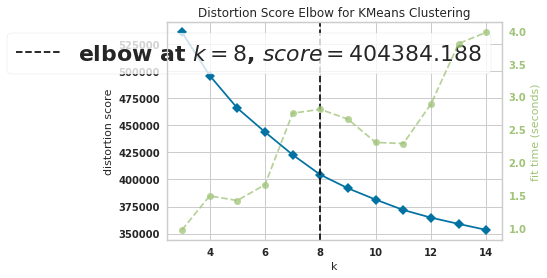

In [47]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k5/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-1870
 [*] Success to read SemiSupervisedClassifierMnist.model-1870
 [*] Load SUCCESS


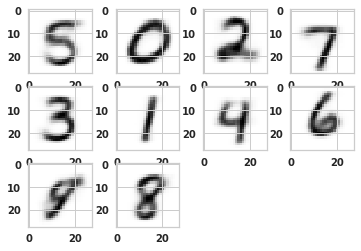

In [48]:
num_clusters = 10
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [49]:
import json
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [5, 0, 2, 7,
                                           3, 1, 4, 6,
                                           -1, 8
                                          ]
manual_annotation_json["manual_confidence"] = [0.7, 1, 0.8,0.8,
                                               0.7,1,0.7,0.9,
                                               0,0.9
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [50]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

In [51]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

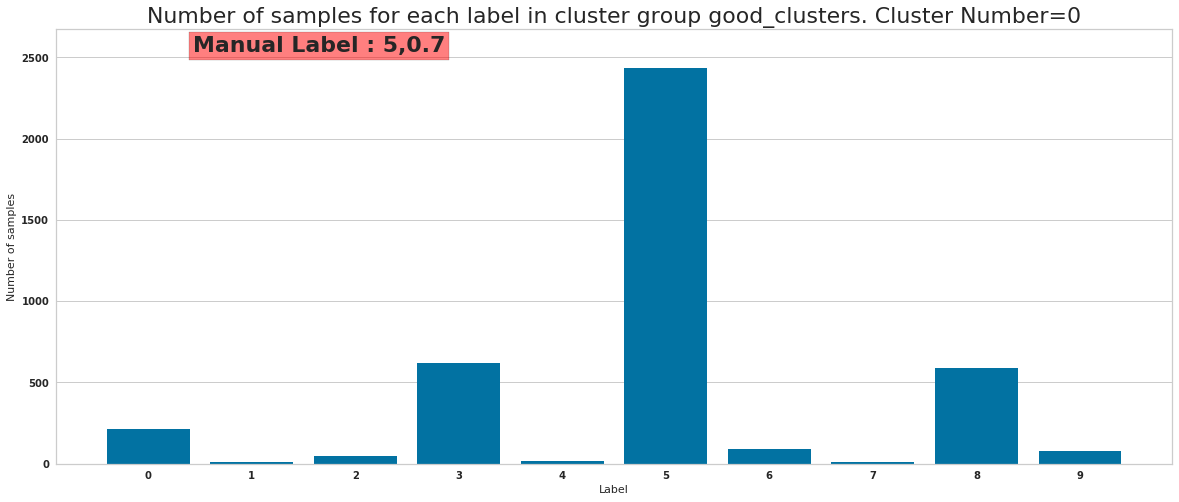

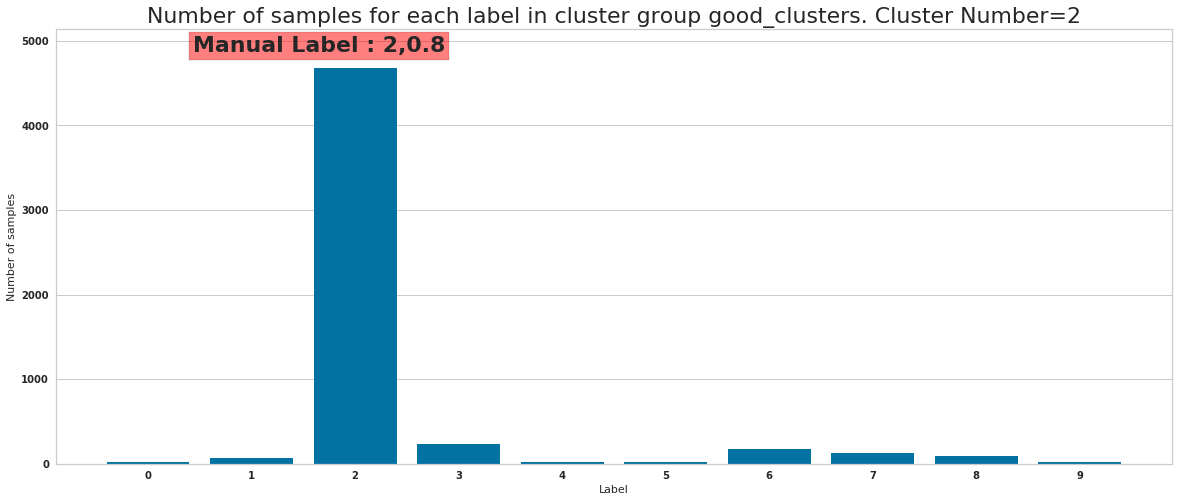

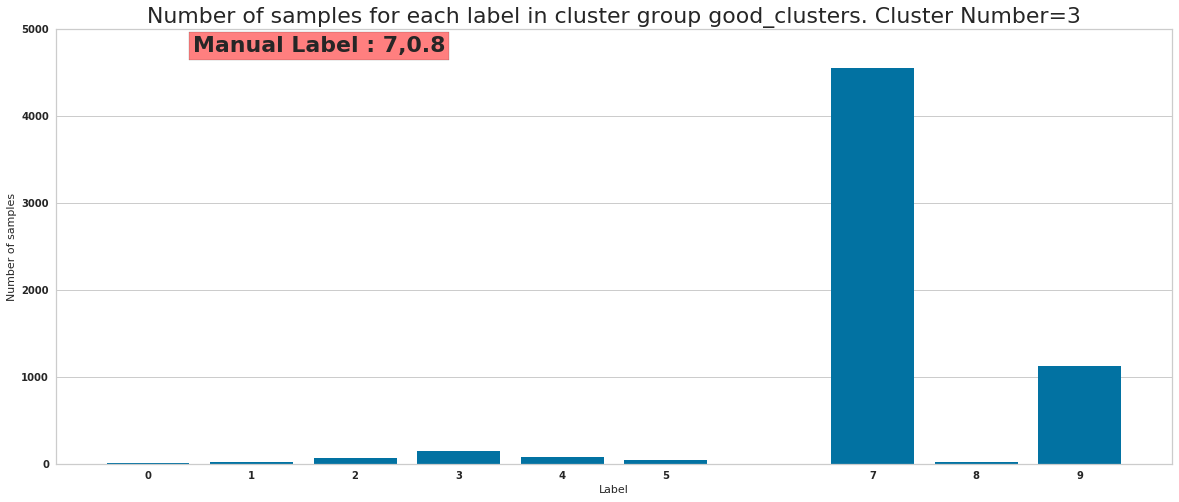

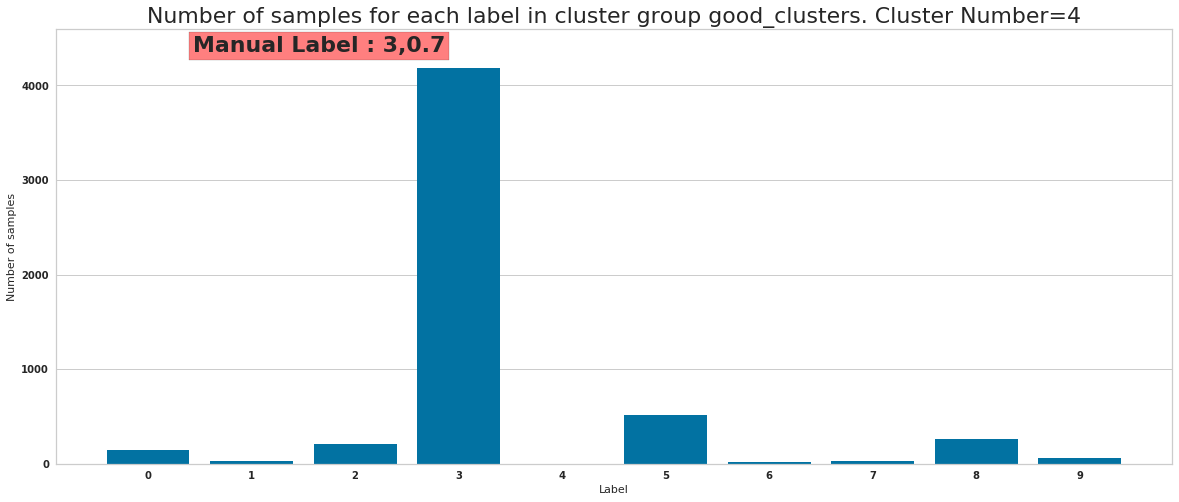

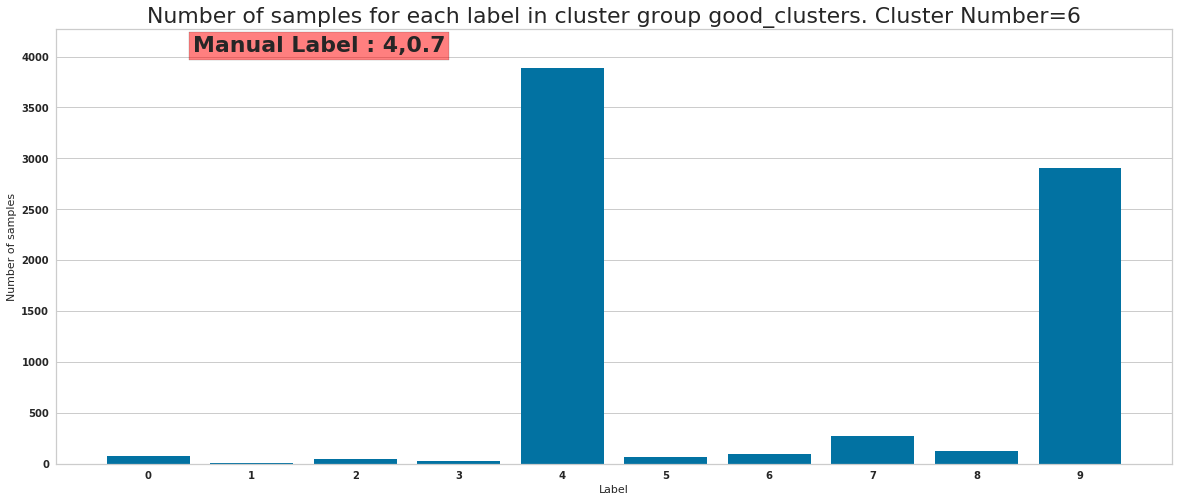

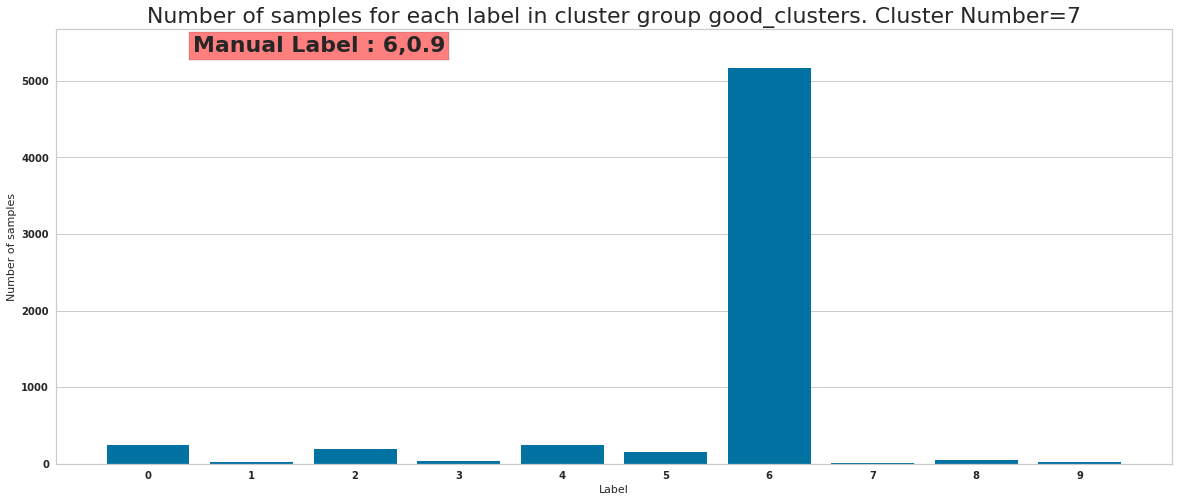

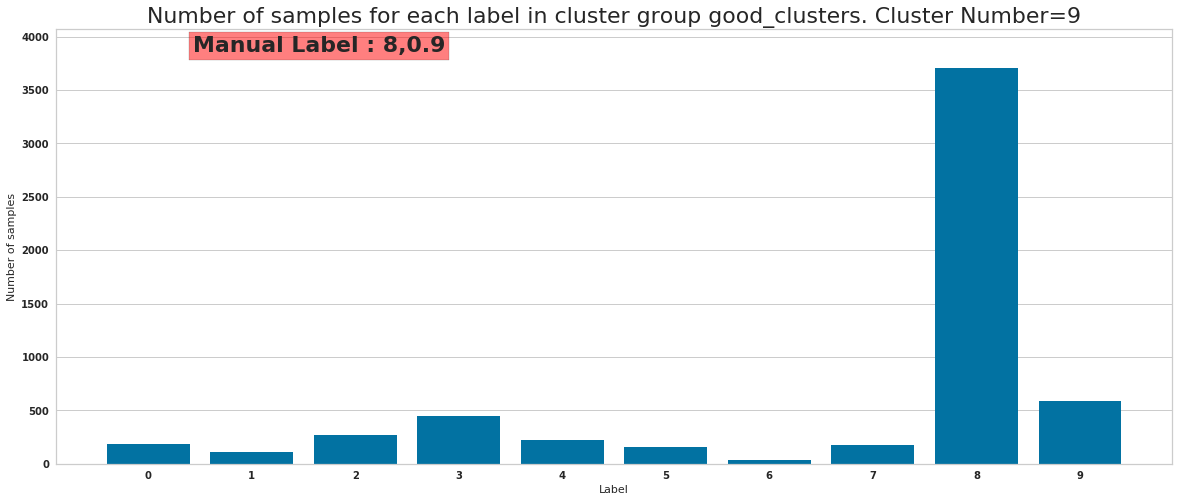

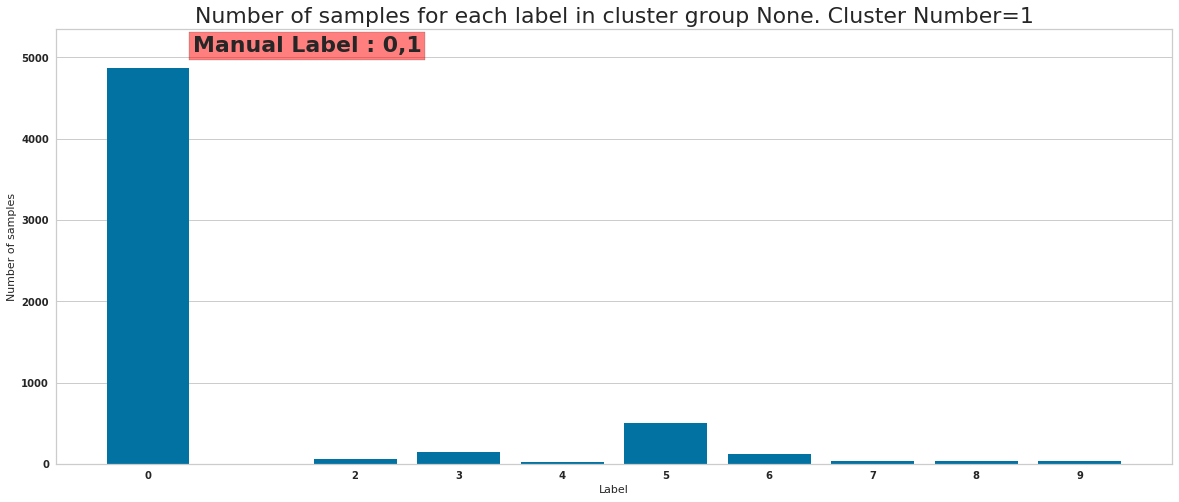

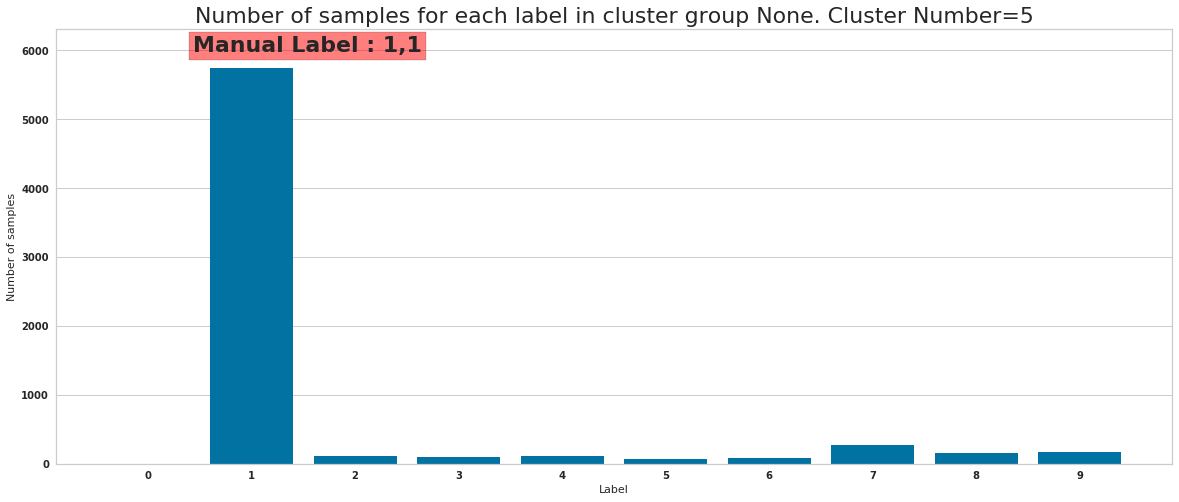

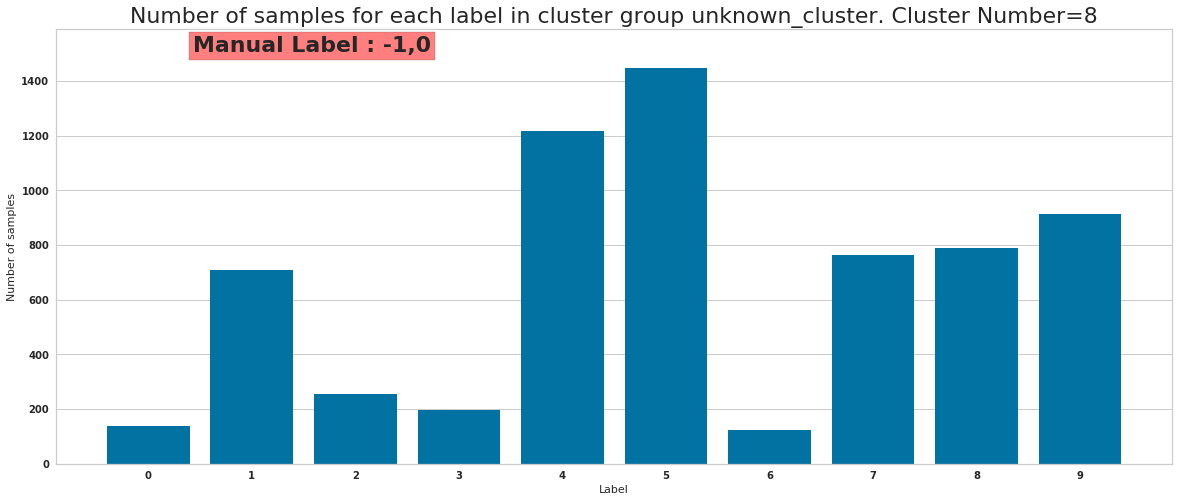

In [52]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [53]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(4111, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5830, 10)
(5472, 10)
(6054, 10)
(5464, 10)
(6826, 10)
(7509, 10)
(6126, 10)
(6555, 10)
(5893, 10)


8
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k5/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-1870
 [*] Success to read SemiSupervisedClassifierMnist.model-1870
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


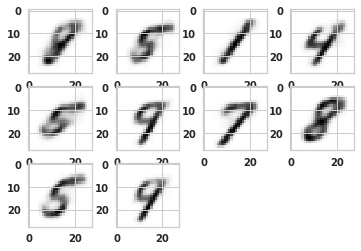

In [54]:
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [55]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1,-1,1,4,
                                        -1,9,7,8,
                                        -1,9]
level_2_cluster_dict["manual_confidences"] = [0, 0, 0.9, 0.6,
                                              0, 0.7, 0.7, 0.8,
                                              0, 0.7]
level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [1,5,-1,-1,
#                                         -1,5,8,-1,
#                                         -1,-1]
# level_2_cluster_dict["manual_confidences"] = [1,0.6,0,0,
#                                              0,0.6,0.6,0,
#                                              0,0]
# level2_manual_annotations[7] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4,9,9,9,
#                                         4,9,9,9,
#                                         4,9]
# level_2_cluster_dict["manual_confidences"] = [0.8,0.9,0.9,0.9,
#                                               0.8,0.9,0.9,0.9,
#                                               0.8,0.9
#                                              ]
# level2_manual_annotations[6] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [0, -1]
# level_2_cluster_dict["manual_confidences"] = [0.7, 0]
# level2_manual_annotations[14] = level_2_cluster_dict



In [56]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)
    

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

8
10
Skipping distance computation for unknown cluster
2 (685,)
5 (664,)
6 (547,)
7 (648,)
9 (682,)
3 (782,)
Manual Label 5
(4111, 57) (4111, 33)
Num correct=2431
Cluster 0 Manual Label 5 Percentage correct 59.13403064947701
********************************
Manual Label 0
(5830, 57) (5830, 33)
Num correct=4865
Cluster 1 Manual Label 0 Percentage correct 83.44768439108061
********************************
Manual Label 2
(5472, 57) (5472, 33)
Num correct=4671
Cluster 2 Manual Label 2 Percentage correct 85.36184210526316
********************************
Manual Label 7
(6054, 57) (6054, 33)
Num correct=4548
Cluster 3 Manual Label 7 Percentage correct 75.12388503468782
********************************
Manual Label 3
(5464, 57) (5464, 33)
Num correct=4179
Cluster 4 Manual Label 3 Percentage correct 76.48243045387994
********************************
Manual Label 1
(6826, 57) (6826, 33)
Num correct=5739
Cluster 5 Manual Label 1 Percentage correct 84.07559331966013
******************************

In [57]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([4111., 5830., 5472., 6054., 5464., 6826., 7509., 6126., 6555.,
        5893.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

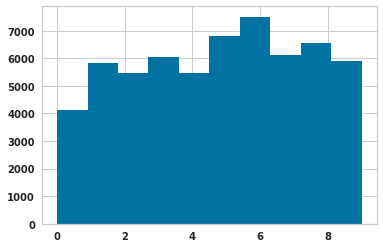

In [58]:
plt.hist(cluster_labels)

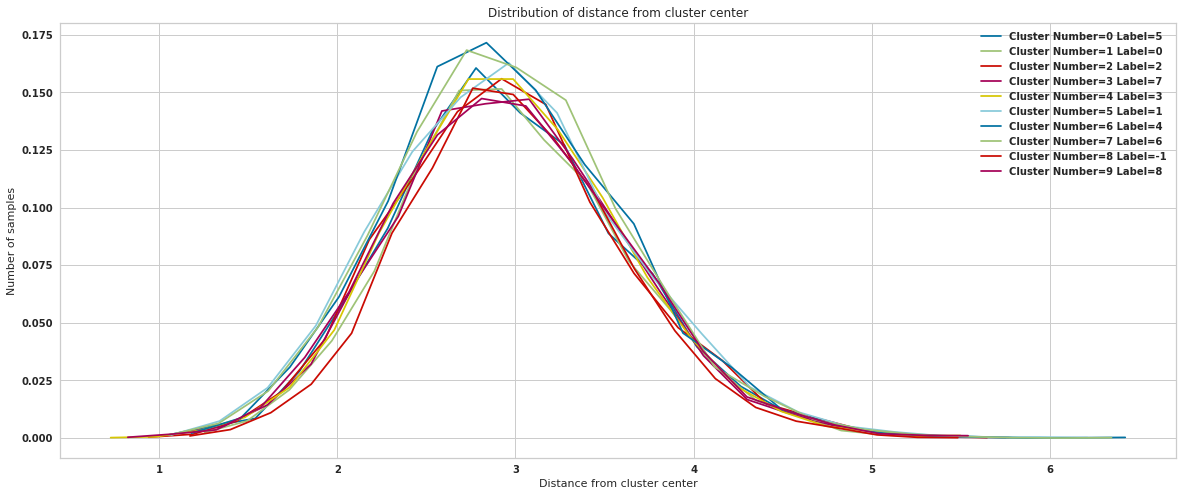

In [59]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

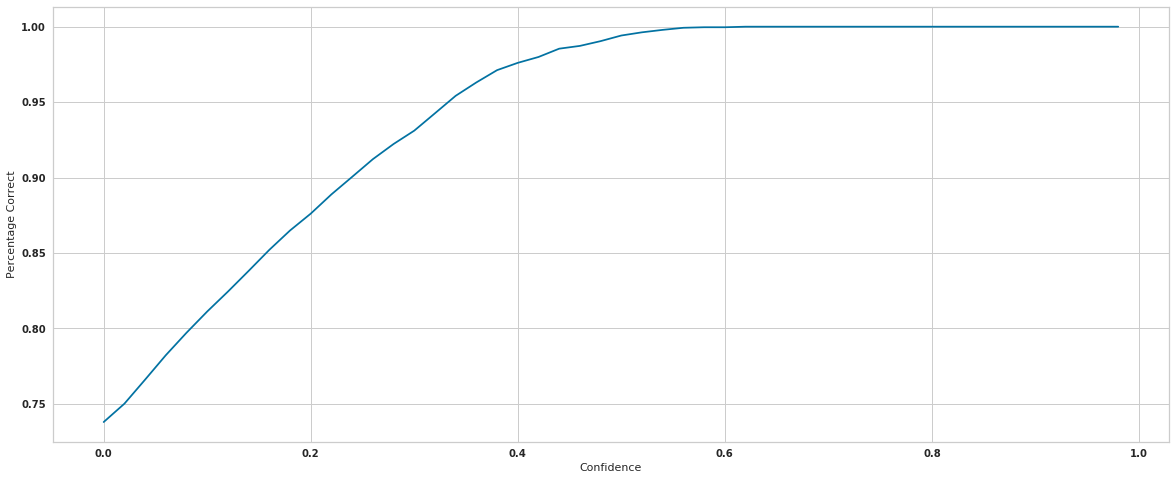

In [60]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

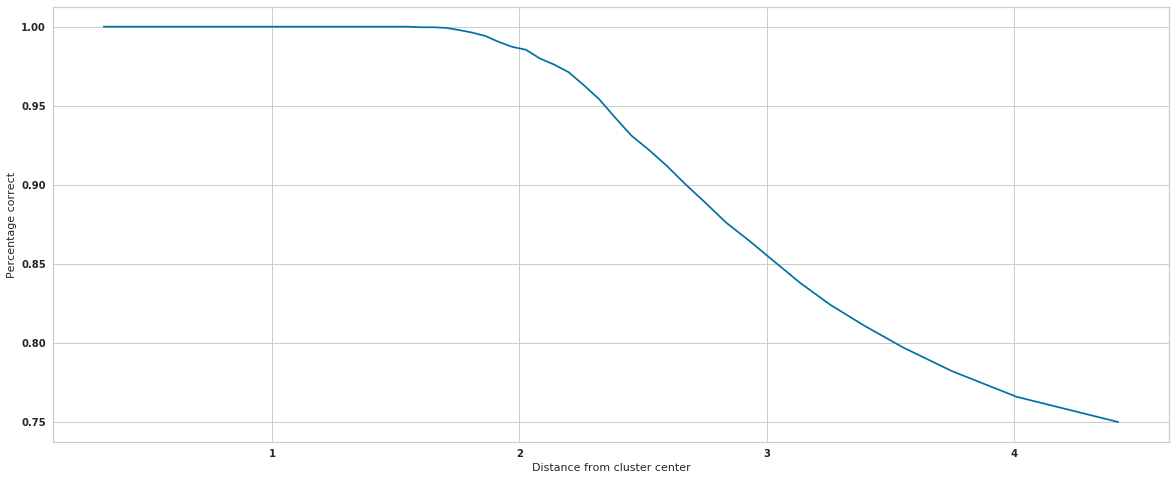

In [61]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [62]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

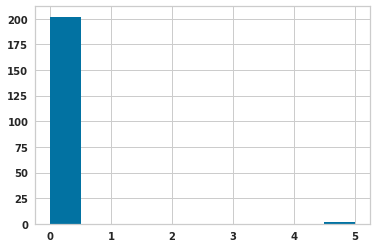

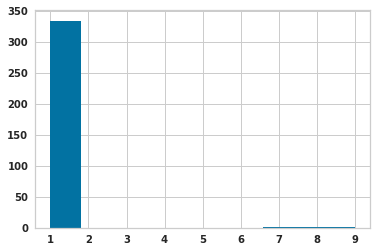

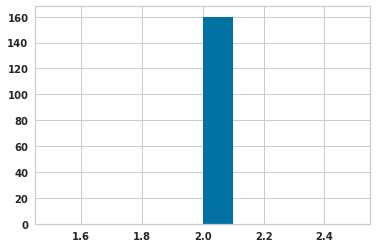

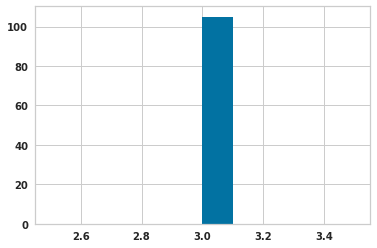

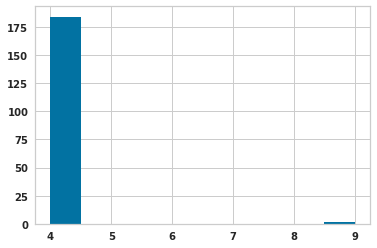

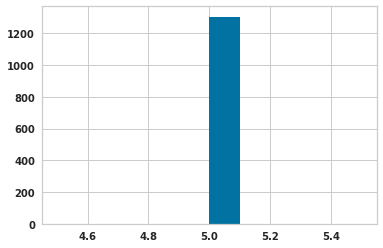

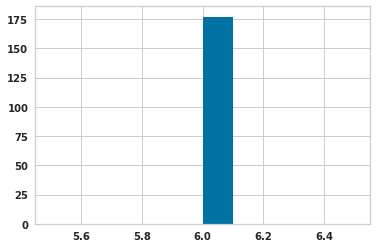

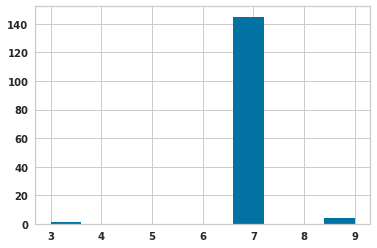

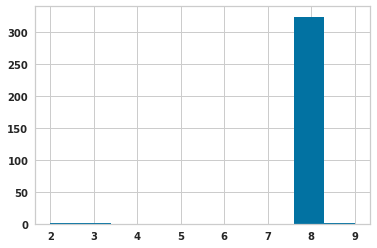

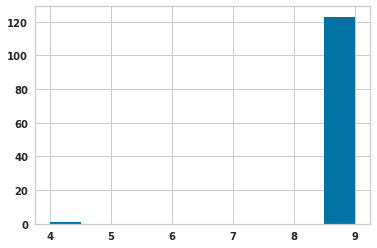

In [63]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 3

In [64]:
num_epochs
num_epochs += 1
print(num_epochs)

3


In [65]:
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
print(manual_annotation_file)

manual_annotation_epoch_2.0.csv


In [66]:
#num_epochs += 1
#manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k5'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 11142.061336380673
INFO:tensorflow:Summary name Negative Log Likel

Epoch: 2/65, Nll_loss : 126.36367797851562 KLD:8.291512489318848  Supervised loss:0.1659846007823944
Epoch: 2/66, Nll_loss : 114.86769104003906 KLD:7.7224531173706055  Supervised loss:0.09654905647039413
Epoch: 2/67, Nll_loss : 119.36109161376953 KLD:7.215038776397705  Supervised loss:0.1413029134273529
Epoch: 2/68, Nll_loss : 131.07427978515625 KLD:7.602203845977783  Supervised loss:0.13992297649383545
Epoch: 2/69, Nll_loss : 134.11190795898438 KLD:7.62109375  Supervised loss:0.15290769934654236
Epoch: 2/70, Nll_loss : 121.21546936035156 KLD:8.183002471923828  Supervised loss:0.1225976049900055
Epoch: 2/71, Nll_loss : 119.70448303222656 KLD:8.255922317504883  Supervised loss:0.15580236911773682
Epoch: 2/72, Nll_loss : 127.12677001953125 KLD:8.603751182556152  Supervised loss:0.14899733662605286
Epoch: 2/73, Nll_loss : 119.78038787841797 KLD:8.59952449798584  Supervised loss:0.10388240218162537
Epoch: 2/74, Nll_loss : 129.37510681152344 KLD:8.848148345947266  Supervised loss:0.15755453

Epoch: 2/148, Nll_loss : 131.10301208496094 KLD:8.396049499511719  Supervised loss:0.14437666535377502
Epoch: 2/149, Nll_loss : 123.611572265625 KLD:8.10076904296875  Supervised loss:0.140615776181221
Epoch: 2/150, Nll_loss : 129.4452667236328 KLD:8.909923553466797  Supervised loss:0.08072777092456818
Epoch: 2/151, Nll_loss : 123.5438461303711 KLD:8.378506660461426  Supervised loss:0.11630571633577347
Epoch: 2/152, Nll_loss : 124.27226257324219 KLD:8.224392890930176  Supervised loss:0.15556907653808594
Epoch: 2/153, Nll_loss : 117.2010269165039 KLD:8.497783660888672  Supervised loss:0.09892695397138596
Epoch: 2/154, Nll_loss : 127.99970245361328 KLD:8.526693344116211  Supervised loss:0.20473000407218933
Epoch: 2/155, Nll_loss : 132.52493286132812 KLD:8.494647026062012  Supervised loss:0.11562085151672363
Epoch: 2/156, Nll_loss : 125.09808349609375 KLD:8.175060272216797  Supervised loss:0.0780295729637146
Epoch: 2/157, Nll_loss : 127.26634979248047 KLD:8.728445053100586  Supervised loss

Epoch: 2/230, Nll_loss : 127.85066223144531 KLD:8.145228385925293  Supervised loss:0.10741141438484192
Epoch: 2/231, Nll_loss : 127.60608673095703 KLD:8.199371337890625  Supervised loss:0.08584257960319519
Epoch: 2/232, Nll_loss : 118.37847137451172 KLD:8.207910537719727  Supervised loss:0.11591655015945435
Epoch: 2/233, Nll_loss : 121.96182250976562 KLD:8.643424987792969  Supervised loss:0.11893252283334732
Epoch: 2/234, Nll_loss : 122.25308227539062 KLD:8.341053009033203  Supervised loss:0.08722284436225891
Epoch: 2/235, Nll_loss : 123.89112091064453 KLD:8.337239265441895  Supervised loss:0.11310434341430664
Epoch: 2/236, Nll_loss : 123.98312377929688 KLD:8.213861465454102  Supervised loss:0.1282852739095688
Epoch: 2/237, Nll_loss : 131.91888427734375 KLD:8.121521949768066  Supervised loss:0.15230780839920044
Epoch: 2/238, Nll_loss : 119.73927307128906 KLD:8.195760726928711  Supervised loss:0.08245222270488739
Epoch: 2/239, Nll_loss : 121.42343139648438 KLD:8.354595184326172  Supervi

Epoch: 2/311, Nll_loss : 131.16156005859375 KLD:7.961662292480469  Supervised loss:0.15605513751506805
Epoch: 2/312, Nll_loss : 131.2082977294922 KLD:8.371671676635742  Supervised loss:0.12857159972190857
Epoch: 2/313, Nll_loss : 129.0211181640625 KLD:8.071725845336914  Supervised loss:0.12105046212673187
Epoch: 2/314, Nll_loss : 117.28268432617188 KLD:7.964722156524658  Supervised loss:0.11740919947624207
Epoch: 2/315, Nll_loss : 121.44711303710938 KLD:8.1572847366333  Supervised loss:0.1283290684223175
Epoch: 2/316, Nll_loss : 122.59110260009766 KLD:8.057979583740234  Supervised loss:0.15594199299812317
Epoch: 2/317, Nll_loss : 120.98245239257812 KLD:8.094528198242188  Supervised loss:0.1283225566148758
Epoch: 2/318, Nll_loss : 115.75163269042969 KLD:8.47908878326416  Supervised loss:0.13316792249679565
Epoch: 2/319, Nll_loss : 119.47268676757812 KLD:9.012772560119629  Supervised loss:0.07682983577251434
Epoch: 2/320, Nll_loss : 119.40116119384766 KLD:8.30154037475586  Supervised los

Epoch: 2/393, Nll_loss : 127.13043212890625 KLD:8.520709991455078  Supervised loss:0.09836828708648682
Epoch: 2/394, Nll_loss : 125.67831420898438 KLD:8.334376335144043  Supervised loss:0.08444671332836151
Epoch: 2/395, Nll_loss : 125.88920593261719 KLD:8.061607360839844  Supervised loss:0.15482564270496368
Epoch: 2/396, Nll_loss : 120.73395538330078 KLD:8.608657836914062  Supervised loss:0.09970442950725555
Epoch: 2/397, Nll_loss : 118.11420440673828 KLD:8.055906295776367  Supervised loss:0.1096031591296196
Epoch: 2/398, Nll_loss : 126.89798736572266 KLD:8.979217529296875  Supervised loss:0.07521909475326538
Epoch: 2/399, Nll_loss : 125.4742431640625 KLD:8.923547744750977  Supervised loss:0.05768695846199989
Epoch: 2/400, Nll_loss : 123.38421630859375 KLD:8.308130264282227  Supervised loss:0.13576991856098175
Epoch: 2/401, Nll_loss : 118.19375610351562 KLD:8.26716423034668  Supervised loss:0.0745527371764183
Epoch: 2/402, Nll_loss : 125.09654235839844 KLD:8.233004570007324  Supervised

Epoch: 2/474, Nll_loss : 120.34832763671875 KLD:8.184490203857422  Supervised loss:0.14943042397499084
Epoch: 2/475, Nll_loss : 124.19234466552734 KLD:8.448844909667969  Supervised loss:0.12087789177894592
Epoch: 2/476, Nll_loss : 120.79411315917969 KLD:8.932838439941406  Supervised loss:0.09403534978628159
Epoch: 2/477, Nll_loss : 122.00179290771484 KLD:8.613333702087402  Supervised loss:0.08430992066860199
Epoch: 2/478, Nll_loss : 119.4325180053711 KLD:8.44454574584961  Supervised loss:0.08585812151432037
Epoch: 2/479, Nll_loss : 126.15745544433594 KLD:8.58671760559082  Supervised loss:0.1259278506040573
Epoch: 2/480, Nll_loss : 119.3804931640625 KLD:8.387237548828125  Supervised loss:0.1129520833492279
Epoch: 2/481, Nll_loss : 123.19161224365234 KLD:8.31258487701416  Supervised loss:0.11190064251422882
Epoch: 2/482, Nll_loss : 124.52424621582031 KLD:8.385321617126465  Supervised loss:0.137888103723526
Epoch: 2/483, Nll_loss : 123.58638763427734 KLD:8.375652313232422  Supervised loss

Epoch: 2/557, Nll_loss : 120.79757690429688 KLD:8.469377517700195  Supervised loss:0.13423117995262146
Epoch: 2/558, Nll_loss : 119.7106704711914 KLD:8.1560697555542  Supervised loss:0.11787868291139603
Epoch: 2/559, Nll_loss : 120.79058837890625 KLD:8.455810546875  Supervised loss:0.10481645911931992
Epoch: 2/560, Nll_loss : 115.44953918457031 KLD:8.302024841308594  Supervised loss:0.12088557332754135
Epoch: 2/561, Nll_loss : 116.68077087402344 KLD:8.189701080322266  Supervised loss:0.17027541995048523
Epoch: 2/562, Nll_loss : 122.18266296386719 KLD:8.187740325927734  Supervised loss:0.15072226524353027
Epoch: 2/563, Nll_loss : 123.64335632324219 KLD:8.25298023223877  Supervised loss:0.14714056253433228
Epoch: 2/564, Nll_loss : 121.8620834350586 KLD:8.739164352416992  Supervised loss:0.06732678413391113
Epoch: 2/565, Nll_loss : 114.30475616455078 KLD:8.674066543579102  Supervised loss:0.08526190370321274
Epoch: 2/566, Nll_loss : 120.57920837402344 KLD:8.583113670349121  Supervised los

Epoch: 2/639, Nll_loss : 129.53590393066406 KLD:8.1798095703125  Supervised loss:0.1541653275489807
Epoch: 2/640, Nll_loss : 120.06533813476562 KLD:7.931899070739746  Supervised loss:0.14650630950927734
Epoch: 2/641, Nll_loss : 121.69023895263672 KLD:8.055988311767578  Supervised loss:0.2331407070159912
Epoch: 2/642, Nll_loss : 136.34030151367188 KLD:8.660430908203125  Supervised loss:0.12351998686790466
Epoch: 2/643, Nll_loss : 127.2589111328125 KLD:8.237462997436523  Supervised loss:0.12763261795043945
Epoch: 2/644, Nll_loss : 123.59844970703125 KLD:8.459709167480469  Supervised loss:0.08466161787509918
Epoch: 2/645, Nll_loss : 120.05801391601562 KLD:8.388731002807617  Supervised loss:0.09744174033403397
Epoch: 2/646, Nll_loss : 123.5154800415039 KLD:8.175349235534668  Supervised loss:0.11529429256916046
Epoch: 2/647, Nll_loss : 122.39407348632812 KLD:8.246267318725586  Supervised loss:0.1642008125782013
Epoch: 2/648, Nll_loss : 125.21684265136719 KLD:8.804941177368164  Supervised lo

Epoch: 2/720, Nll_loss : 119.278076171875 KLD:8.389758110046387  Supervised loss:0.09291687607765198
Epoch: 2/721, Nll_loss : 120.09171295166016 KLD:8.180511474609375  Supervised loss:0.06663109362125397
Epoch: 2/722, Nll_loss : 114.55785369873047 KLD:8.137060165405273  Supervised loss:0.11194626241922379
Epoch: 2/723, Nll_loss : 118.73103332519531 KLD:8.55398178100586  Supervised loss:0.1378801316022873
Epoch: 2/724, Nll_loss : 125.11651611328125 KLD:8.293002128601074  Supervised loss:0.07109300792217255
Epoch: 2/725, Nll_loss : 121.3125228881836 KLD:8.179361343383789  Supervised loss:0.09192463755607605
Epoch: 2/726, Nll_loss : 123.52276611328125 KLD:8.156013488769531  Supervised loss:0.15654312074184418
Epoch: 2/727, Nll_loss : 121.02944946289062 KLD:8.116304397583008  Supervised loss:0.10265347361564636
Epoch: 2/728, Nll_loss : 118.23577117919922 KLD:8.358165740966797  Supervised loss:0.07721179723739624
Epoch: 2/729, Nll_loss : 116.0025634765625 KLD:7.758746147155762  Supervised l

Epoch: 2/801, Nll_loss : 116.7054443359375 KLD:7.966528415679932  Supervised loss:0.1184363141655922
Epoch: 2/802, Nll_loss : 119.91128540039062 KLD:8.212379455566406  Supervised loss:0.08066540956497192
Epoch: 2/803, Nll_loss : 117.96652221679688 KLD:7.734375  Supervised loss:0.11662270128726959
Epoch: 2/804, Nll_loss : 121.62103271484375 KLD:8.192920684814453  Supervised loss:0.0928686335682869
Epoch: 2/805, Nll_loss : 123.97869873046875 KLD:8.104616165161133  Supervised loss:0.07787687331438065
Epoch: 2/806, Nll_loss : 115.09803771972656 KLD:8.793853759765625  Supervised loss:0.08289718627929688
Epoch: 2/807, Nll_loss : 116.73828125 KLD:8.033637046813965  Supervised loss:0.11380381882190704
Epoch: 2/808, Nll_loss : 116.91588592529297 KLD:8.246315002441406  Supervised loss:0.09000428020954132
Epoch: 2/809, Nll_loss : 122.19610595703125 KLD:8.659198760986328  Supervised loss:0.06999363005161285
Epoch: 2/810, Nll_loss : 122.66803741455078 KLD:8.688432693481445  Supervised loss:0.112106

Epoch: 2/883, Nll_loss : 110.71516418457031 KLD:8.751825332641602  Supervised loss:0.09895411133766174
Epoch: 2/884, Nll_loss : 120.56111907958984 KLD:8.771873474121094  Supervised loss:0.1013607382774353
Epoch: 2/885, Nll_loss : 116.90681457519531 KLD:8.321514129638672  Supervised loss:0.08600753545761108
Epoch: 2/886, Nll_loss : 120.12657165527344 KLD:8.605117797851562  Supervised loss:0.13560625910758972
Epoch: 2/887, Nll_loss : 123.04151916503906 KLD:8.127104759216309  Supervised loss:0.14707693457603455
Epoch: 2/888, Nll_loss : 116.24131774902344 KLD:7.984313488006592  Supervised loss:0.09617044031620026
Epoch: 2/889, Nll_loss : 124.03330993652344 KLD:8.175042152404785  Supervised loss:0.09041890501976013
Epoch: 2/890, Nll_loss : 123.349609375 KLD:8.231521606445312  Supervised loss:0.05516769737005234
Epoch: 2/891, Nll_loss : 133.64097595214844 KLD:8.342697143554688  Supervised loss:0.10908982902765274
Epoch: 2/892, Nll_loss : 118.12551879882812 KLD:8.491195678710938  Supervised l

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-2805
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k5/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-2805
 [*] Success to read SemiSupervisedClassifierMnist.model-2805
 [*] Load SUCCESS
Number of steps completed=2805
Number of epochs completed 3.0
run_id=45 z_min=-4.695599 z_max=4.5286764999999995
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is ille

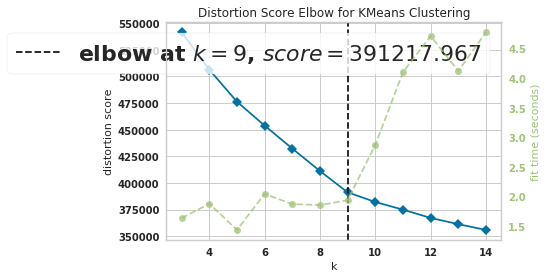

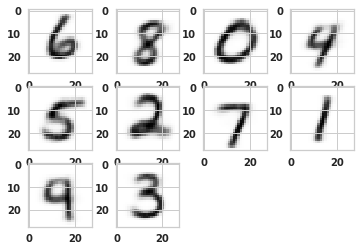

In [67]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [68]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6,8,0,4,
                                           5,2,7,1,
                                           9,3
                                          ]
manual_annotation_json["manual_confidence"] = [1,1,1,0.8,
                                               1,1,1,1,
                                               0.9,0.9
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    


Getting manual_annotation


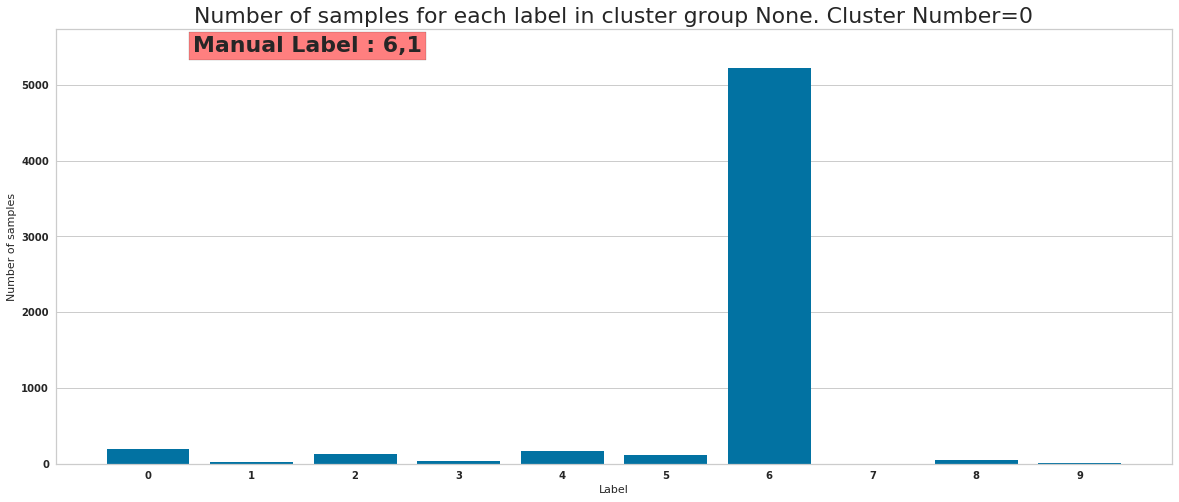

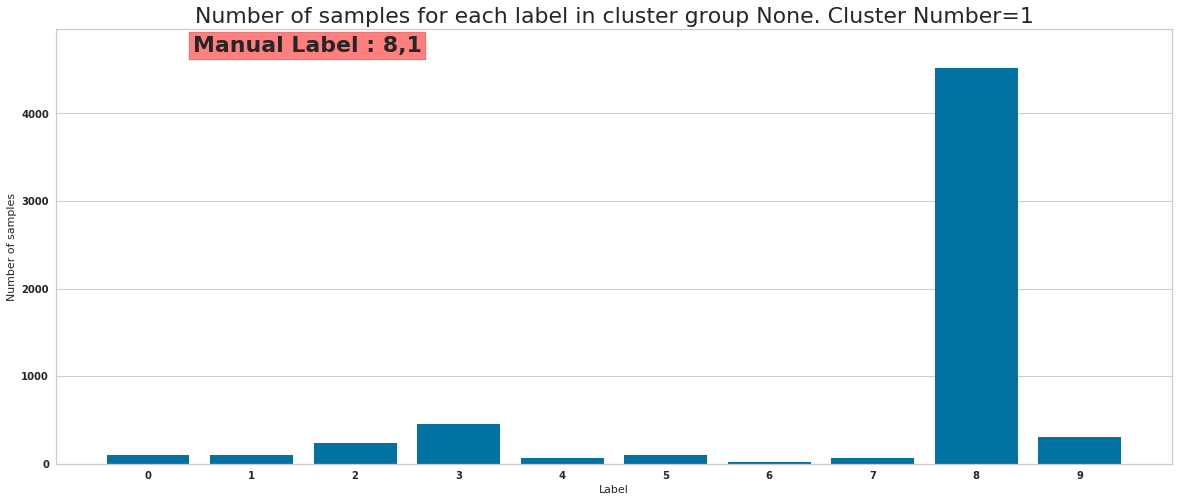

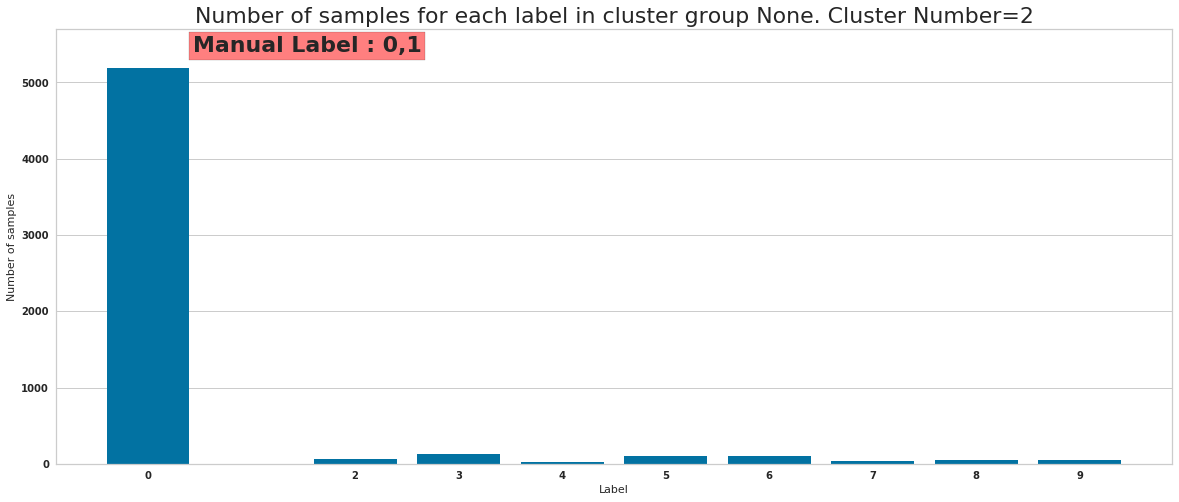

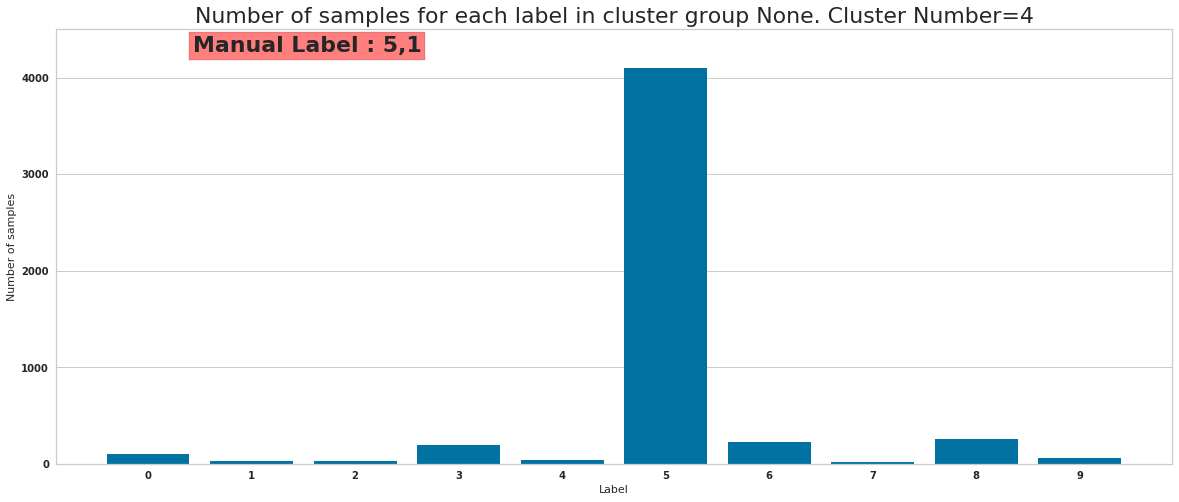

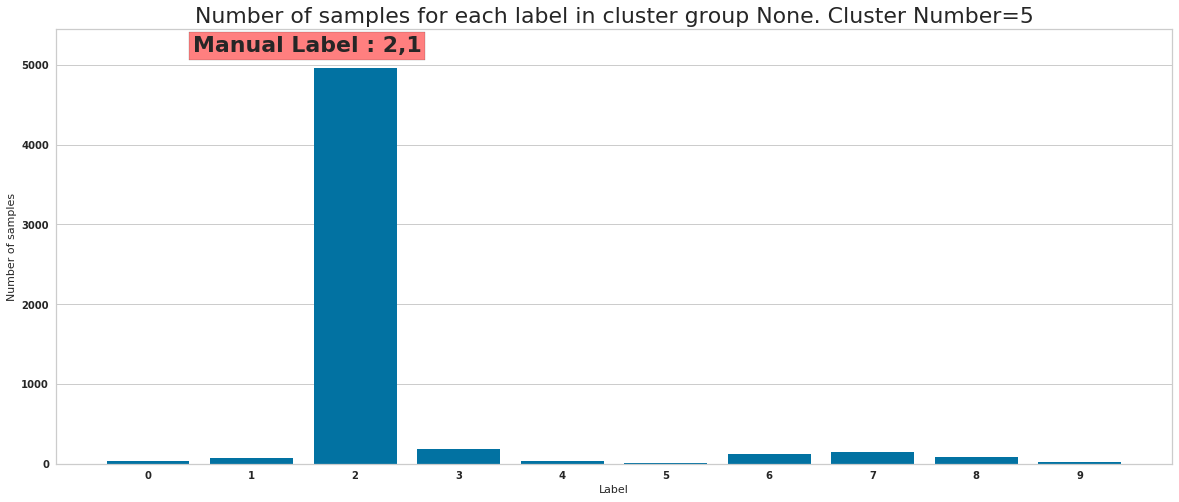

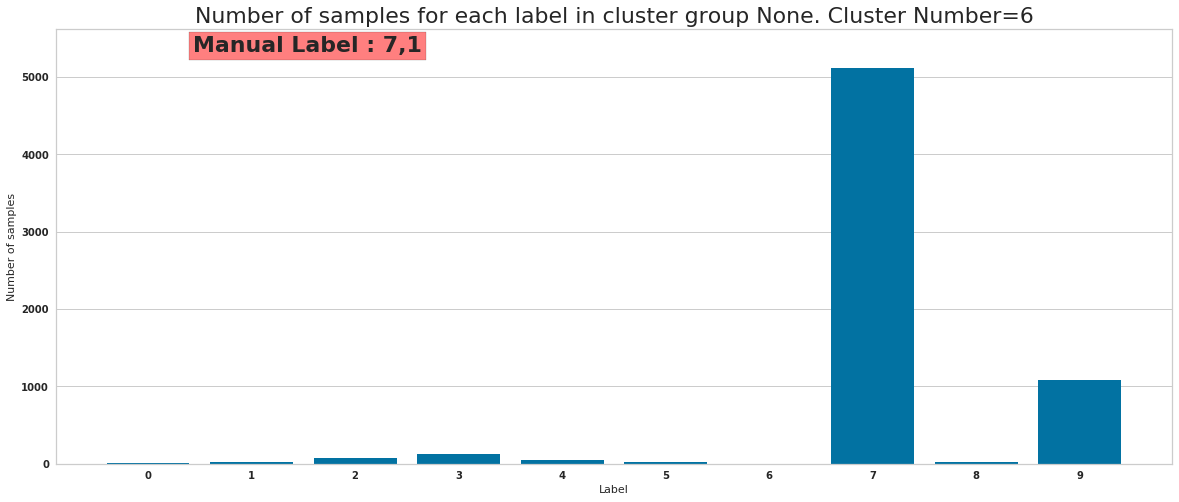

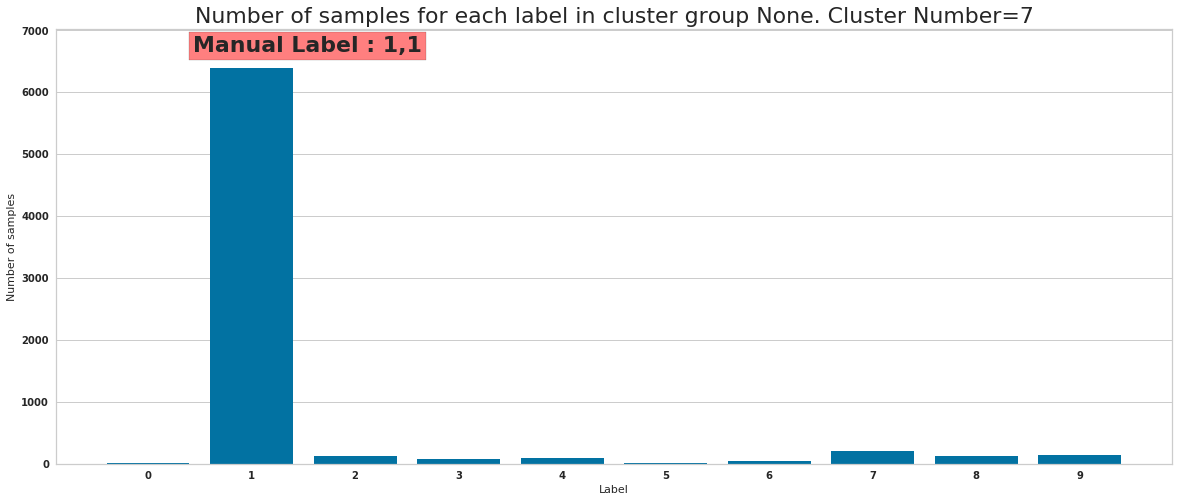

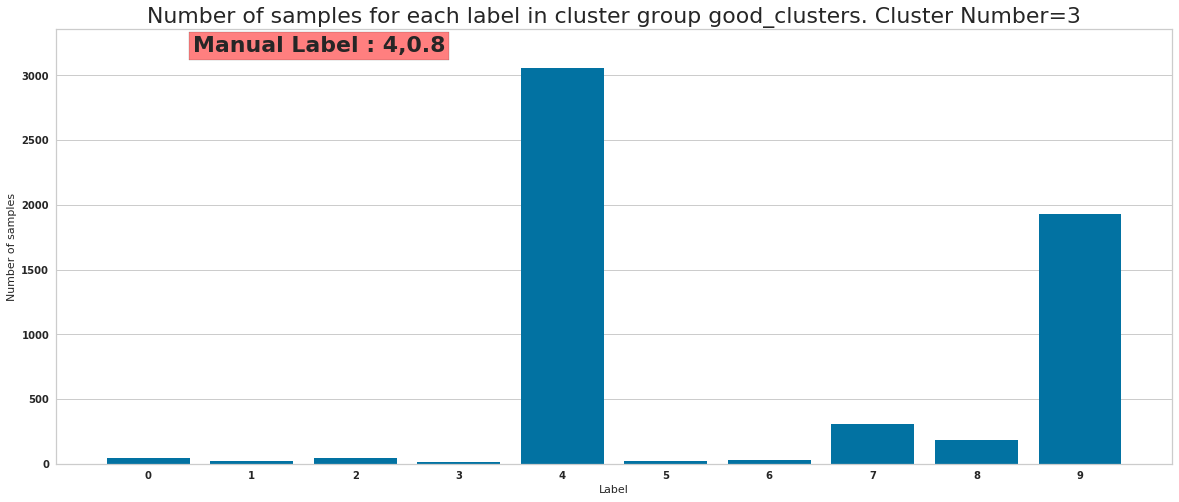

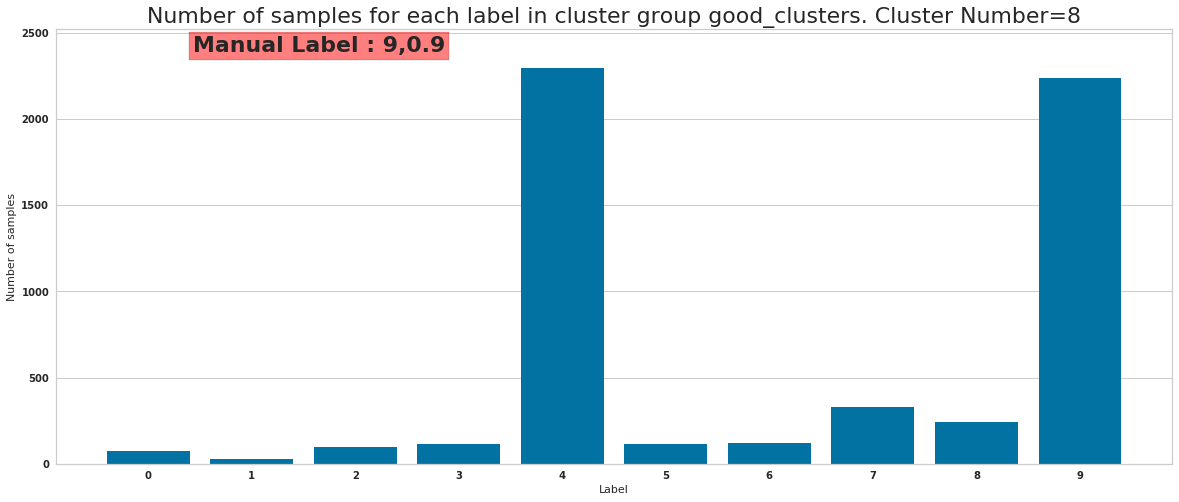

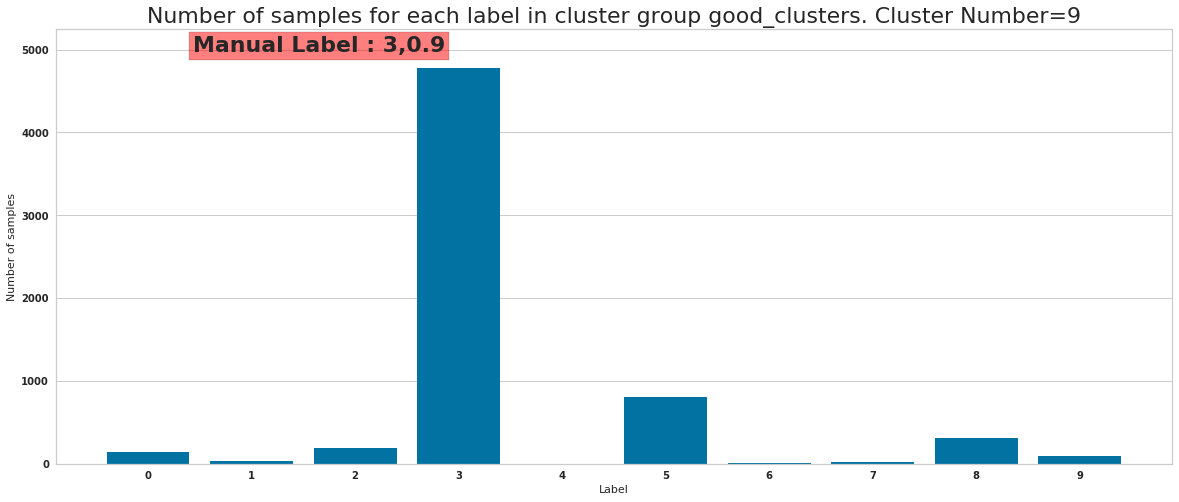

In [69]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [70]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(5962, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5976, 10)
(5748, 10)
(5645, 10)
(5031, 10)
(5664, 10)
(6526, 10)
(7239, 10)
(5650, 10)
(6399, 10)


In [71]:
# level2_manual_annotations =dict()

# #TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4,-1,-1,7,
#                                          4,4,9,-1,
#                                          -1,9
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.7,0,0,0.6,
#                                              0.8,0.8,0.9,0,
#                                              0,0.9]
# level2_manual_annotations[1] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [1,-1,-1,5,
#                                         1,1,8,-1,
#                                         -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [1,0,0,0.7,
#                                              1,1,0.8,0,
#                                              0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [72]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 6
(5962, 47) (5962, 33)
Num correct=5216
Cluster 0 Manual Label 6 Percentage correct 87.48742032874874
********************************
Manual Label 8
(5976, 47) (5976, 33)
Num correct=4511
Cluster 1 Manual Label 8 Percentage correct 75.48527443105756
********************************
Manual Label 0
(5748, 47) (5748, 33)
Num correct=5182
Cluster 2 Manual Label 0 Percentage correct 90.15309672929715
********************************
Manual Label 4
(5645, 47) (5645, 33)
Num correct=3053
Cluster 3 Manual Label 4 Percentage correct 54.08325952170062
********************************
Manual Label 5
(5031, 47) (5031, 33)
Num correct=4094
Cluster 4 Manual Label 5 Percentage correct 81.3754720731465
********************************
Manual Label 2
(5664, 47) (5664, 33)
Num correct=4955
Cluster 5 Manual Label 2 Percentage correct 87.48234463276836
********************************
Manual Label 7
(6526, 47) (6526, 33)
Num correct=5109
Cluster 6 Manual Label 7 Percentage correct 78.286852

In [73]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

In [74]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

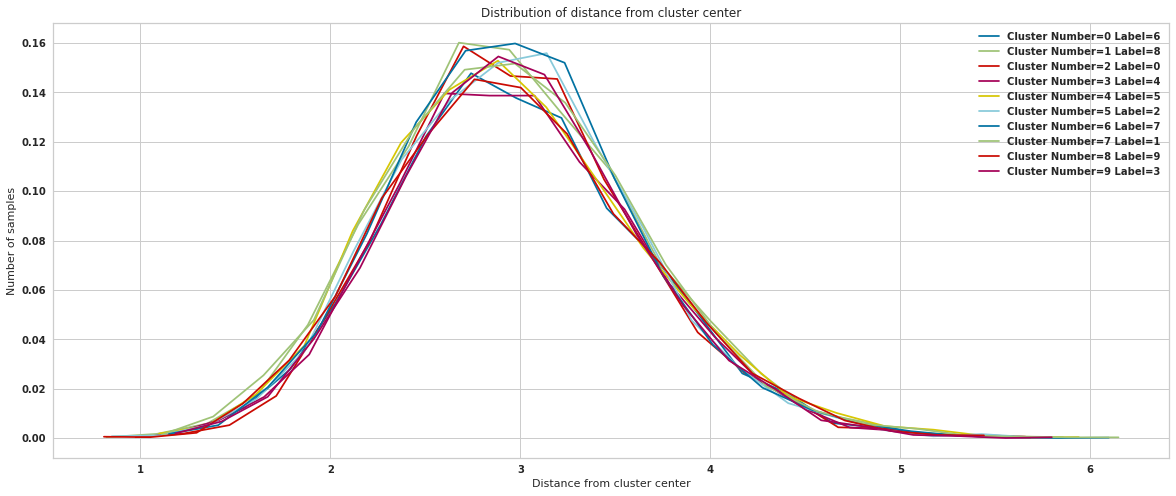

In [75]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

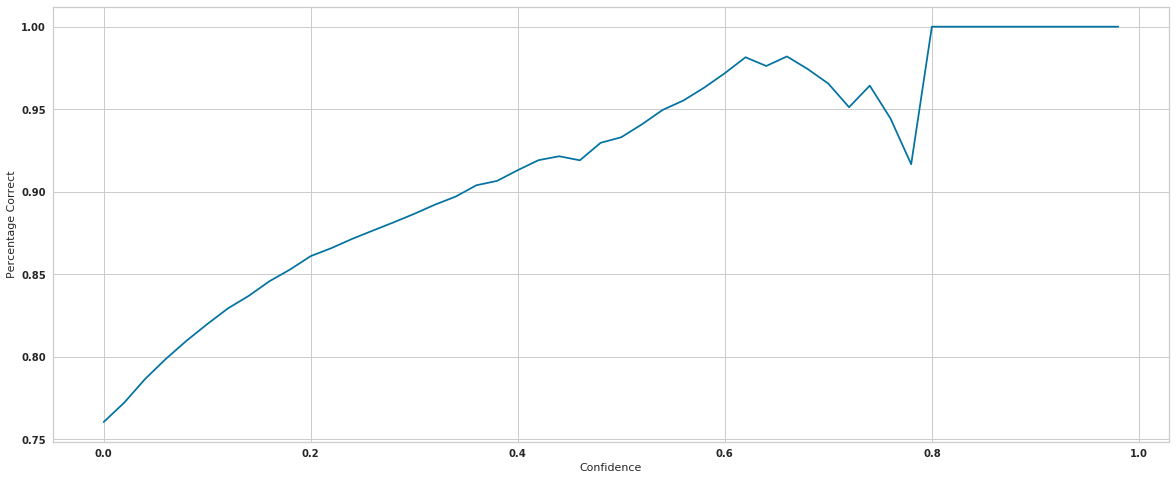

In [76]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

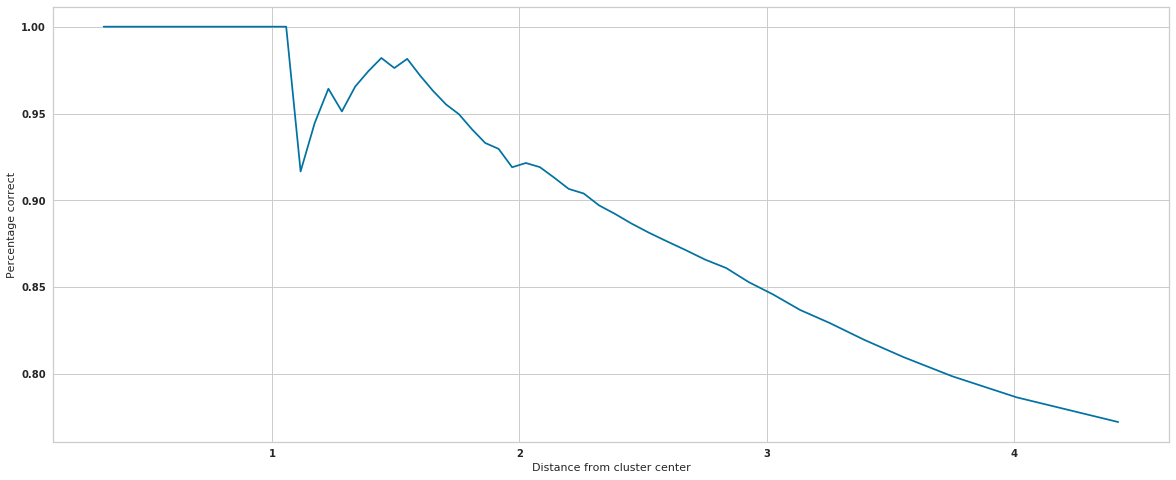

In [77]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

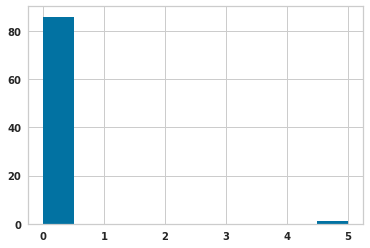

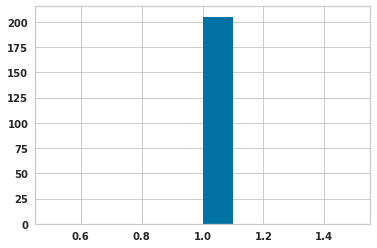

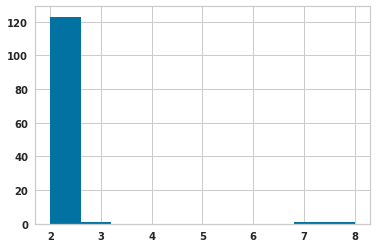

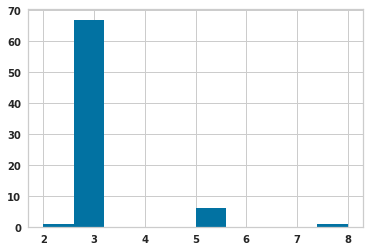

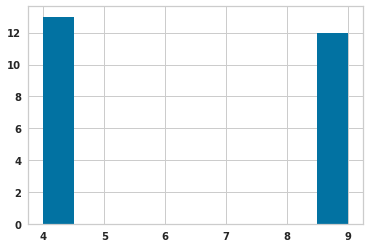

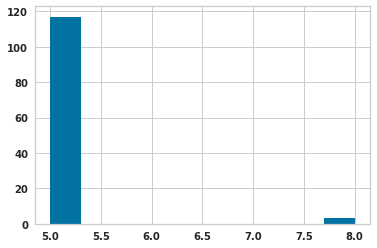

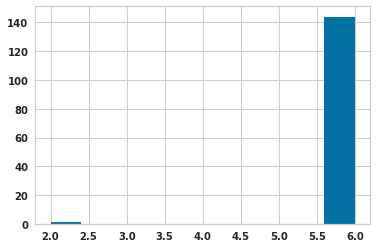

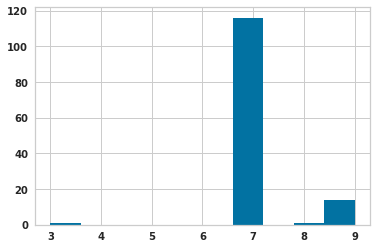

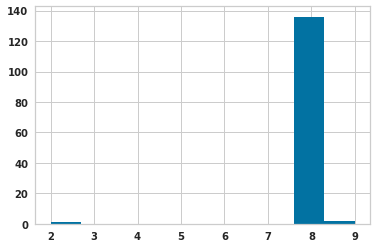

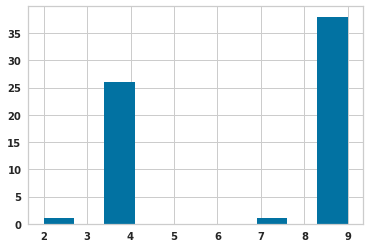

In [78]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 4

In [79]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k5'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 10402.234111360858
INFO:tensorflow:Summary name Negative Log Likel

Epoch: 3/64, Nll_loss : 117.5206298828125 KLD:8.629318237304688  Supervised loss:0.09583112597465515
Epoch: 3/65, Nll_loss : 123.58438110351562 KLD:8.880298614501953  Supervised loss:0.0920611172914505
Epoch: 3/66, Nll_loss : 111.7796401977539 KLD:8.101350784301758  Supervised loss:0.11377395689487457
Epoch: 3/67, Nll_loss : 114.43840789794922 KLD:7.885721206665039  Supervised loss:0.10416553914546967
Epoch: 3/68, Nll_loss : 121.8281478881836 KLD:8.238189697265625  Supervised loss:0.10058706998825073
Epoch: 3/69, Nll_loss : 127.05714416503906 KLD:8.229767799377441  Supervised loss:0.09899026155471802
Epoch: 3/70, Nll_loss : 118.12031555175781 KLD:8.336526870727539  Supervised loss:0.1010989248752594
Epoch: 3/71, Nll_loss : 117.82489776611328 KLD:8.313594818115234  Supervised loss:0.12420479953289032
Epoch: 3/72, Nll_loss : 120.4196548461914 KLD:8.499095916748047  Supervised loss:0.0902358666062355
Epoch: 3/73, Nll_loss : 117.29254150390625 KLD:8.497817993164062  Supervised loss:0.11979

Epoch: 3/146, Nll_loss : 115.43717193603516 KLD:8.529060363769531  Supervised loss:0.07223478704690933
Epoch: 3/147, Nll_loss : 122.67431640625 KLD:8.570640563964844  Supervised loss:0.08429829776287079
Epoch: 3/148, Nll_loss : 131.08016967773438 KLD:8.394881248474121  Supervised loss:0.10389086604118347
Epoch: 3/149, Nll_loss : 118.18240356445312 KLD:8.342859268188477  Supervised loss:0.0931135043501854
Epoch: 3/150, Nll_loss : 122.23057556152344 KLD:8.916129112243652  Supervised loss:0.08485578000545502
Epoch: 3/151, Nll_loss : 117.6798095703125 KLD:8.616315841674805  Supervised loss:0.096969835460186
Epoch: 3/152, Nll_loss : 118.68446350097656 KLD:8.673484802246094  Supervised loss:0.12333565205335617
Epoch: 3/153, Nll_loss : 113.94061279296875 KLD:8.618203163146973  Supervised loss:0.11186627298593521
Epoch: 3/154, Nll_loss : 122.84297943115234 KLD:8.6025972366333  Supervised loss:0.129877507686615
Epoch: 3/155, Nll_loss : 125.08802795410156 KLD:8.624271392822266  Supervised loss:0

Epoch: 3/226, Nll_loss : 118.37489318847656 KLD:8.589678764343262  Supervised loss:0.08912145346403122
Epoch: 3/227, Nll_loss : 118.94347381591797 KLD:8.36605453491211  Supervised loss:0.07203012704849243
Epoch: 3/228, Nll_loss : 120.30783081054688 KLD:8.549334526062012  Supervised loss:0.10296572744846344
Epoch: 3/229, Nll_loss : 115.73088073730469 KLD:8.781688690185547  Supervised loss:0.08548088371753693
Epoch: 3/230, Nll_loss : 121.63087463378906 KLD:8.306150436401367  Supervised loss:0.09173113107681274
Epoch: 3/231, Nll_loss : 125.75623321533203 KLD:8.420308113098145  Supervised loss:0.08028137683868408
Epoch: 3/232, Nll_loss : 118.82435607910156 KLD:8.262321472167969  Supervised loss:0.06682179868221283
Epoch: 3/233, Nll_loss : 117.75018310546875 KLD:8.52684497833252  Supervised loss:0.06820186972618103
Epoch: 3/234, Nll_loss : 123.84858703613281 KLD:8.058700561523438  Supervised loss:0.08415347337722778
Epoch: 3/235, Nll_loss : 121.4931411743164 KLD:8.21255874633789  Supervised

Epoch: 3/308, Nll_loss : 127.0174331665039 KLD:8.510129928588867  Supervised loss:0.07011094689369202
Epoch: 3/309, Nll_loss : 116.86625671386719 KLD:8.036745071411133  Supervised loss:0.075642429292202
Epoch: 3/310, Nll_loss : 127.18448638916016 KLD:8.204509735107422  Supervised loss:0.12173128873109818
Epoch: 3/311, Nll_loss : 131.09176635742188 KLD:8.164896011352539  Supervised loss:0.09867256879806519
Epoch: 3/312, Nll_loss : 123.59866333007812 KLD:8.7174711227417  Supervised loss:0.07723052054643631
Epoch: 3/313, Nll_loss : 122.86634826660156 KLD:8.329376220703125  Supervised loss:0.0674661248922348
Epoch: 3/314, Nll_loss : 113.10977172851562 KLD:8.285005569458008  Supervised loss:0.07473395764827728
Epoch: 3/315, Nll_loss : 114.99192810058594 KLD:8.375934600830078  Supervised loss:0.07153671979904175
Epoch: 3/316, Nll_loss : 118.63108825683594 KLD:8.158015251159668  Supervised loss:0.1089286357164383
Epoch: 3/317, Nll_loss : 117.73567199707031 KLD:8.085926055908203  Supervised lo

Epoch: 3/388, Nll_loss : 119.9531021118164 KLD:8.221067428588867  Supervised loss:0.061705805361270905
Epoch: 3/389, Nll_loss : 118.79036712646484 KLD:8.287281036376953  Supervised loss:0.06870377063751221
Epoch: 3/390, Nll_loss : 120.28434753417969 KLD:8.690834045410156  Supervised loss:0.04388386011123657
Epoch: 3/391, Nll_loss : 113.75740814208984 KLD:8.614598274230957  Supervised loss:0.07770591229200363
Epoch: 3/392, Nll_loss : 116.65863037109375 KLD:8.933197021484375  Supervised loss:0.0578775629401207
Epoch: 3/393, Nll_loss : 119.90977478027344 KLD:9.174633026123047  Supervised loss:0.04357985407114029
Epoch: 3/394, Nll_loss : 119.14305114746094 KLD:8.830432891845703  Supervised loss:0.07079077512025833
Epoch: 3/395, Nll_loss : 118.10218811035156 KLD:8.40411376953125  Supervised loss:0.0546143539249897
Epoch: 3/396, Nll_loss : 116.1697998046875 KLD:8.651351928710938  Supervised loss:0.07605443149805069
Epoch: 3/397, Nll_loss : 115.68203735351562 KLD:7.876576900482178  Supervised

Epoch: 3/468, Nll_loss : 123.64669799804688 KLD:8.635954856872559  Supervised loss:0.0847897157073021
Epoch: 3/469, Nll_loss : 114.25245666503906 KLD:8.590097427368164  Supervised loss:0.05313574895262718
Epoch: 3/470, Nll_loss : 116.10585021972656 KLD:8.775938034057617  Supervised loss:0.05395318940281868
Epoch: 3/471, Nll_loss : 117.32159423828125 KLD:8.52426528930664  Supervised loss:0.06783206760883331
Epoch: 3/472, Nll_loss : 119.81107330322266 KLD:8.53902530670166  Supervised loss:0.08252547681331635
Epoch: 3/473, Nll_loss : 118.08195495605469 KLD:8.515705108642578  Supervised loss:0.09729550778865814
Epoch: 3/474, Nll_loss : 115.38981628417969 KLD:8.310247421264648  Supervised loss:0.07489041239023209
Epoch: 3/475, Nll_loss : 122.36685180664062 KLD:8.543724060058594  Supervised loss:0.0688108503818512
Epoch: 3/476, Nll_loss : 114.89176177978516 KLD:8.800308227539062  Supervised loss:0.05536165088415146
Epoch: 3/477, Nll_loss : 120.57592010498047 KLD:8.511014938354492  Supervised

Epoch: 3/548, Nll_loss : 113.66397857666016 KLD:8.172623634338379  Supervised loss:0.06938905268907547
Epoch: 3/549, Nll_loss : 116.25724792480469 KLD:8.134502410888672  Supervised loss:0.07608240097761154
Epoch: 3/550, Nll_loss : 116.09951782226562 KLD:8.29896354675293  Supervised loss:0.08159858733415604
Epoch: 3/551, Nll_loss : 122.8226318359375 KLD:8.425186157226562  Supervised loss:0.07291027903556824
Epoch: 3/552, Nll_loss : 108.67033386230469 KLD:8.241872787475586  Supervised loss:0.04799717664718628
Epoch: 3/553, Nll_loss : 120.74319458007812 KLD:8.68547248840332  Supervised loss:0.062051065266132355
Epoch: 3/554, Nll_loss : 121.11731719970703 KLD:8.368350982666016  Supervised loss:0.06826582551002502
Epoch: 3/555, Nll_loss : 118.87141418457031 KLD:8.841367721557617  Supervised loss:0.07590001821517944
Epoch: 3/556, Nll_loss : 126.37622833251953 KLD:8.557388305664062  Supervised loss:0.08028018474578857
Epoch: 3/557, Nll_loss : 116.10472869873047 KLD:8.541439056396484  Supervis

Epoch: 3/630, Nll_loss : 118.0458755493164 KLD:8.765753746032715  Supervised loss:0.07395701110363007
Epoch: 3/631, Nll_loss : 115.85075378417969 KLD:8.333578109741211  Supervised loss:0.0942067950963974
Epoch: 3/632, Nll_loss : 113.51940155029297 KLD:8.131892204284668  Supervised loss:0.06796927750110626
Epoch: 3/633, Nll_loss : 117.54753112792969 KLD:8.233880996704102  Supervised loss:0.09921014308929443
Epoch: 3/634, Nll_loss : 116.89888763427734 KLD:8.09686279296875  Supervised loss:0.09261953830718994
Epoch: 3/635, Nll_loss : 121.400390625 KLD:8.39920425415039  Supervised loss:0.055244944989681244
Epoch: 3/636, Nll_loss : 114.912841796875 KLD:8.51574420928955  Supervised loss:0.05945443734526634
Epoch: 3/637, Nll_loss : 113.42079162597656 KLD:8.369621276855469  Supervised loss:0.07012227922677994
Epoch: 3/638, Nll_loss : 118.36506652832031 KLD:8.520647048950195  Supervised loss:0.08936912566423416
Epoch: 3/639, Nll_loss : 123.8971939086914 KLD:9.008599281311035  Supervised loss:0.

Epoch: 3/710, Nll_loss : 119.1458740234375 KLD:8.622621536254883  Supervised loss:0.077262282371521
Epoch: 3/711, Nll_loss : 117.92549133300781 KLD:8.48992919921875  Supervised loss:0.06733793020248413
Epoch: 3/712, Nll_loss : 120.553955078125 KLD:8.683067321777344  Supervised loss:0.05776664614677429
Epoch: 3/713, Nll_loss : 119.72493743896484 KLD:8.222818374633789  Supervised loss:0.06716001033782959
Epoch: 3/714, Nll_loss : 112.29450988769531 KLD:8.63231372833252  Supervised loss:0.06195886433124542
Epoch: 3/715, Nll_loss : 117.095947265625 KLD:8.274707794189453  Supervised loss:0.07148444652557373
Epoch: 3/716, Nll_loss : 114.94610595703125 KLD:8.142982482910156  Supervised loss:0.055042773485183716
Epoch: 3/717, Nll_loss : 122.35128021240234 KLD:8.68167495727539  Supervised loss:0.07836292684078217
Epoch: 3/718, Nll_loss : 112.78971099853516 KLD:8.153635025024414  Supervised loss:0.057309046387672424
Epoch: 3/719, Nll_loss : 123.66166687011719 KLD:8.393684387207031  Supervised los

Epoch: 3/792, Nll_loss : 121.79541015625 KLD:8.547967910766602  Supervised loss:0.07588739693164825
Epoch: 3/793, Nll_loss : 113.47348022460938 KLD:8.098782539367676  Supervised loss:0.07086681574583054
Epoch: 3/794, Nll_loss : 115.1522216796875 KLD:8.794307708740234  Supervised loss:0.06310172379016876
Epoch: 3/795, Nll_loss : 115.6803970336914 KLD:8.567904472351074  Supervised loss:0.0892334133386612
Epoch: 3/796, Nll_loss : 127.42740631103516 KLD:8.807705879211426  Supervised loss:0.05740832909941673
Epoch: 3/797, Nll_loss : 117.96237182617188 KLD:8.635456085205078  Supervised loss:0.07436957955360413
Epoch: 3/798, Nll_loss : 120.47473907470703 KLD:8.379911422729492  Supervised loss:0.10240016877651215
Epoch: 3/799, Nll_loss : 123.8094482421875 KLD:8.940893173217773  Supervised loss:0.06870435923337936
Epoch: 3/800, Nll_loss : 119.533935546875 KLD:8.70693588256836  Supervised loss:0.07271590828895569
Epoch: 3/801, Nll_loss : 112.06974792480469 KLD:8.259971618652344  Supervised loss:

Epoch: 3/874, Nll_loss : 118.8372573852539 KLD:8.261114120483398  Supervised loss:0.07039988040924072
Epoch: 3/875, Nll_loss : 118.9764404296875 KLD:8.225973129272461  Supervised loss:0.06370298564434052
Epoch: 3/876, Nll_loss : 114.77945709228516 KLD:8.237552642822266  Supervised loss:0.06690408289432526
Epoch: 3/877, Nll_loss : 117.60331726074219 KLD:8.753491401672363  Supervised loss:0.04787033051252365
Epoch: 3/878, Nll_loss : 124.86341094970703 KLD:8.923791885375977  Supervised loss:0.08076663315296173
Epoch: 3/879, Nll_loss : 112.91030883789062 KLD:8.698816299438477  Supervised loss:0.06879094988107681
Epoch: 3/880, Nll_loss : 113.67634582519531 KLD:8.542179107666016  Supervised loss:0.07628750801086426
Epoch: 3/881, Nll_loss : 116.75335693359375 KLD:8.756468772888184  Supervised loss:0.06157342717051506
Epoch: 3/882, Nll_loss : 119.27915954589844 KLD:8.498228073120117  Supervised loss:0.07991558313369751
Epoch: 3/883, Nll_loss : 108.21884155273438 KLD:8.344195365905762  Supervis

In [80]:
num_cluster=10
num_clusters=10

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-3740
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k5/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-3740
 [*] Success to read SemiSupervisedClassifierMnist.model-3740
 [*] Load SUCCESS
Number of steps completed=3740
Number of epochs completed 4.0
run_id=45 z_min=-4.5231276 z_max=4.190858
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; usin

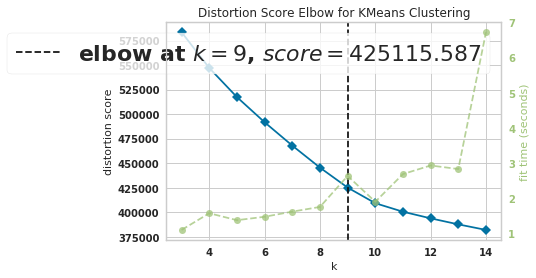

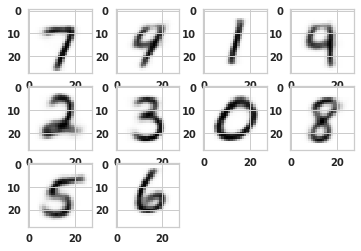

In [82]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [83]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7,4,1,9,
                                           2,3,0,8,
                                           5,6
                                          ]
manual_annotation_json["manual_confidence"] = [1,0.6,1,0.8,
                                               1,1,1,1,
                                               0.9,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    

    

Getting manual_annotation


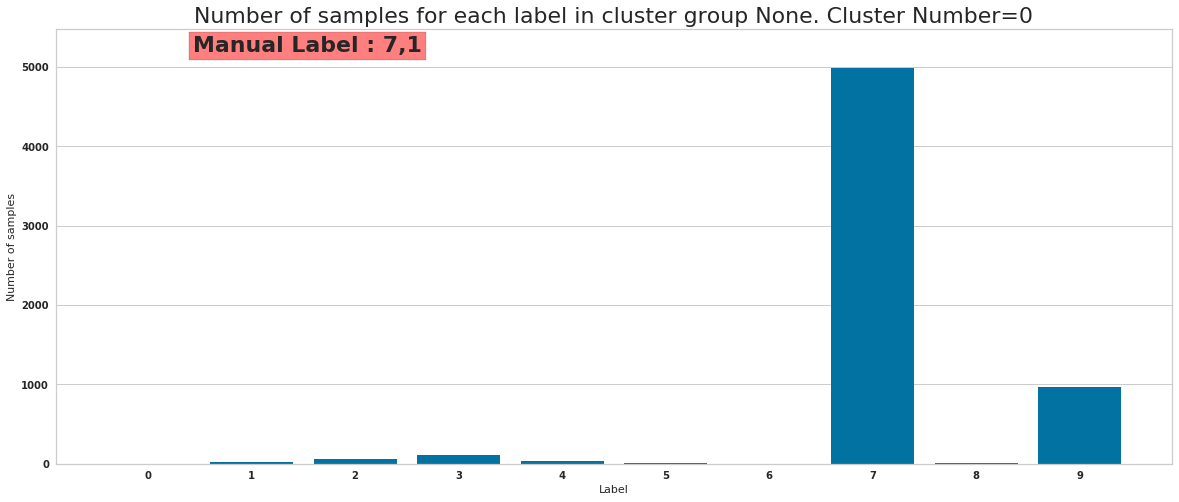

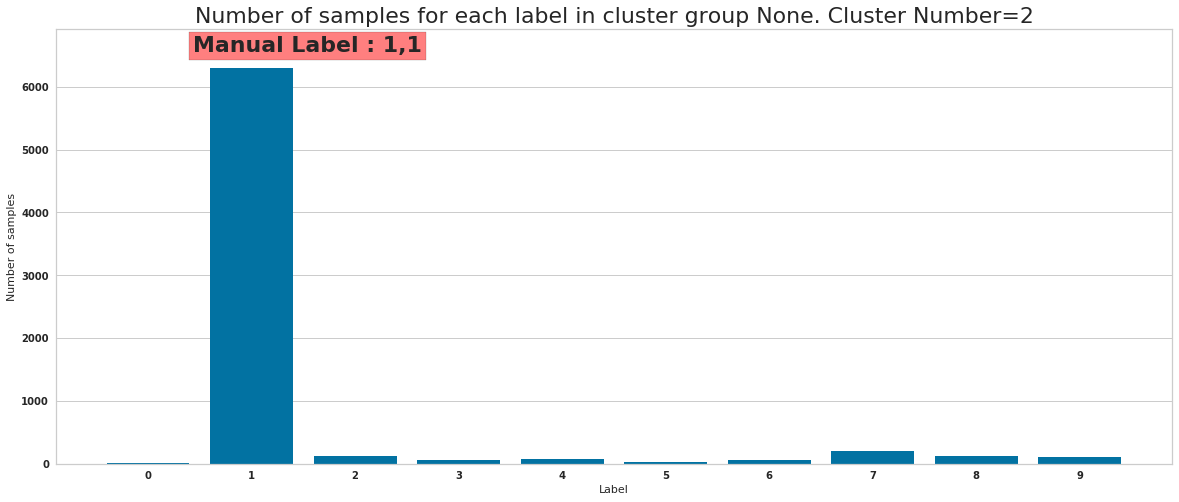

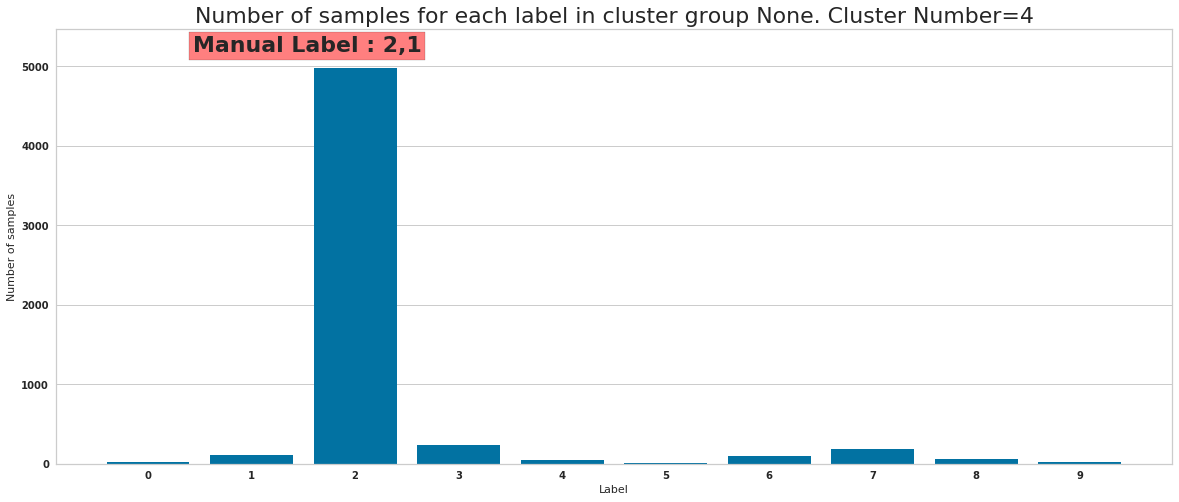

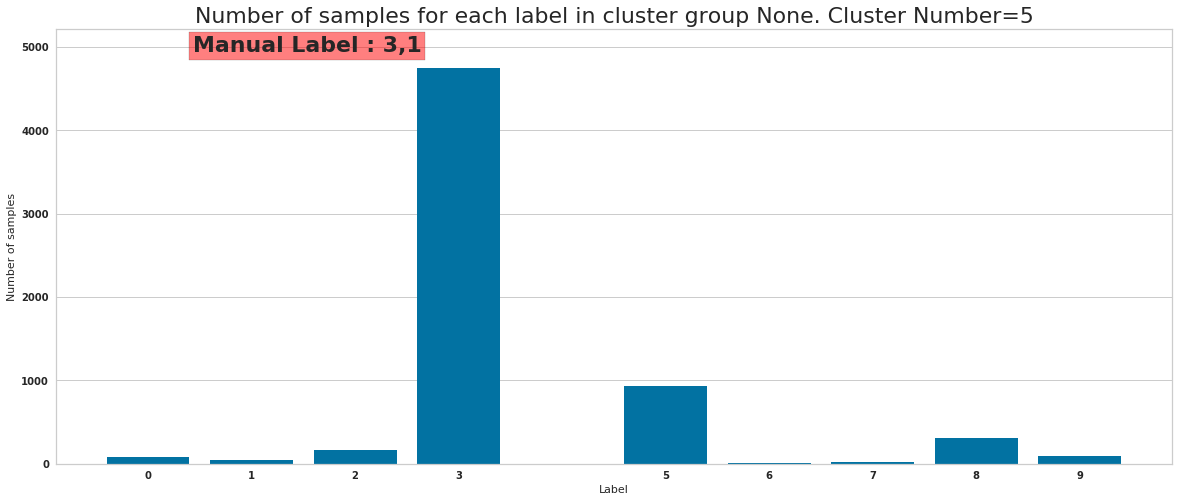

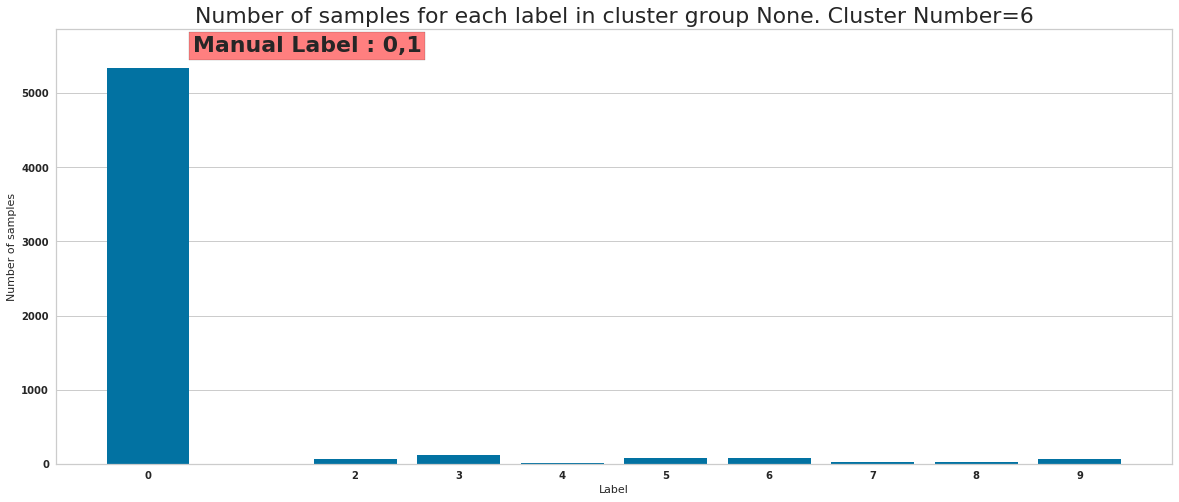

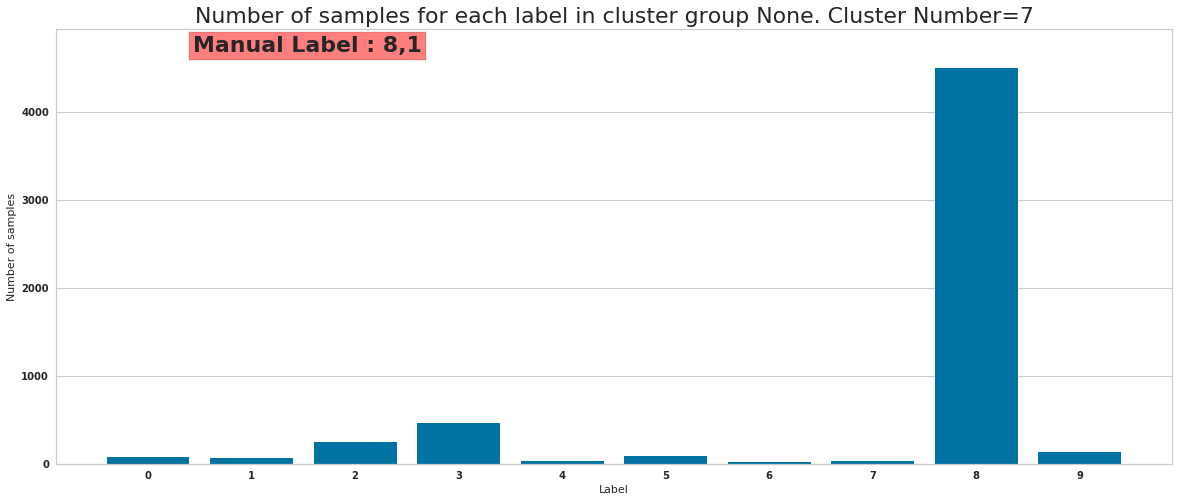

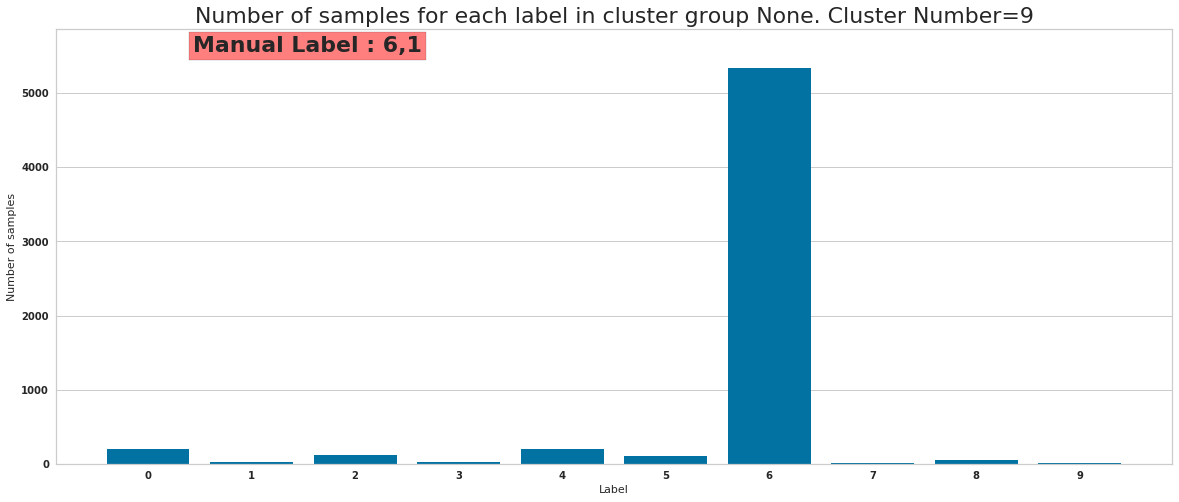

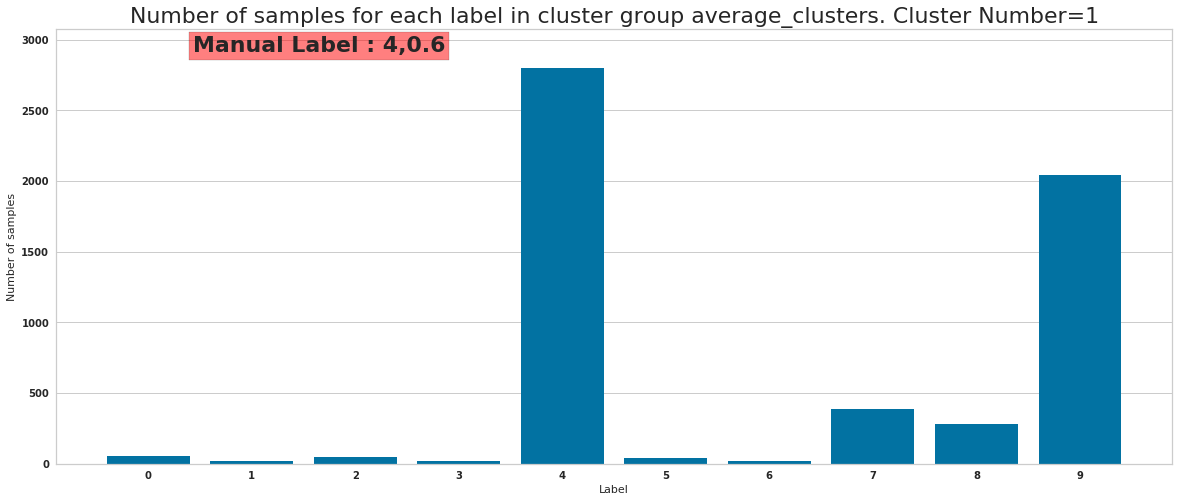

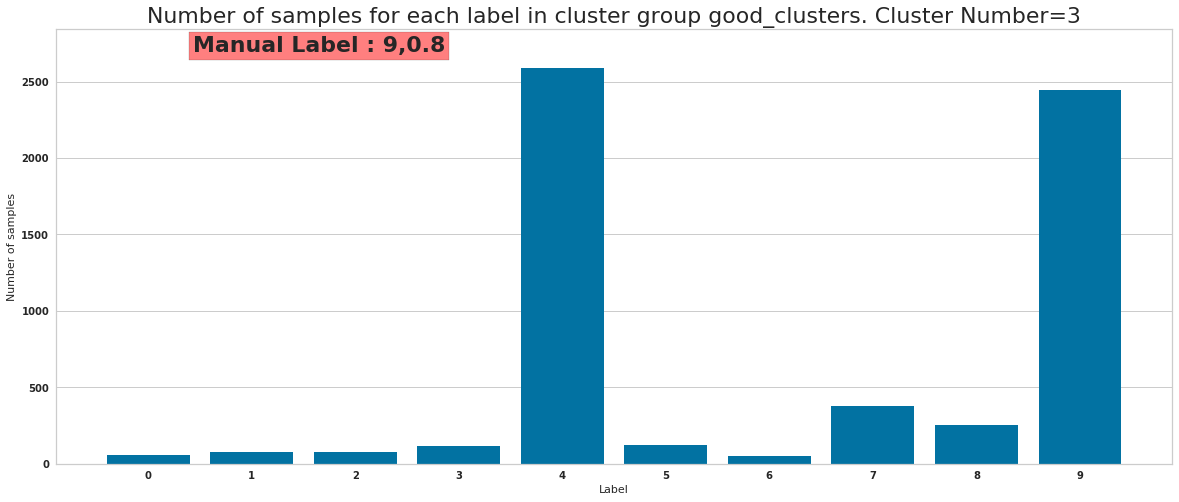

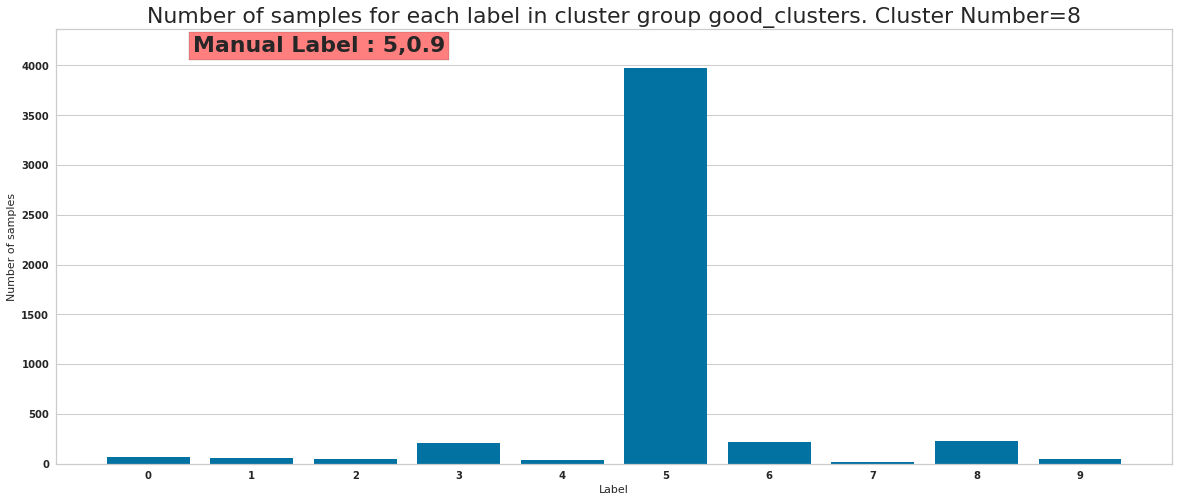

In [84]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [85]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)    
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(6221, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5713, 10)
(7087, 10)
(6173, 10)
(5760, 10)
(6407, 10)
(5822, 10)
(5666, 10)
(4903, 10)
(6088, 10)


In [91]:
# level2_manual_annotations =dict()

# #TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [5,0,-1,5,
#                                          5,8,1,5,
#                                          -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.7,0.7,0,0.7,
#                                              0.8,0.8,0.9,0.7,
#                                              0,0]
# level2_manual_annotations[0] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [3,-1,3,3,
# #                                         3,3,3,3,
# #                                         -1,3]
# # level_2_cluster_dict["manual_confidences"] = [0.9,0,0.9,0.9,
# #                                              0.9,0.9,0.9,0.9,
# #                                              0,0.9]
# # level2_manual_annotations[7] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [86]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)
    

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 7
(6221, 47) (6221, 33)
Num correct=4981
Cluster 0 Manual Label 7 Percentage correct 80.06751326153352
********************************
Manual Label 4
(5713, 47) (5713, 33)
Num correct=2796
Cluster 1 Manual Label 4 Percentage correct 48.94101172763872
********************************
Manual Label 1
(7087, 47) (7087, 33)
Num correct=6290
Cluster 2 Manual Label 1 Percentage correct 88.75405672357839
********************************
Manual Label 9
(6173, 47) (6173, 33)
Num correct=2447
Cluster 3 Manual Label 9 Percentage correct 39.64036935039689
********************************
Manual Label 2
(5760, 47) (5760, 33)
Num correct=4975
Cluster 4 Manual Label 2 Percentage correct 86.37152777777777
********************************
Manual Label 3
(6407, 47) (6407, 33)
Num correct=4742
Cluster 5 Manual Label 3 Percentage correct 74.01279850163883
********************************
Manual Label 0
(5822, 47) (5822, 33)
Num correct=5334
Cluster 6 Manual Label 0 Percentage correct 91.61800

In [87]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

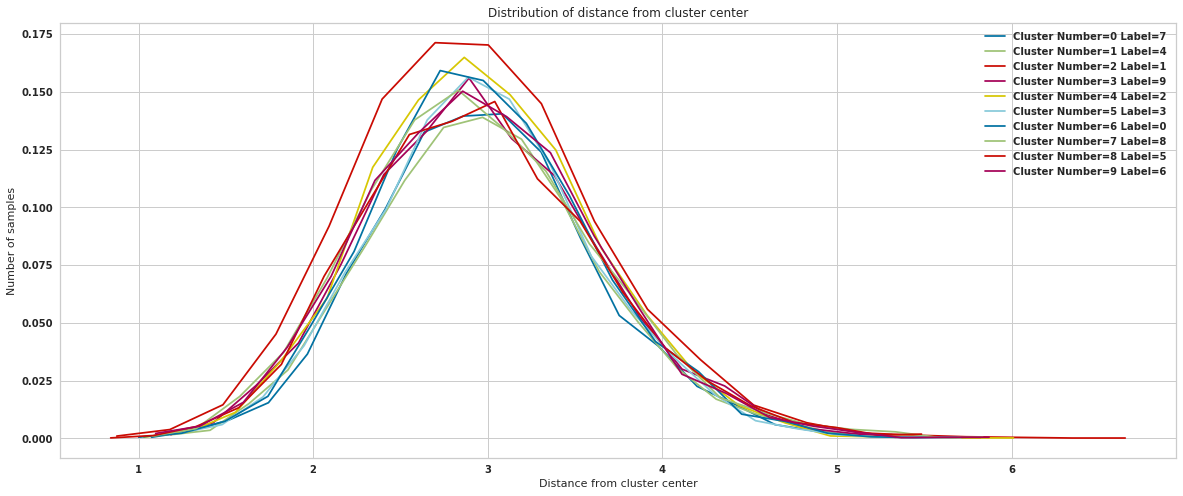

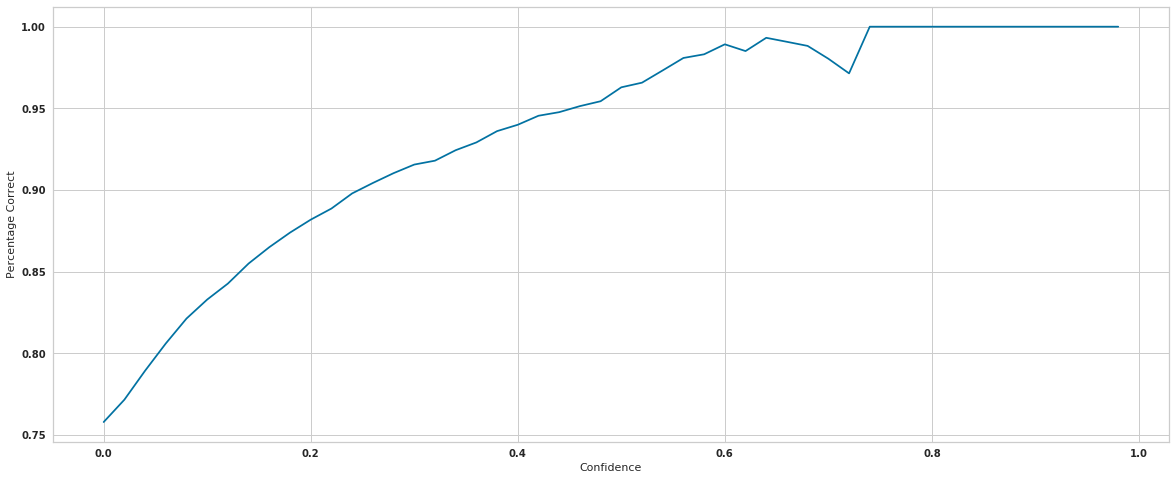

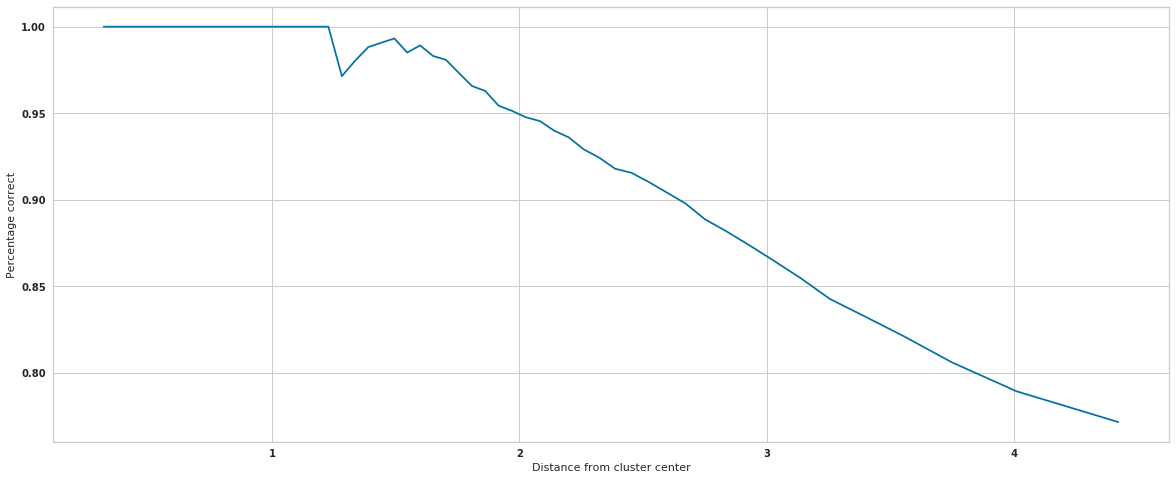

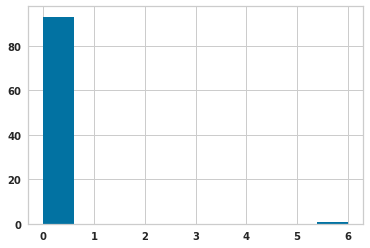

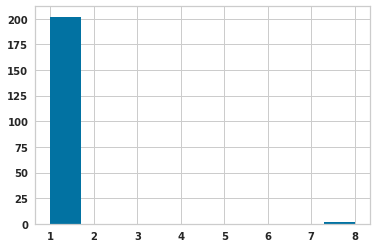

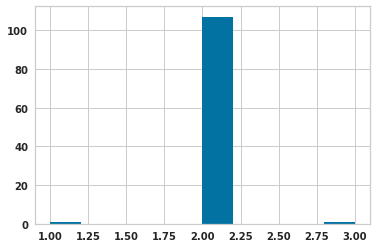

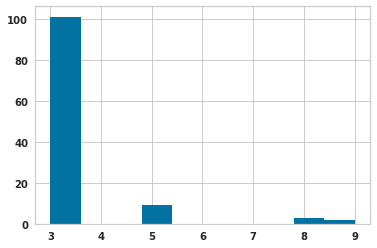

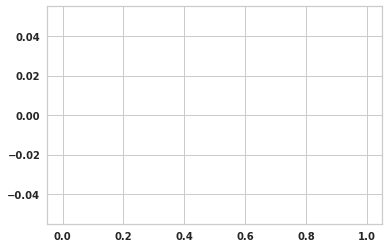

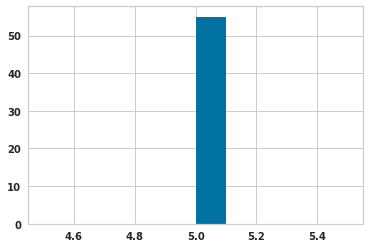

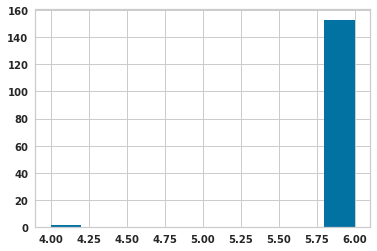

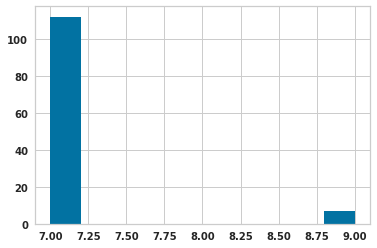

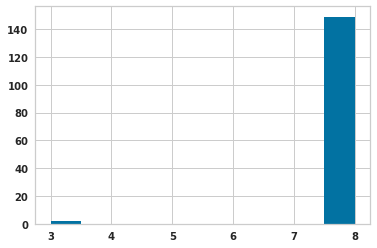

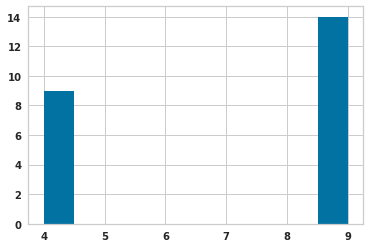

In [88]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# iteration 5

In [89]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k5'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 10072.556082921583
INFO:tensorflow:Summary name Negative Log Likel

Epoch: 4/65, Nll_loss : 121.35824584960938 KLD:9.128421783447266  Supervised loss:0.06640875339508057
Epoch: 4/66, Nll_loss : 108.8609619140625 KLD:8.346903800964355  Supervised loss:0.0517430305480957
Epoch: 4/67, Nll_loss : 111.4512710571289 KLD:8.087127685546875  Supervised loss:0.05014362186193466
Epoch: 4/68, Nll_loss : 120.86845397949219 KLD:8.444284439086914  Supervised loss:0.0442267581820488
Epoch: 4/69, Nll_loss : 125.77400970458984 KLD:8.485024452209473  Supervised loss:0.06311573088169098
Epoch: 4/70, Nll_loss : 115.71818542480469 KLD:8.403337478637695  Supervised loss:0.06706555187702179
Epoch: 4/71, Nll_loss : 118.34614562988281 KLD:8.332046508789062  Supervised loss:0.06068640947341919
Epoch: 4/72, Nll_loss : 119.0652847290039 KLD:8.318351745605469  Supervised loss:0.07332168519496918
Epoch: 4/73, Nll_loss : 118.04075622558594 KLD:8.277050018310547  Supervised loss:0.07029922306537628
Epoch: 4/74, Nll_loss : 121.54035949707031 KLD:8.625703811645508  Supervised loss:0.041

Epoch: 4/146, Nll_loss : 113.56221771240234 KLD:8.599373817443848  Supervised loss:0.03471723571419716
Epoch: 4/147, Nll_loss : 118.94505310058594 KLD:8.725455284118652  Supervised loss:0.040751002728939056
Epoch: 4/148, Nll_loss : 126.95479583740234 KLD:8.480844497680664  Supervised loss:0.0777829959988594
Epoch: 4/149, Nll_loss : 112.149169921875 KLD:8.428468704223633  Supervised loss:0.08484722673892975
Epoch: 4/150, Nll_loss : 122.25299835205078 KLD:8.874359130859375  Supervised loss:0.0719962865114212
Epoch: 4/151, Nll_loss : 112.42070770263672 KLD:8.756749153137207  Supervised loss:0.04831518977880478
Epoch: 4/152, Nll_loss : 116.43667602539062 KLD:8.873266220092773  Supervised loss:0.07372821867465973
Epoch: 4/153, Nll_loss : 111.23387145996094 KLD:8.876161575317383  Supervised loss:0.04518929496407509
Epoch: 4/154, Nll_loss : 120.00933837890625 KLD:8.886031150817871  Supervised loss:0.06419067084789276
Epoch: 4/155, Nll_loss : 121.40675354003906 KLD:8.854655265808105  Supervise

Epoch: 4/226, Nll_loss : 117.01971435546875 KLD:9.029806137084961  Supervised loss:0.049622878432273865
Epoch: 4/227, Nll_loss : 115.39834594726562 KLD:8.709436416625977  Supervised loss:0.10574030131101608
Epoch: 4/228, Nll_loss : 121.23640441894531 KLD:8.771225929260254  Supervised loss:0.07261496782302856
Epoch: 4/229, Nll_loss : 115.52259826660156 KLD:8.999590873718262  Supervised loss:0.0539846196770668
Epoch: 4/230, Nll_loss : 122.08128356933594 KLD:8.588094711303711  Supervised loss:0.05894845724105835
Epoch: 4/231, Nll_loss : 123.04167175292969 KLD:8.782894134521484  Supervised loss:0.06439043581485748
Epoch: 4/232, Nll_loss : 115.00825500488281 KLD:8.773466110229492  Supervised loss:0.04488084837794304
Epoch: 4/233, Nll_loss : 115.25628662109375 KLD:8.964103698730469  Supervised loss:0.04364161938428879
Epoch: 4/234, Nll_loss : 119.76123809814453 KLD:8.583573341369629  Supervised loss:0.064110666513443
Epoch: 4/235, Nll_loss : 118.49251556396484 KLD:8.555217742919922  Supervis

Epoch: 4/306, Nll_loss : 123.38554382324219 KLD:8.777456283569336  Supervised loss:0.060950860381126404
Epoch: 4/307, Nll_loss : 112.57325744628906 KLD:8.775615692138672  Supervised loss:0.0504201203584671
Epoch: 4/308, Nll_loss : 123.23146057128906 KLD:9.121837615966797  Supervised loss:0.06795240193605423
Epoch: 4/309, Nll_loss : 111.51142883300781 KLD:8.45378303527832  Supervised loss:0.055531375110149384
Epoch: 4/310, Nll_loss : 127.46367645263672 KLD:8.810297012329102  Supervised loss:0.0513308160007
Epoch: 4/311, Nll_loss : 125.31394958496094 KLD:8.629220962524414  Supervised loss:0.05902958661317825
Epoch: 4/312, Nll_loss : 123.73600769042969 KLD:9.06310749053955  Supervised loss:0.05113757401704788
Epoch: 4/313, Nll_loss : 120.56886291503906 KLD:8.70256519317627  Supervised loss:0.046337585896253586
Epoch: 4/314, Nll_loss : 110.36664581298828 KLD:8.704283714294434  Supervised loss:0.0443800650537014
Epoch: 4/315, Nll_loss : 111.97285461425781 KLD:8.732684135437012  Supervised l

Epoch: 4/386, Nll_loss : 120.19213104248047 KLD:8.66505241394043  Supervised loss:0.05913054198026657
Epoch: 4/387, Nll_loss : 118.00303649902344 KLD:8.14698600769043  Supervised loss:0.06369895488023758
Epoch: 4/388, Nll_loss : 118.1793441772461 KLD:8.398983001708984  Supervised loss:0.06890669465065002
Epoch: 4/389, Nll_loss : 119.40878295898438 KLD:8.293981552124023  Supervised loss:0.07161934673786163
Epoch: 4/390, Nll_loss : 119.17566680908203 KLD:8.67719841003418  Supervised loss:0.05711526423692703
Epoch: 4/391, Nll_loss : 111.45130920410156 KLD:8.481634140014648  Supervised loss:0.0606953427195549
Epoch: 4/392, Nll_loss : 117.35674285888672 KLD:8.632152557373047  Supervised loss:0.0799400731921196
Epoch: 4/393, Nll_loss : 120.57300567626953 KLD:9.109041213989258  Supervised loss:0.05149505287408829
Epoch: 4/394, Nll_loss : 116.91271209716797 KLD:8.906027793884277  Supervised loss:0.06017202138900757
Epoch: 4/395, Nll_loss : 114.21568298339844 KLD:8.694446563720703  Supervised l

Epoch: 4/467, Nll_loss : 109.67957305908203 KLD:8.526754379272461  Supervised loss:0.046975649893283844
Epoch: 4/468, Nll_loss : 119.58819580078125 KLD:8.407362937927246  Supervised loss:0.04767543822526932
Epoch: 4/469, Nll_loss : 110.94513702392578 KLD:8.287187576293945  Supervised loss:0.0399995818734169
Epoch: 4/470, Nll_loss : 112.87602233886719 KLD:8.29157829284668  Supervised loss:0.05865760147571564
Epoch: 4/471, Nll_loss : 119.48187255859375 KLD:7.956766128540039  Supervised loss:0.049863554537296295
Epoch: 4/472, Nll_loss : 122.04490661621094 KLD:8.090818405151367  Supervised loss:0.05981113016605377
Epoch: 4/473, Nll_loss : 113.7070541381836 KLD:8.199402809143066  Supervised loss:0.08466270565986633
Epoch: 4/474, Nll_loss : 115.06979370117188 KLD:8.208498001098633  Supervised loss:0.0549711249768734
Epoch: 4/475, Nll_loss : 119.5671157836914 KLD:8.529805183410645  Supervised loss:0.09311626851558685
Epoch: 4/476, Nll_loss : 115.99716186523438 KLD:8.937604904174805  Supervise

Epoch: 4/547, Nll_loss : 120.08662414550781 KLD:8.684550285339355  Supervised loss:0.06656752526760101
Epoch: 4/548, Nll_loss : 108.27989196777344 KLD:8.535242080688477  Supervised loss:0.05701014772057533
Epoch: 4/549, Nll_loss : 109.85214233398438 KLD:8.41726303100586  Supervised loss:0.060532618314027786
Epoch: 4/550, Nll_loss : 115.41363525390625 KLD:8.41617202758789  Supervised loss:0.07750187814235687
Epoch: 4/551, Nll_loss : 117.00827026367188 KLD:8.350305557250977  Supervised loss:0.05614853650331497
Epoch: 4/552, Nll_loss : 111.84168243408203 KLD:7.920334815979004  Supervised loss:0.06665561348199844
Epoch: 4/553, Nll_loss : 121.42465209960938 KLD:8.233664512634277  Supervised loss:0.046421200037002563
Epoch: 4/554, Nll_loss : 118.95457458496094 KLD:7.981154441833496  Supervised loss:0.06578873842954636
Epoch: 4/555, Nll_loss : 121.45873260498047 KLD:8.412378311157227  Supervised loss:0.06478284299373627
Epoch: 4/556, Nll_loss : 123.60986328125 KLD:8.300661087036133  Supervise

Epoch: 4/627, Nll_loss : 111.43260192871094 KLD:8.219545364379883  Supervised loss:0.059374742209911346
Epoch: 4/628, Nll_loss : 113.97880554199219 KLD:8.447824478149414  Supervised loss:0.0627068504691124
Epoch: 4/629, Nll_loss : 117.86194610595703 KLD:8.265811920166016  Supervised loss:0.06513851881027222
Epoch: 4/630, Nll_loss : 118.48690032958984 KLD:8.404035568237305  Supervised loss:0.04405951499938965
Epoch: 4/631, Nll_loss : 113.10069274902344 KLD:8.143980026245117  Supervised loss:0.06277699023485184
Epoch: 4/632, Nll_loss : 113.87779235839844 KLD:7.909114360809326  Supervised loss:0.045863281935453415
Epoch: 4/633, Nll_loss : 115.34365844726562 KLD:8.045275688171387  Supervised loss:0.05073540285229683
Epoch: 4/634, Nll_loss : 118.1994400024414 KLD:8.033159255981445  Supervised loss:0.05528441071510315
Epoch: 4/635, Nll_loss : 117.6152114868164 KLD:8.309465408325195  Supervised loss:0.05120034143328667
Epoch: 4/636, Nll_loss : 117.0423355102539 KLD:8.41387939453125  Supervise

Epoch: 4/708, Nll_loss : 107.63761138916016 KLD:8.129390716552734  Supervised loss:0.05644931644201279
Epoch: 4/709, Nll_loss : 116.14595031738281 KLD:8.8726806640625  Supervised loss:0.06341755390167236
Epoch: 4/710, Nll_loss : 115.66283416748047 KLD:8.697636604309082  Supervised loss:0.06146194785833359
Epoch: 4/711, Nll_loss : 119.47325134277344 KLD:8.610555648803711  Supervised loss:0.04135887324810028
Epoch: 4/712, Nll_loss : 118.07341003417969 KLD:8.849472045898438  Supervised loss:0.05272260308265686
Epoch: 4/713, Nll_loss : 117.37398529052734 KLD:8.478431701660156  Supervised loss:0.07708410918712616
Epoch: 4/714, Nll_loss : 114.06131744384766 KLD:8.799516677856445  Supervised loss:0.03463633358478546
Epoch: 4/715, Nll_loss : 112.87882995605469 KLD:8.50217056274414  Supervised loss:0.0400916263461113
Epoch: 4/716, Nll_loss : 114.04954528808594 KLD:8.431145668029785  Supervised loss:0.047798383980989456
Epoch: 4/717, Nll_loss : 120.5923080444336 KLD:9.076105117797852  Supervised

Epoch: 4/788, Nll_loss : 124.03845977783203 KLD:8.336759567260742  Supervised loss:0.0521395280957222
Epoch: 4/789, Nll_loss : 120.03144073486328 KLD:8.538541793823242  Supervised loss:0.05223805829882622
Epoch: 4/790, Nll_loss : 120.1186294555664 KLD:8.475162506103516  Supervised loss:0.06114623695611954
Epoch: 4/791, Nll_loss : 111.07421875 KLD:8.518455505371094  Supervised loss:0.070651575922966
Epoch: 4/792, Nll_loss : 116.63233947753906 KLD:8.968343734741211  Supervised loss:0.042889710515737534
Epoch: 4/793, Nll_loss : 109.1651840209961 KLD:8.640203475952148  Supervised loss:0.04955190420150757
Epoch: 4/794, Nll_loss : 114.1465835571289 KLD:9.328084945678711  Supervised loss:0.03330080583691597
Epoch: 4/795, Nll_loss : 113.50531768798828 KLD:9.014976501464844  Supervised loss:0.048475444316864014
Epoch: 4/796, Nll_loss : 120.27522277832031 KLD:9.283748626708984  Supervised loss:0.04398001357913017
Epoch: 4/797, Nll_loss : 118.31317901611328 KLD:8.801655769348145  Supervised loss:

Epoch: 4/869, Nll_loss : 120.00450134277344 KLD:8.450634002685547  Supervised loss:0.06502942740917206
Epoch: 4/870, Nll_loss : 125.40487670898438 KLD:8.782081604003906  Supervised loss:0.041727833449840546
Epoch: 4/871, Nll_loss : 115.23392486572266 KLD:8.592077255249023  Supervised loss:0.054087333381175995
Epoch: 4/872, Nll_loss : 111.60292053222656 KLD:8.5188627243042  Supervised loss:0.053025953471660614
Epoch: 4/873, Nll_loss : 116.30238342285156 KLD:8.7930908203125  Supervised loss:0.07537113130092621
Epoch: 4/874, Nll_loss : 117.13648986816406 KLD:8.98393726348877  Supervised loss:0.05753523111343384
Epoch: 4/875, Nll_loss : 115.76879119873047 KLD:9.021333694458008  Supervised loss:0.04654770344495773
Epoch: 4/876, Nll_loss : 111.25505065917969 KLD:8.757061004638672  Supervised loss:0.04135771095752716
Epoch: 4/877, Nll_loss : 116.80951690673828 KLD:8.935955047607422  Supervised loss:0.046988315880298615
Epoch: 4/878, Nll_loss : 121.83627319335938 KLD:9.005911827087402  Supervi

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-4675
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k5/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-4675
 [*] Success to read SemiSupervisedClassifierMnist.model-4675
 [*] Load SUCCESS
Number of steps completed=4675
Number of epochs completed 5.0
run_id=45 z_min=-4.5142 z_max=4.139295
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K

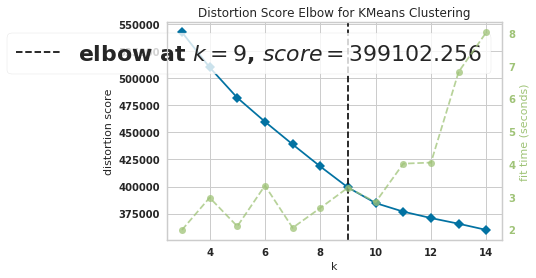

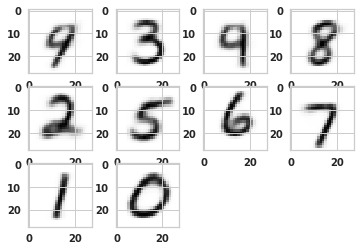

In [90]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


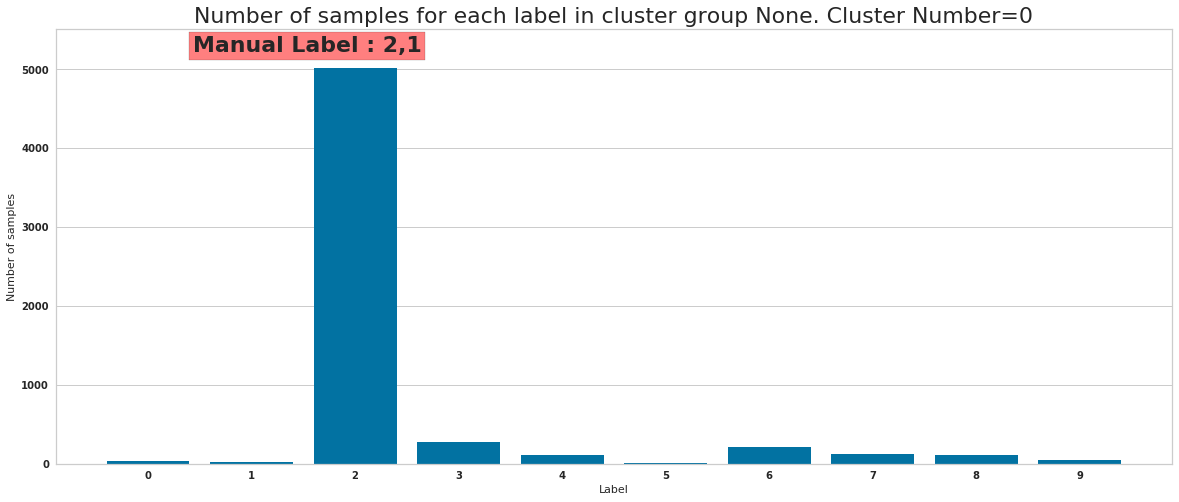

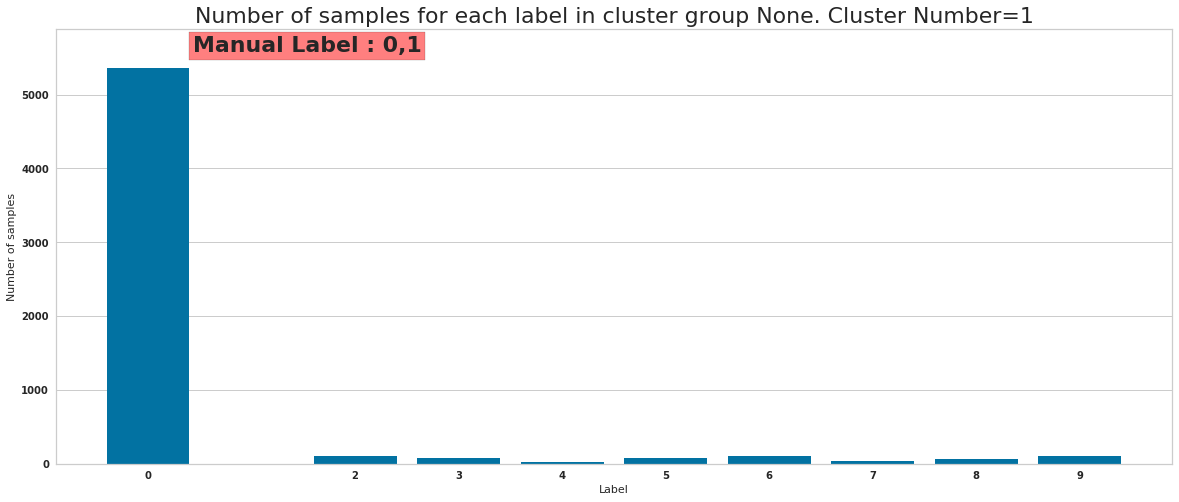

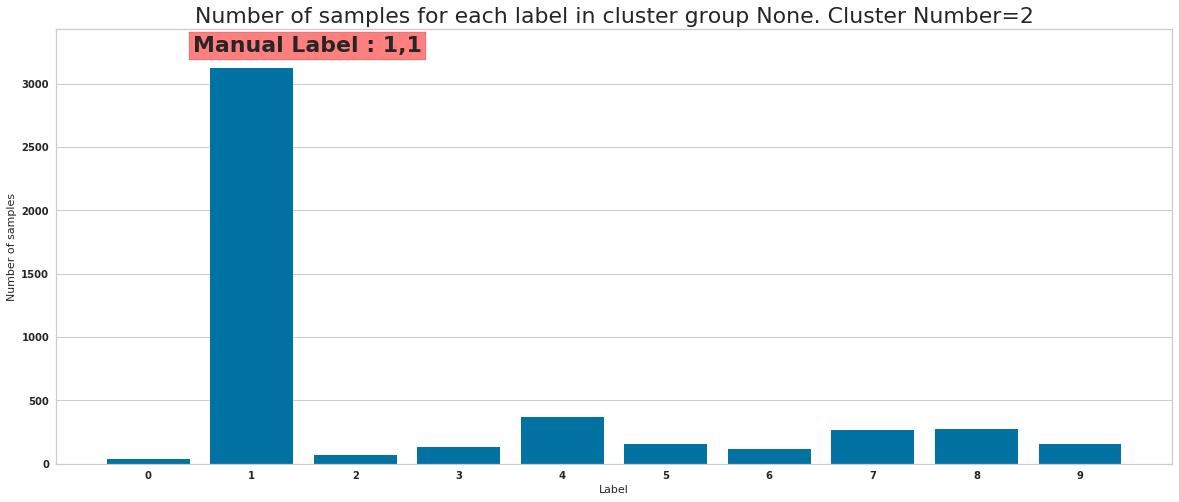

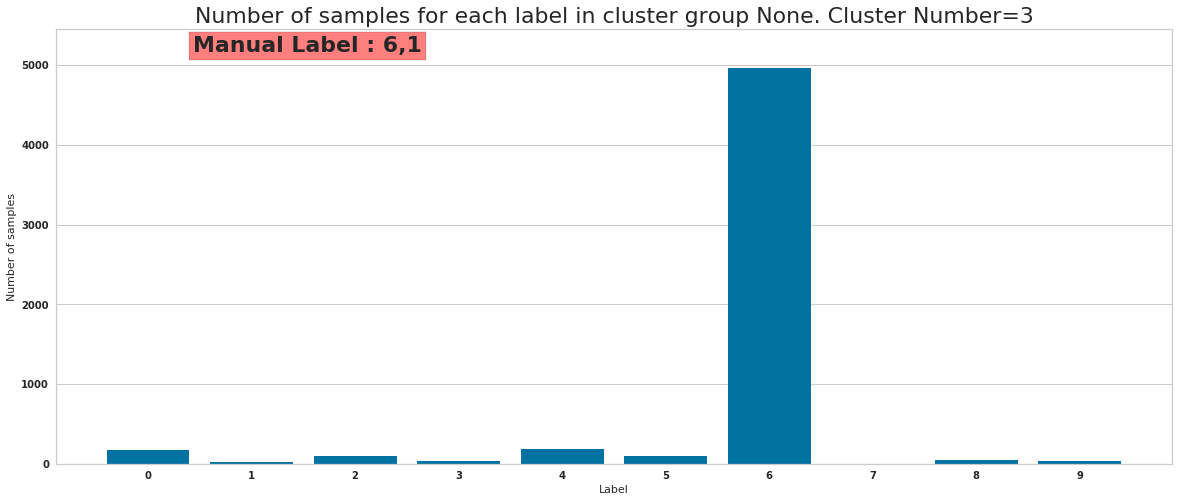

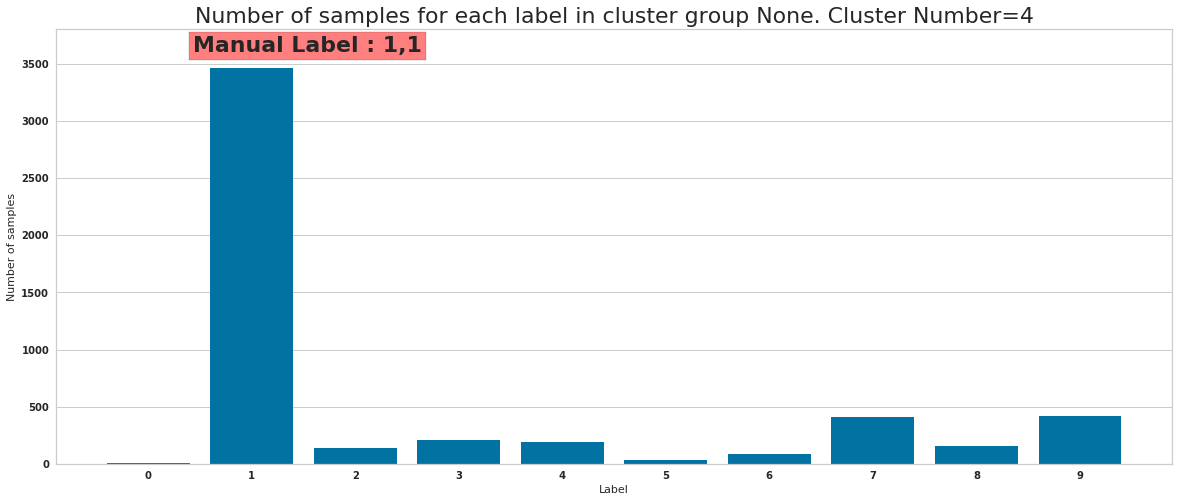

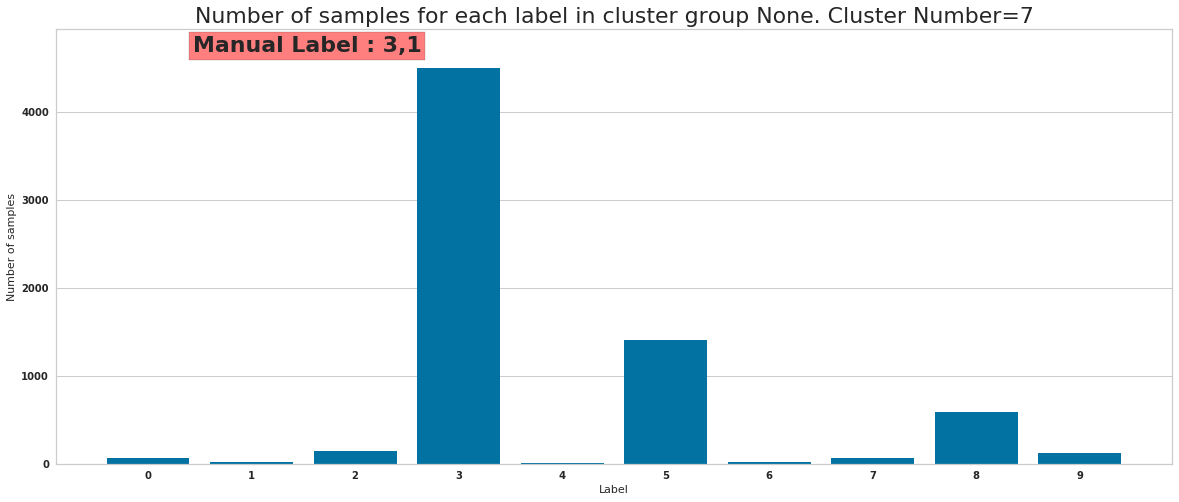

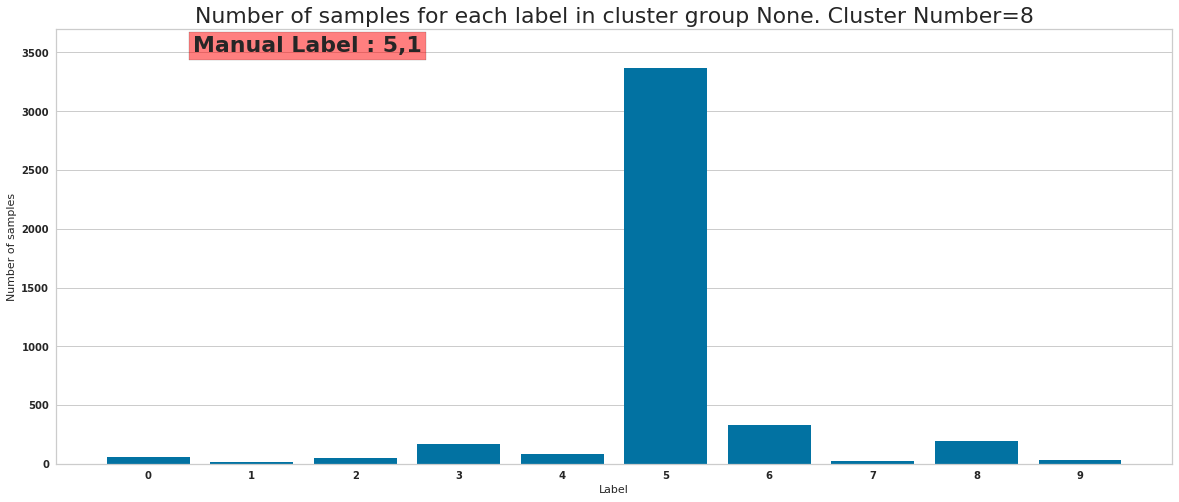

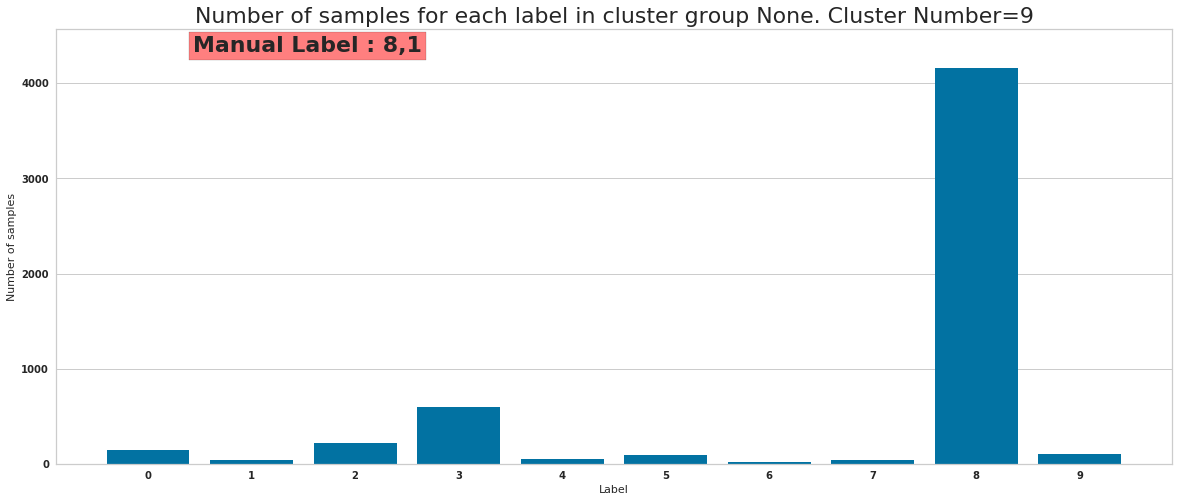

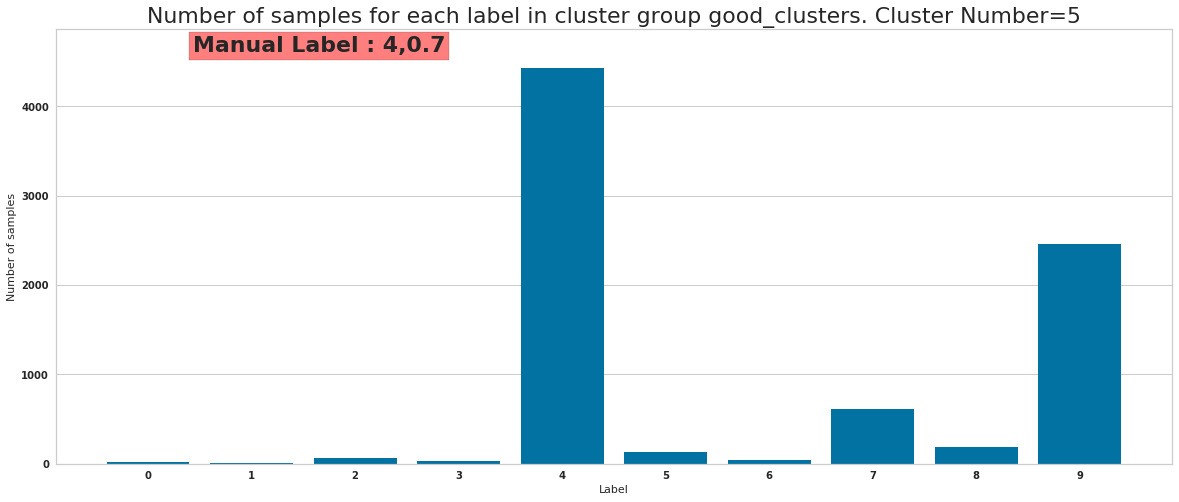

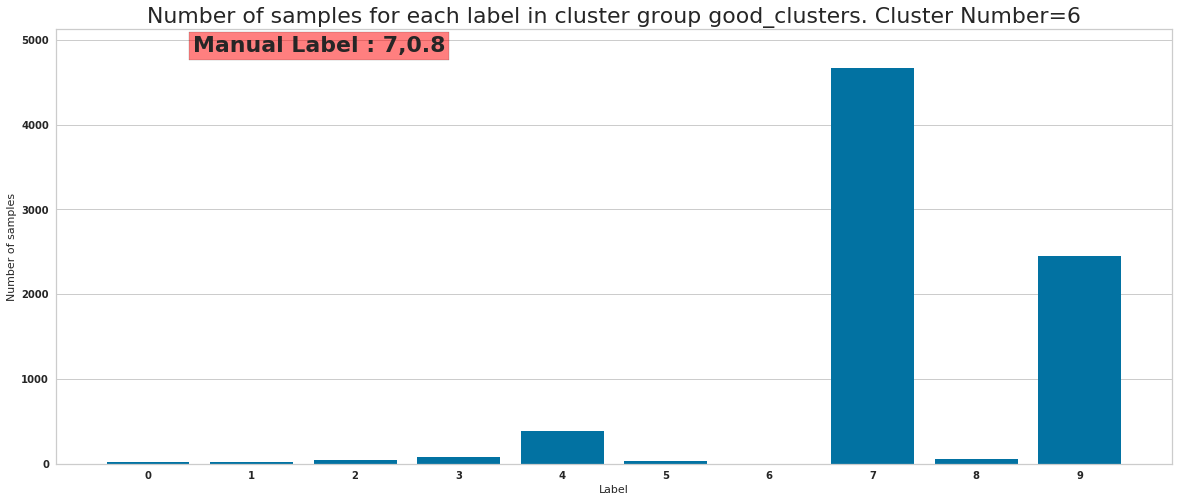

In [97]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [2,0,1,6,
                                           1,4,7,3,
                                           5,8
                                          ]
manual_annotation_json["manual_confidence"] = [1,1,1,1,
                                               1,0.7,0.8,1,
                                               1,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )



In [98]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)
    
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [96]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [97]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 2
(6259, 47) (6259, 33)
Num correct=5034
Cluster 0 Manual Label 2 Percentage correct 80.42818341588114
********************************
Manual Label 3
(6954, 47) (6954, 33)
Num correct=4243
Cluster 1 Manual Label 3 Percentage correct 61.01524302559678
********************************
Manual Label 1
(7147, 47) (7147, 33)
Num correct=6439
Cluster 2 Manual Label 1 Percentage correct 90.09374562753602
********************************
Manual Label 7
(5853, 47) (5853, 33)
Num correct=5163
Cluster 3 Manual Label 7 Percentage correct 88.21117375704767
********************************
Manual Label 5
(3966, 47) (3966, 33)
Num correct=2855
Cluster 4 Manual Label 5 Percentage correct 71.98688855269793
********************************
Manual Label 4
(6608, 47) (6608, 33)
Num correct=2669
Cluster 5 Manual Label 4 Percentage correct 40.39043583535109
********************************
Manual Label 0
(5392, 47) (5392, 33)
Num correct=4749
Cluster 6 Manual Label 0 Percentage correct 88.07492

In [98]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

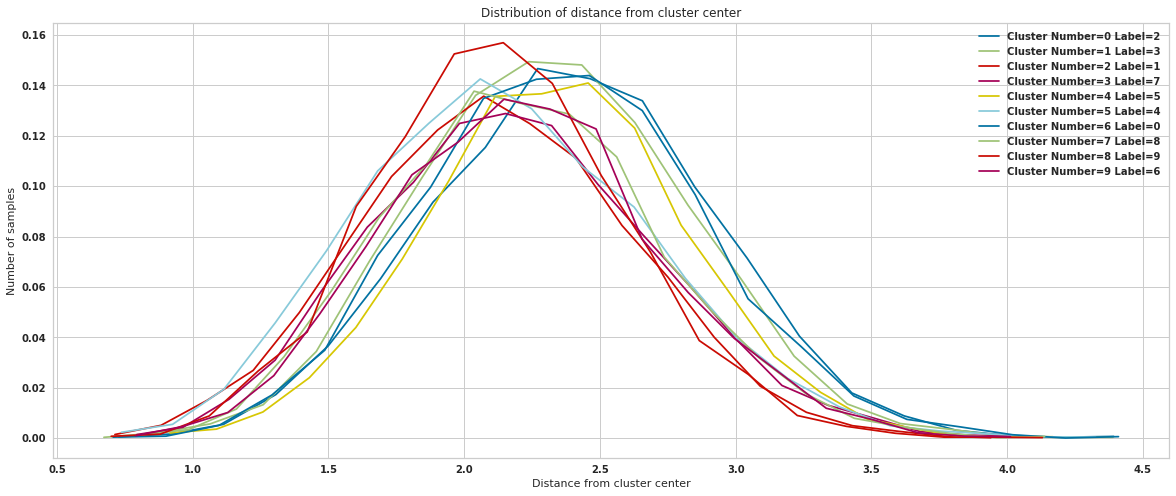

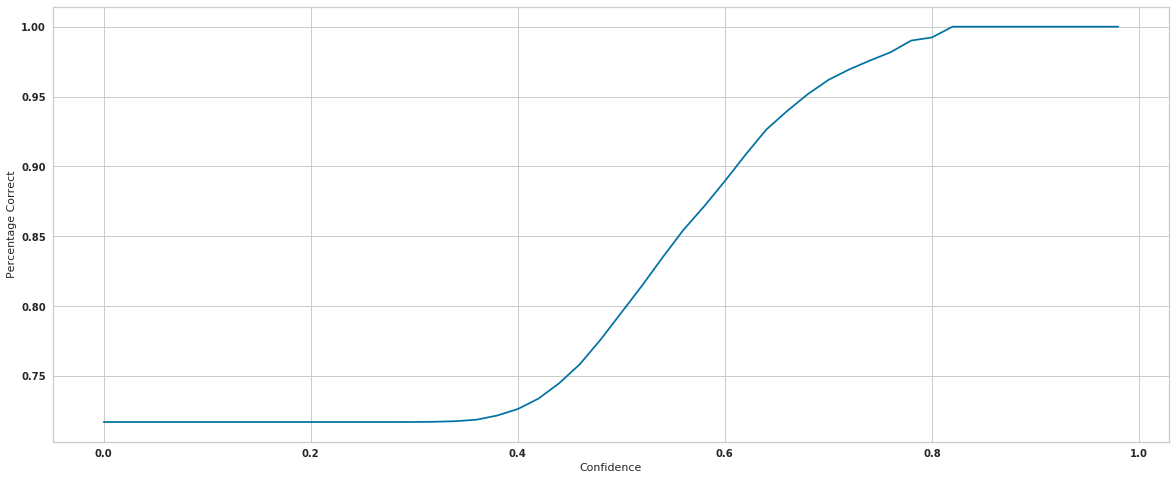

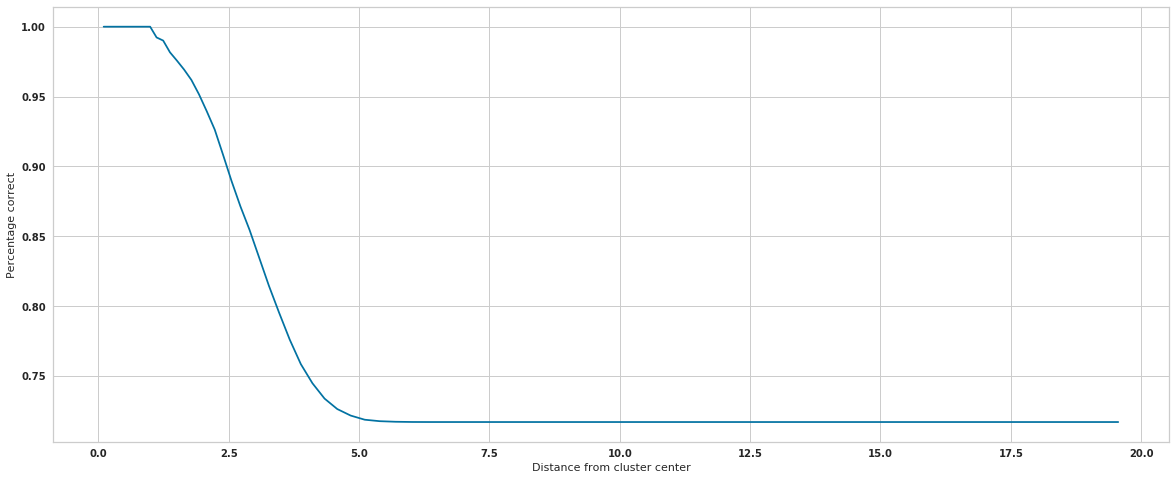

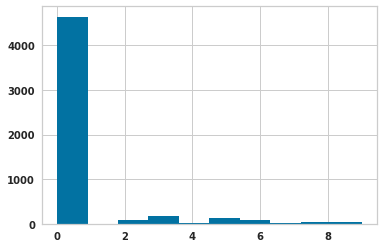

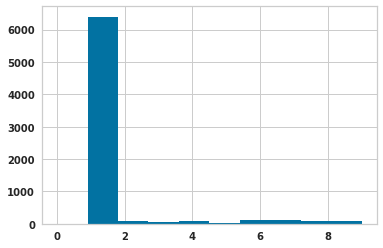

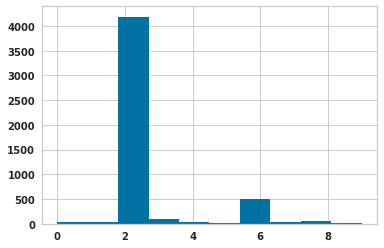

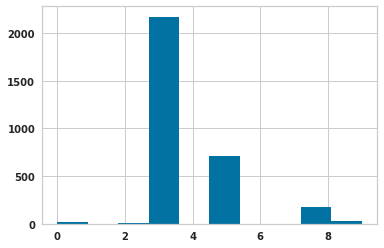

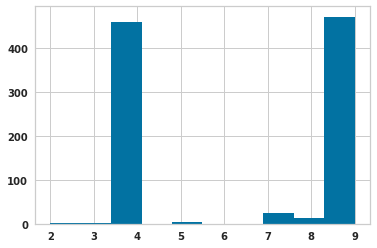

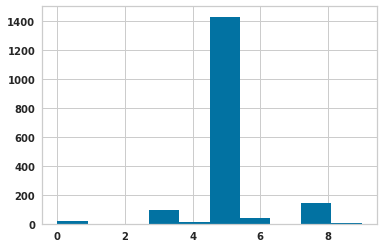

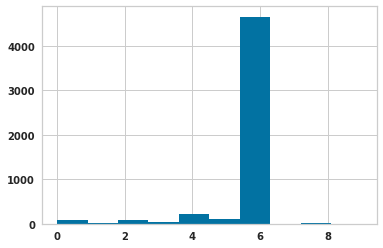

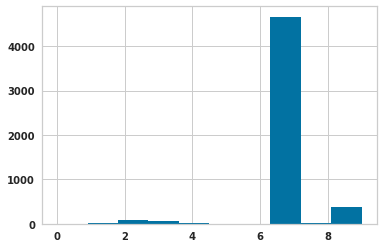

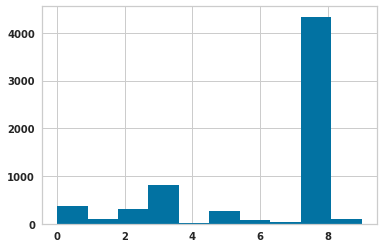

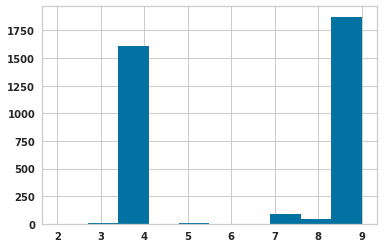

In [99]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [100]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

TypeError: initialize_model_train_and_get_features() missing 1 required positional argument: 'model_type'

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-5610
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_10/trained_models/ClassifierModel.model-5610
 [*] Success to read ClassifierModel.model-5610
 [*] Load SUCCESS
Number of steps completed=5610
Number of epochs completed 6.0
run_id=10 z_min=-5.0479445 z_max=4.711913
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instea

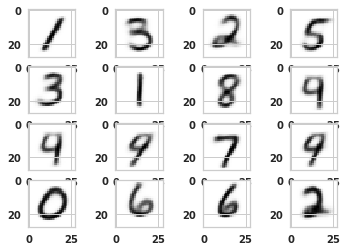

In [75]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


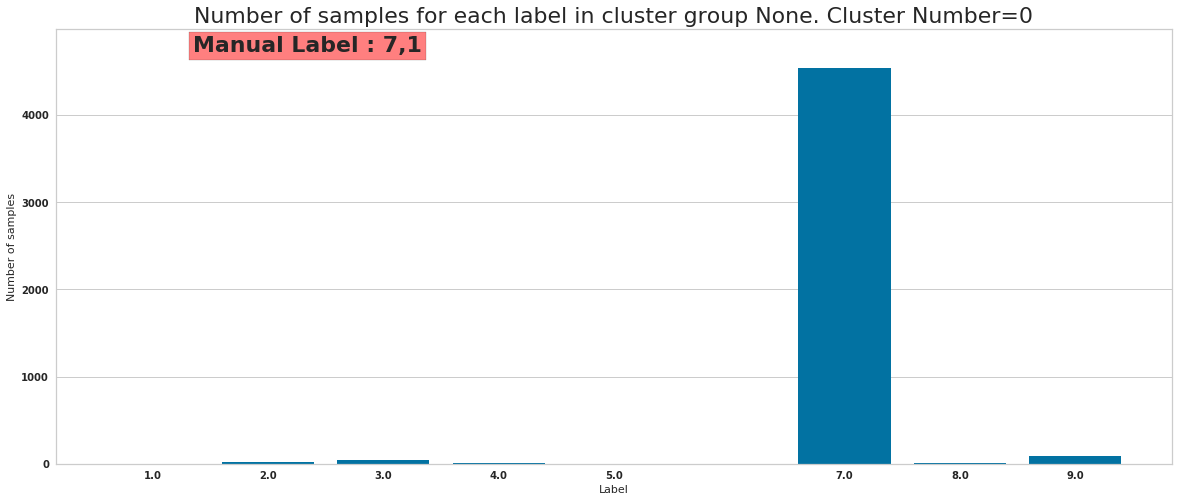

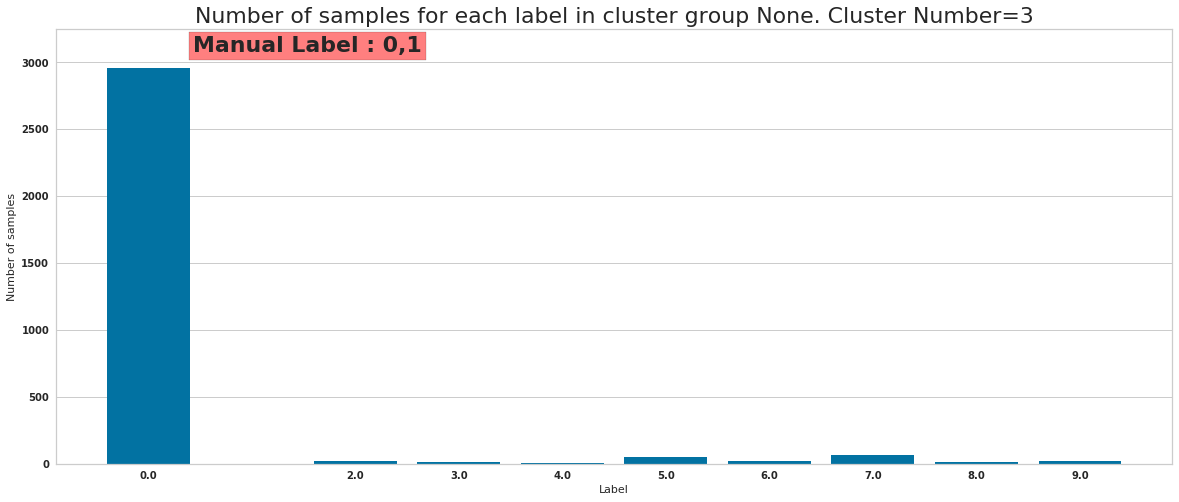

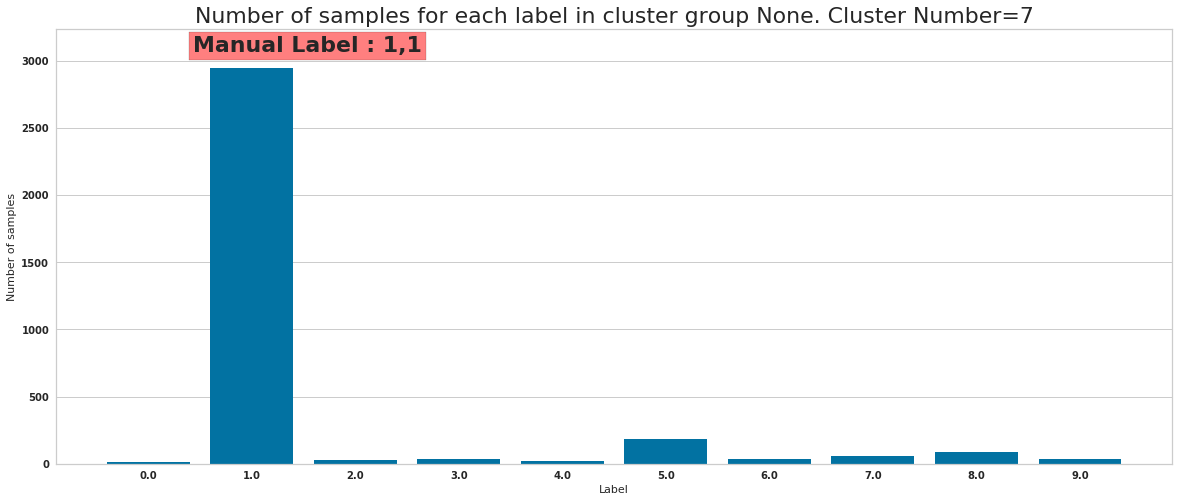

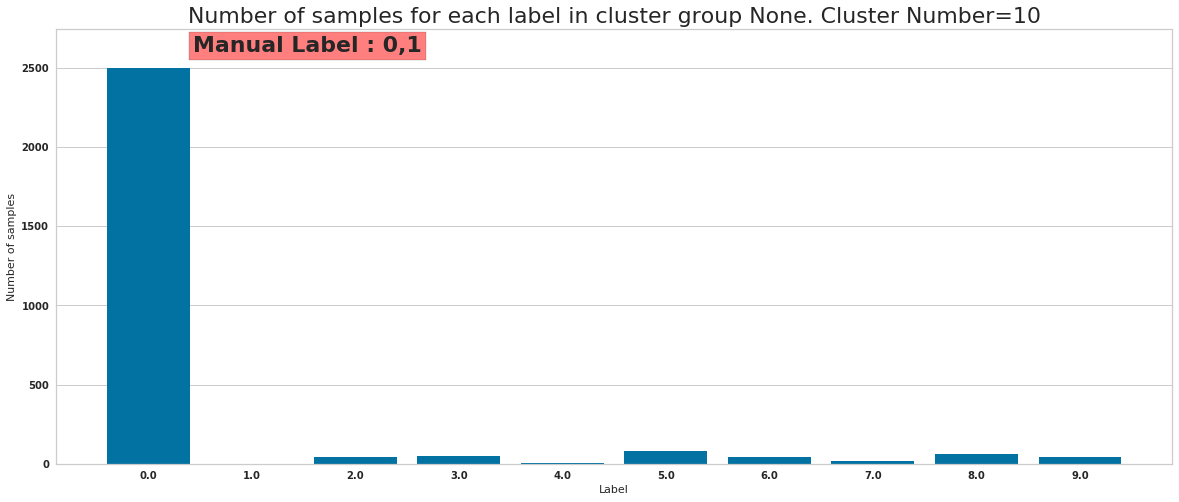

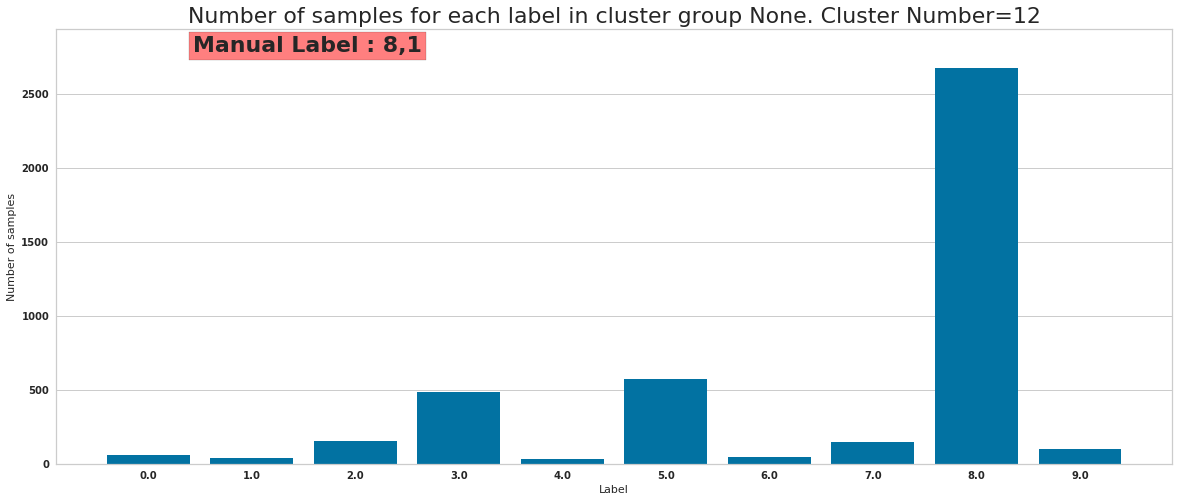

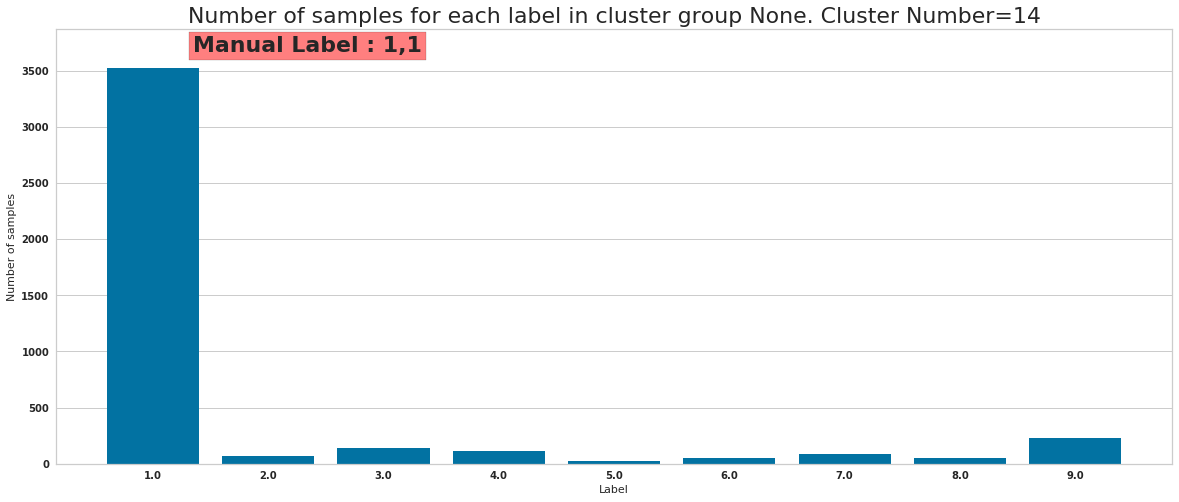

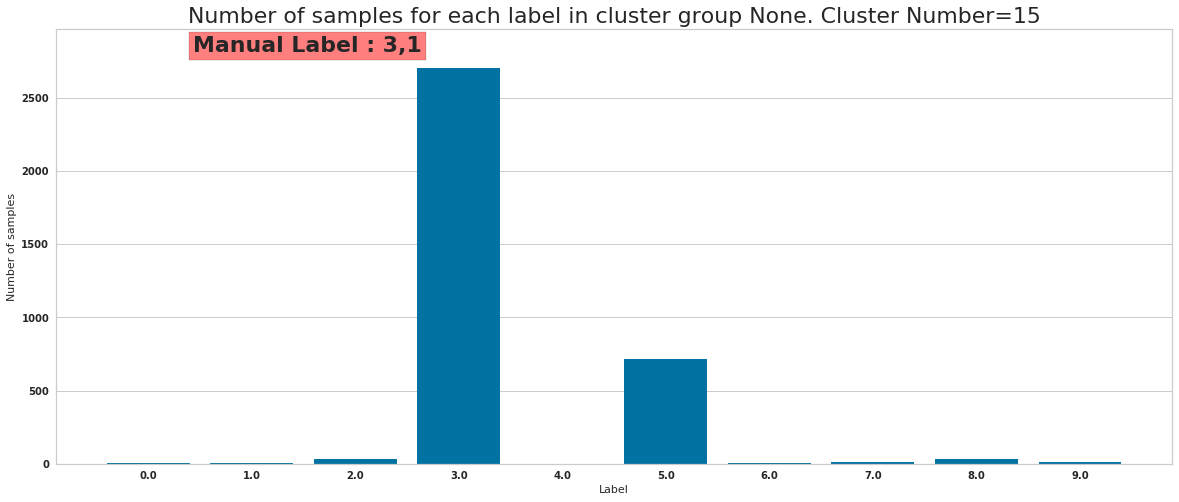

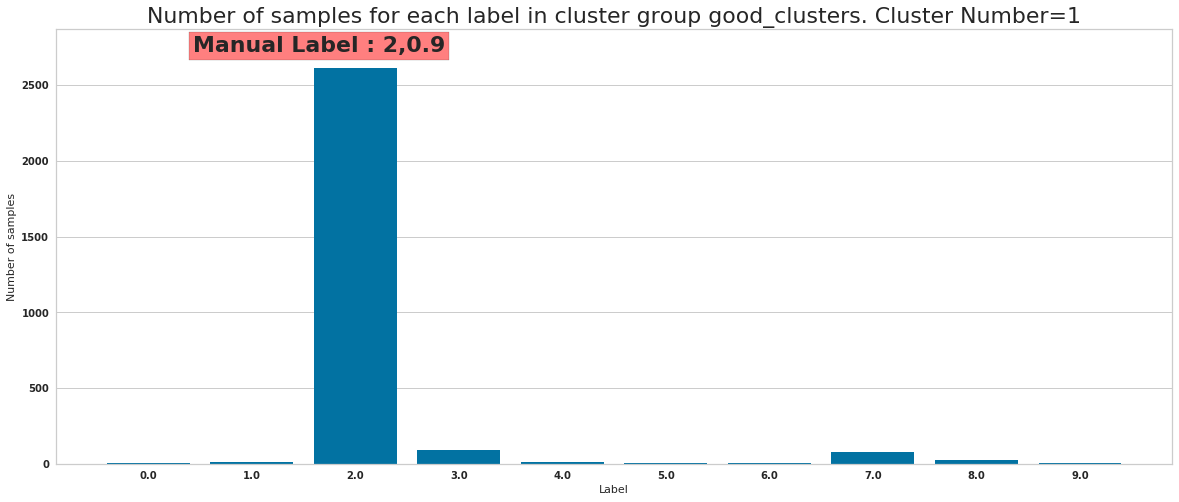

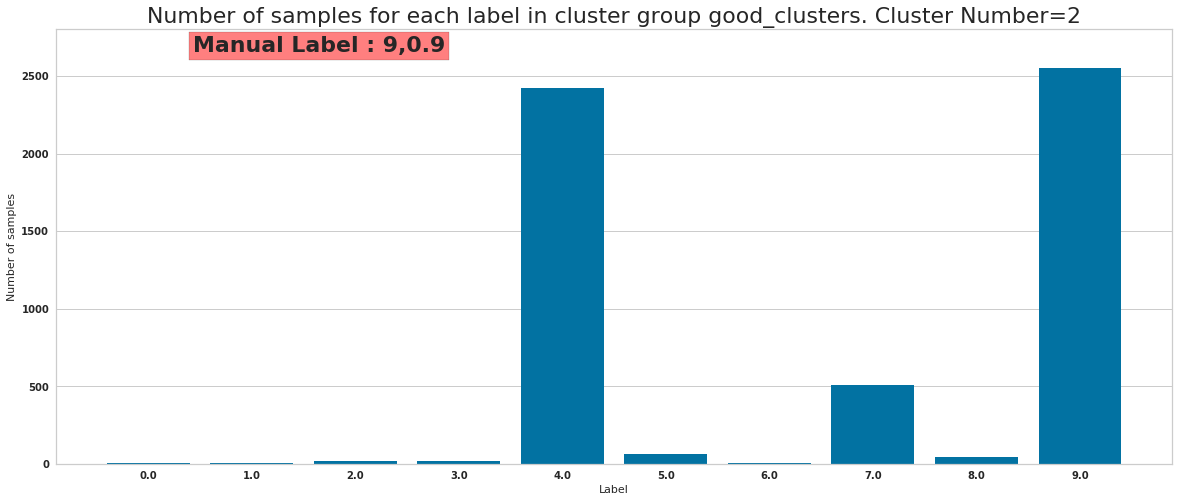

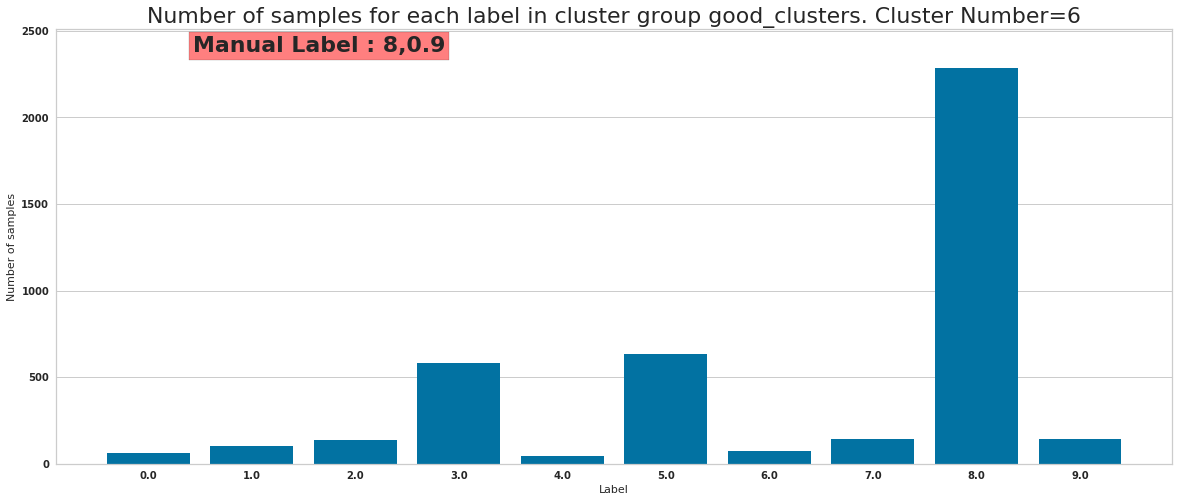

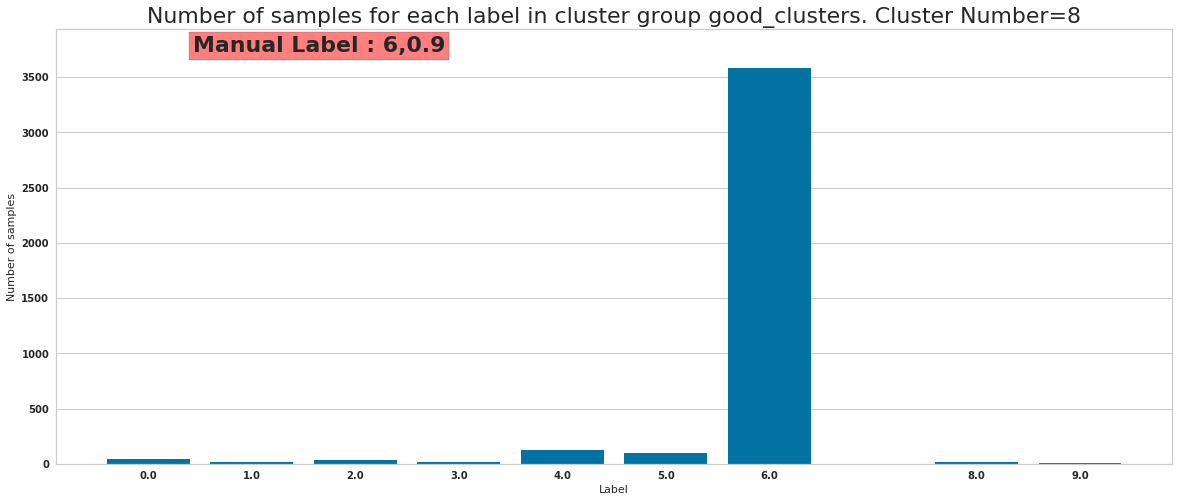

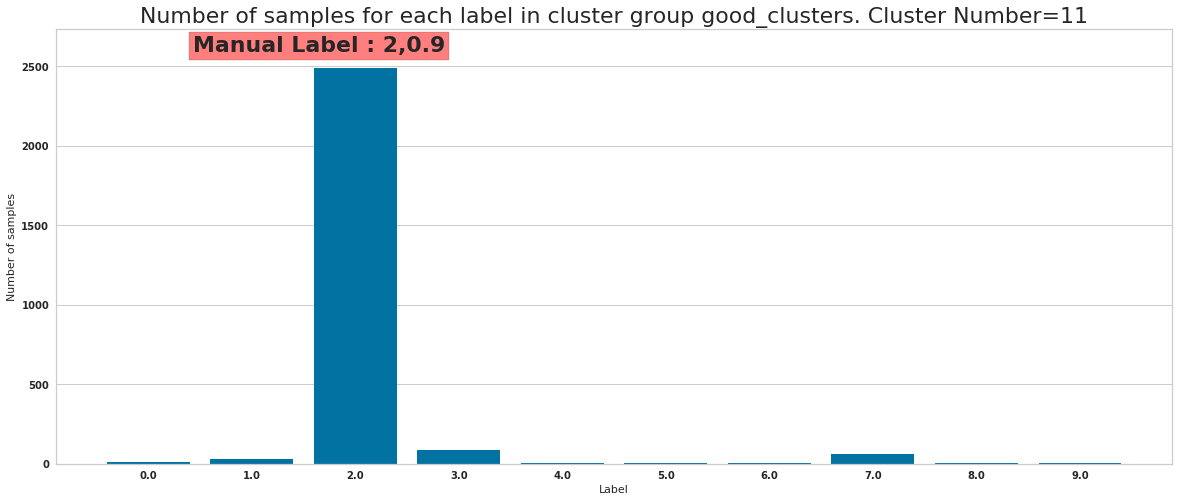

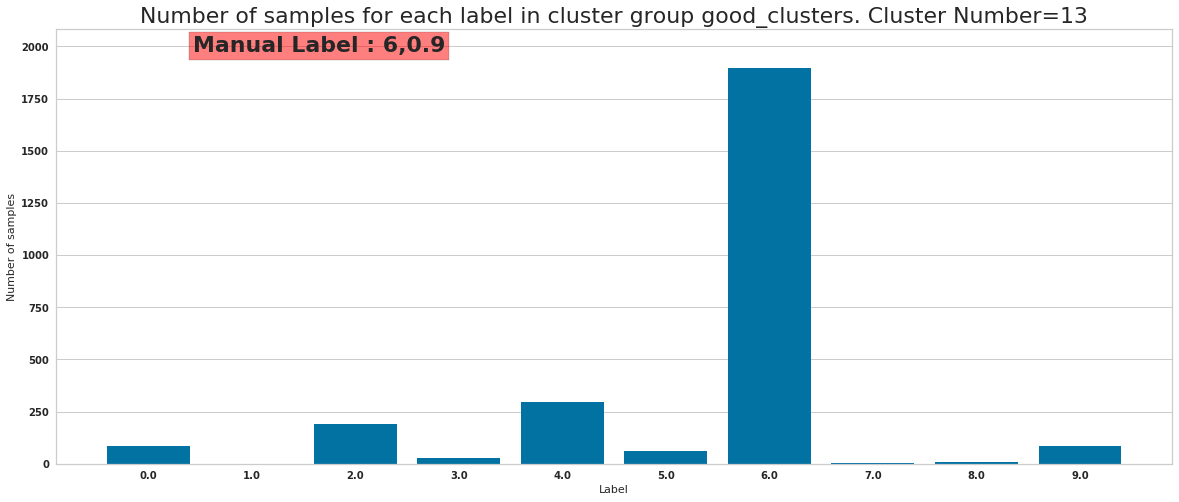

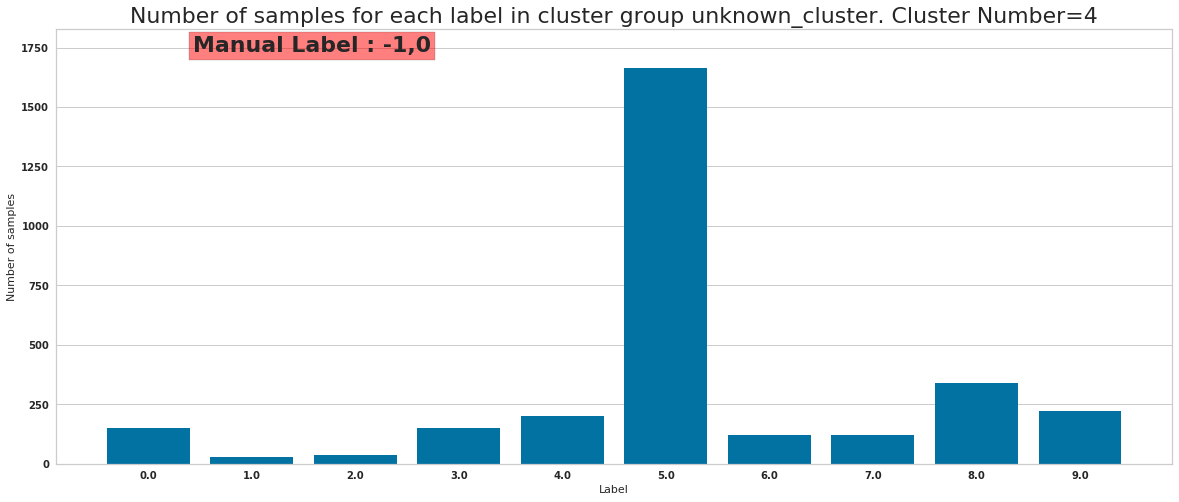

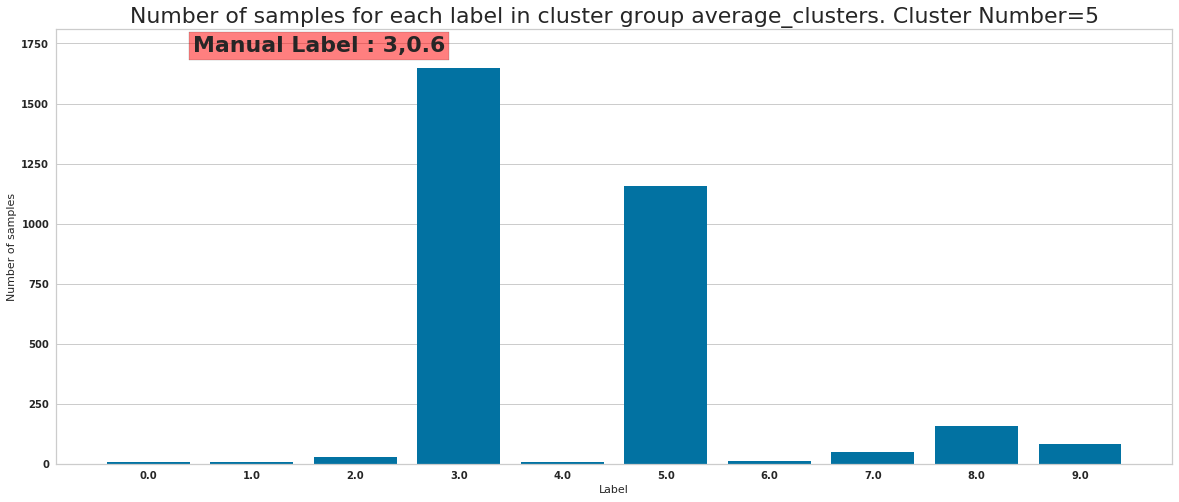

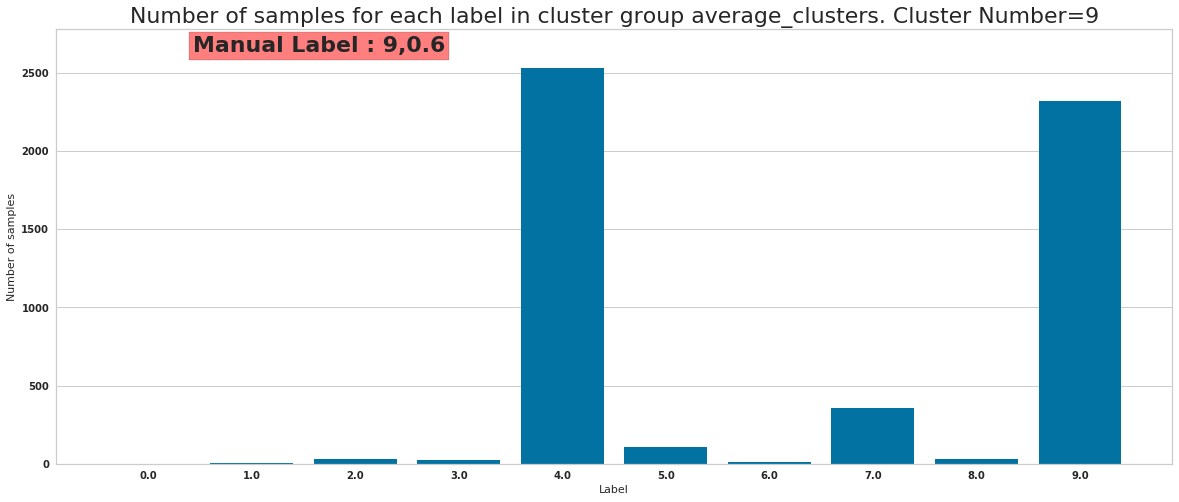

In [115]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7,2,9,0,
                                           -1,3,8,1,
                                           6,9,0,2,
                                           8,6,1,3
                                          ]
manual_annotation_json["manual_confidence"] = [1,0.9,0.9,1,
                                               0,0.6,0.9,1,
                                               0.9,0.6,1,0.9,
                                               1,0.9,1,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




4
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-5610
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-5610
 [*] Success to read ClassifierModel.model-5610
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


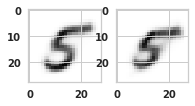

In [116]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


In [117]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1,-1]
level_2_cluster_dict["manual_confidences"] = [0,0]
level2_manual_annotations[4] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [118]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


4
2
Skipping distance computation for unknown cluster
Manual Label 7
(4718, 54) (4718, 49)
Num correct=4536
Cluster 0 Manual Label 7 Percentage correct 96.14243323442136
********************************
Manual Label 2
(2847, 54) (2847, 49)
Num correct=2609
Cluster 1 Manual Label 2 Percentage correct 91.64032314717247
********************************
Manual Label 9
(5642, 54) (5642, 49)
Num correct=2549
Cluster 2 Manual Label 9 Percentage correct 45.17901453385324
********************************
Manual Label 0
(3158, 54) (3158, 49)
Num correct=2954
Cluster 3 Manual Label 0 Percentage correct 93.54021532615579
********************************
unknown
<class 'dict'>
['unknown_cluster']
********************************
Manual Label 3
(3149, 54) (3149, 49)
Num correct=1646
Cluster 5 Manual Label 3 Percentage correct 52.270562083201014
********************************
Manual Label 8
(4202, 54) (4202, 49)
Num correct=2283
Cluster 6 Manual Label 8 Percentage correct 54.33127082341742
********

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

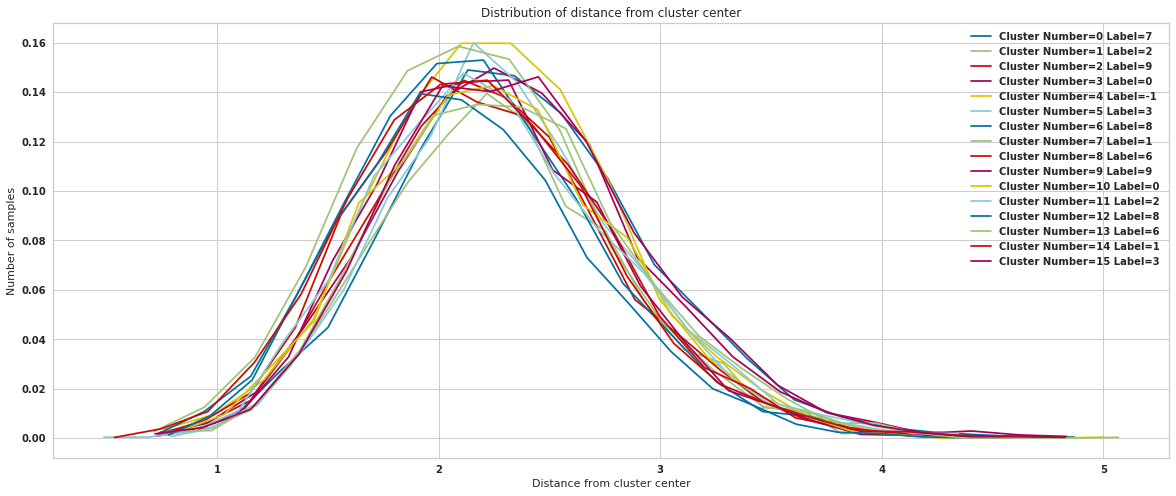

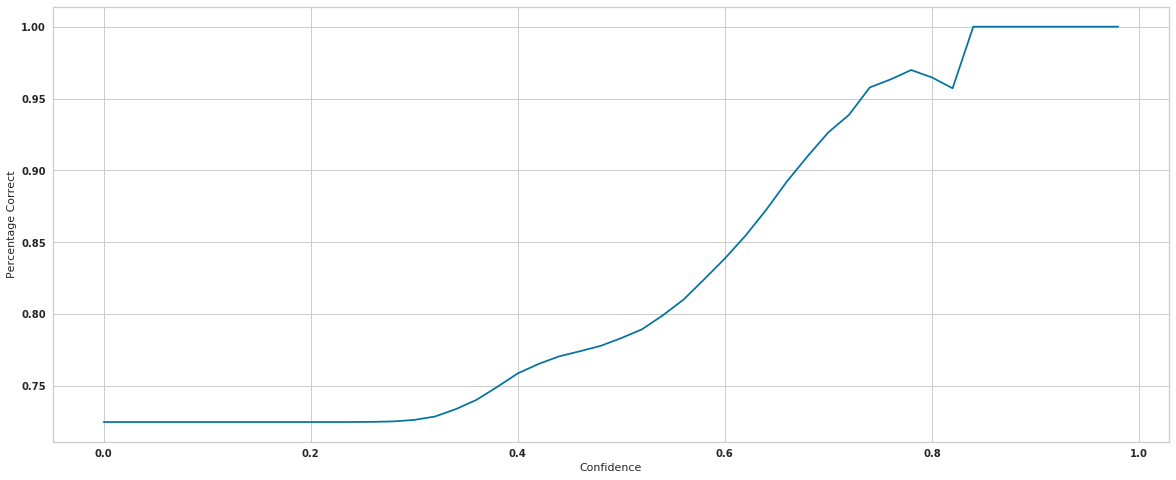

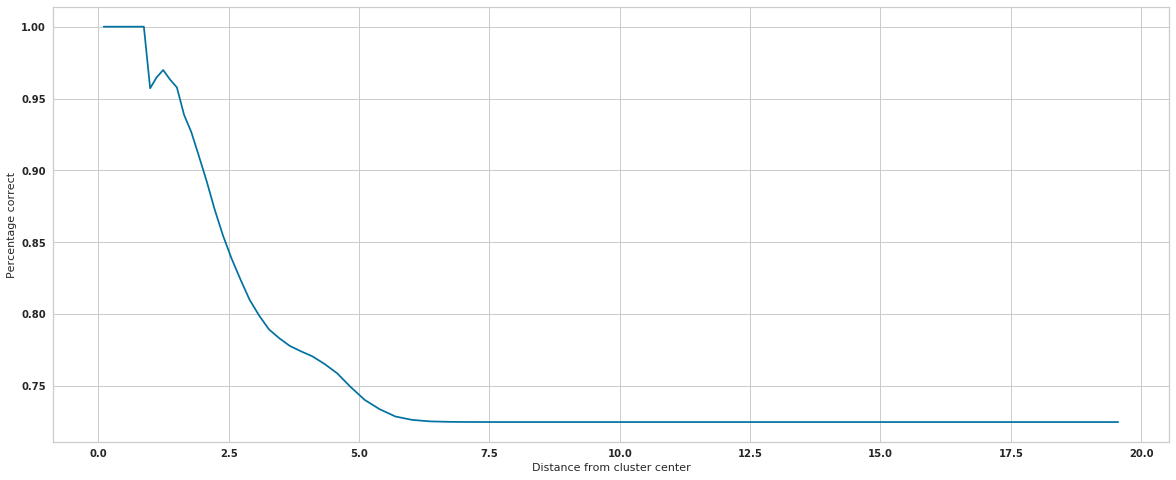

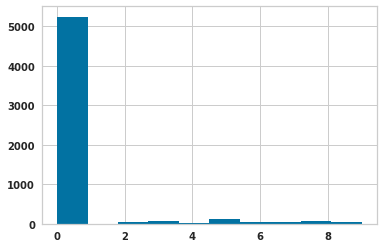

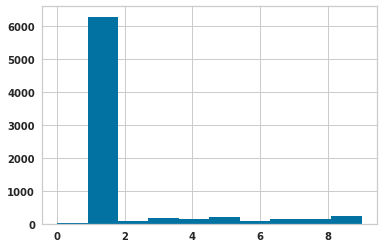

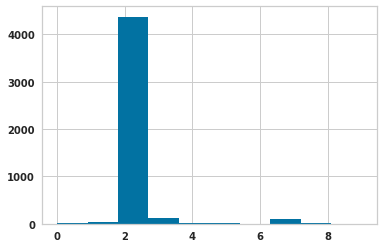

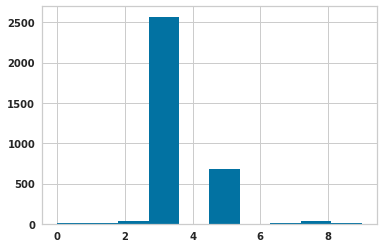

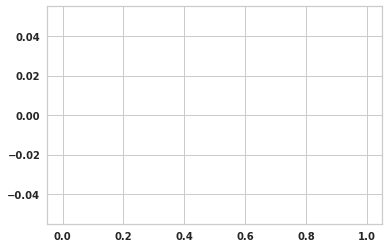

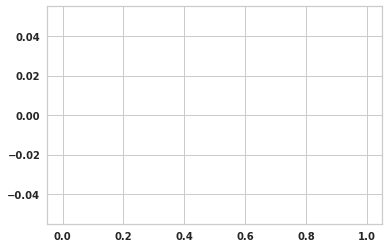

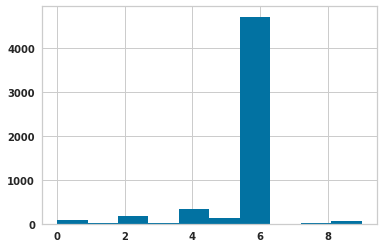

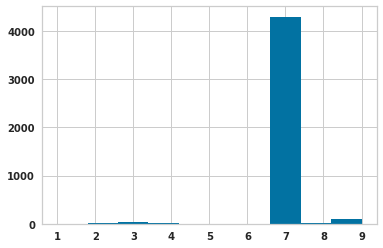

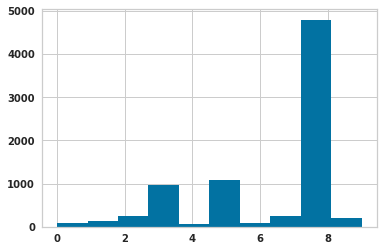

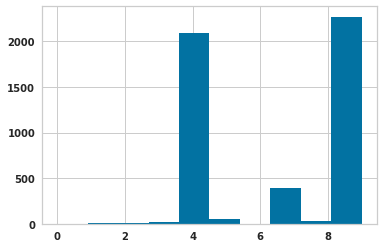

In [119]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [120]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 56805
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Running evaluation after epoch:06 and step:0300 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:6 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_06_0300/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:06 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:6 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_06_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:06 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:6 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_06_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-6545
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-6545
 [*] Success to read ClassifierModel.model-6545
 [*] Load SUCCESS
Number of steps completed=6545
Number of epochs completed 7.0
run_id=2 z_min=-4.9489493 z_max=4.856212
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.

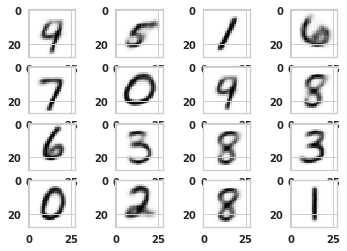

In [121]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


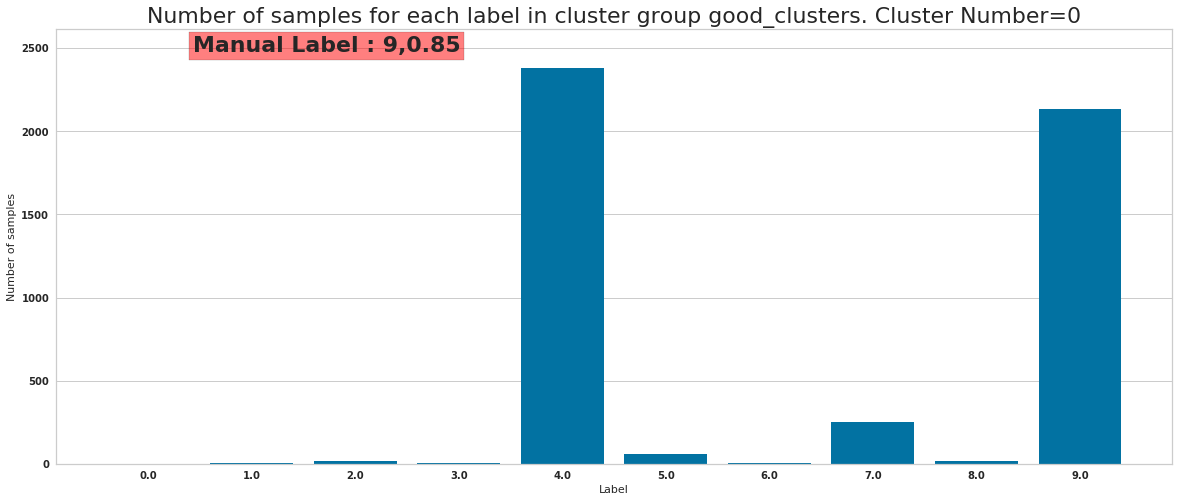

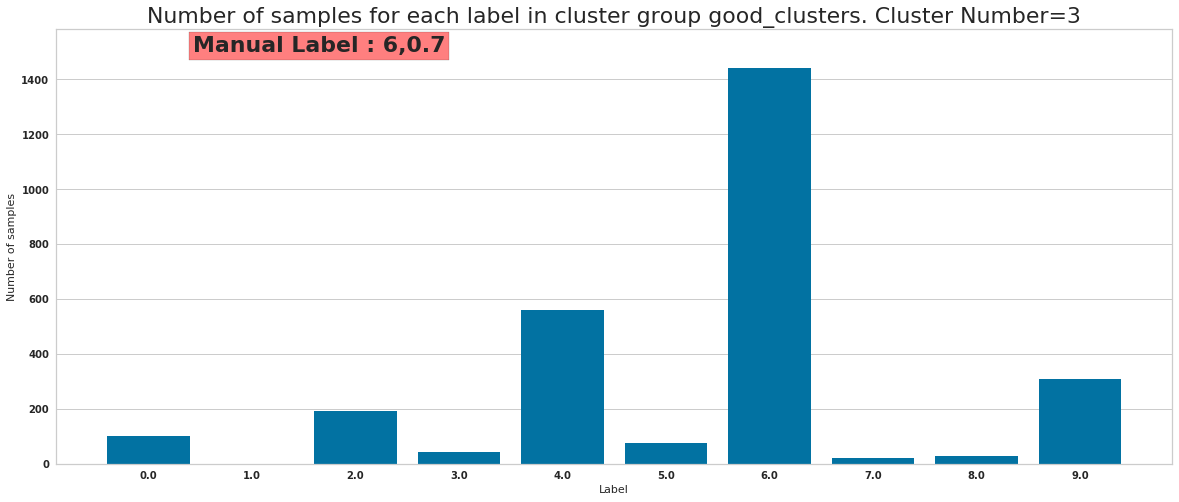

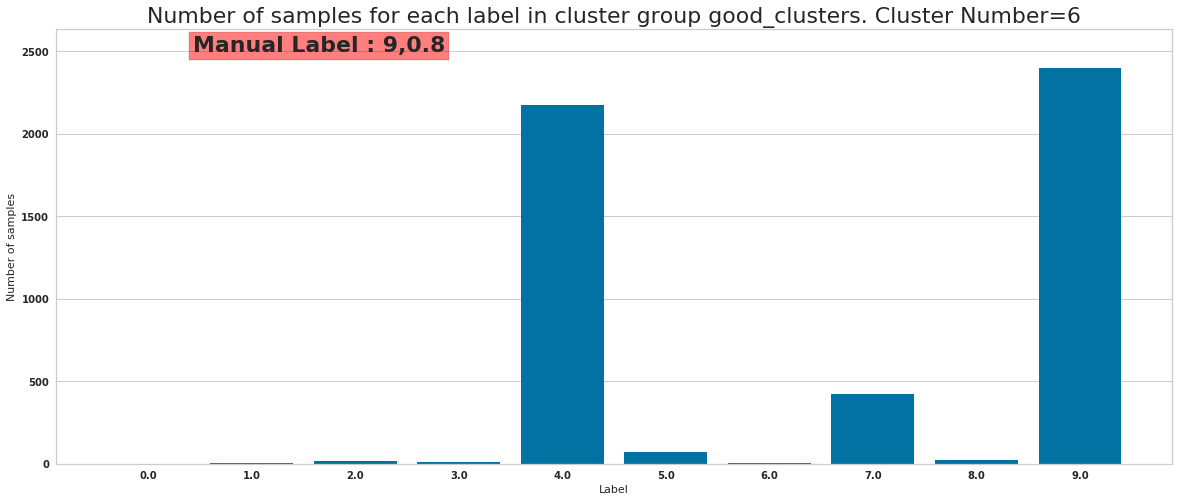

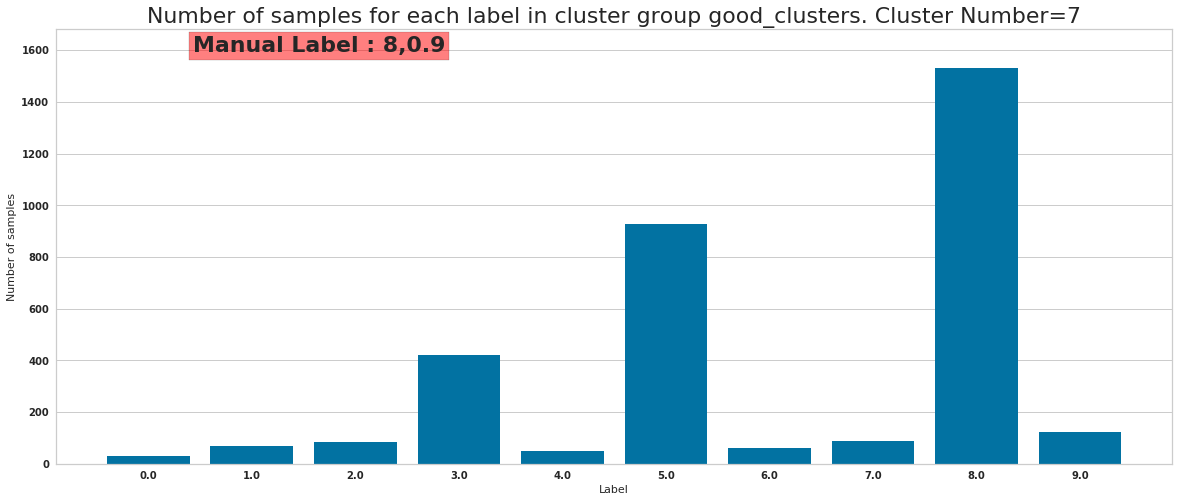

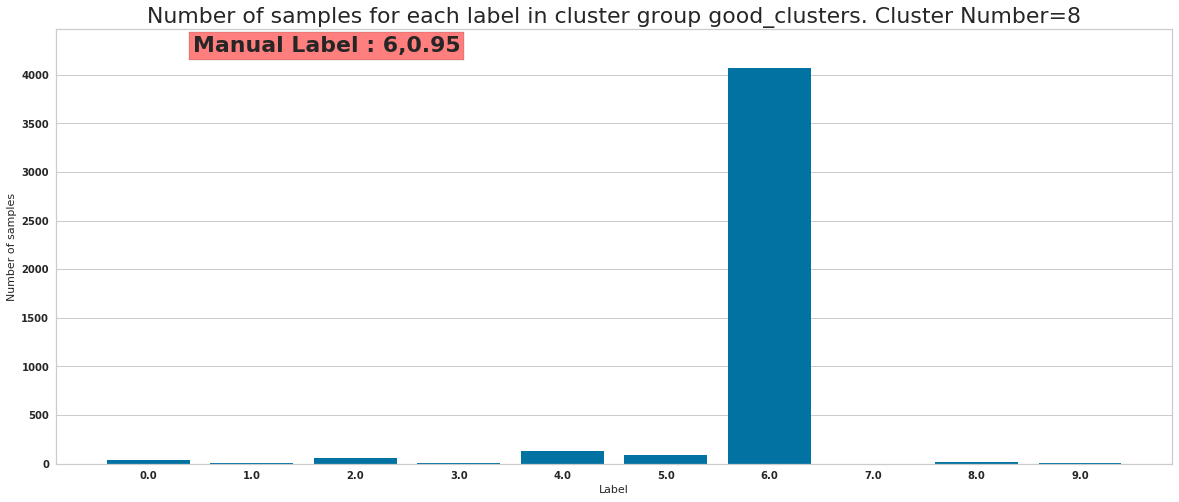

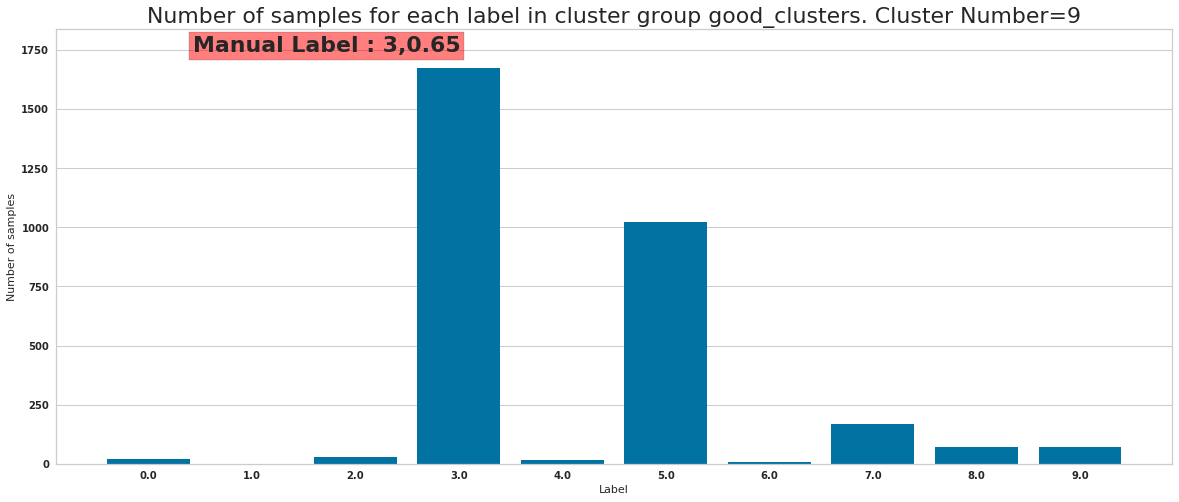

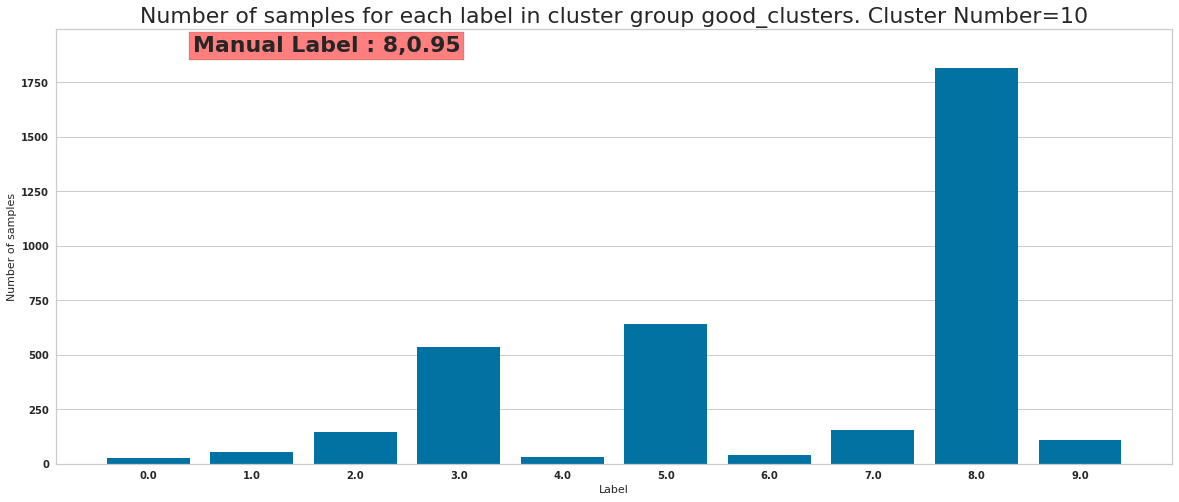

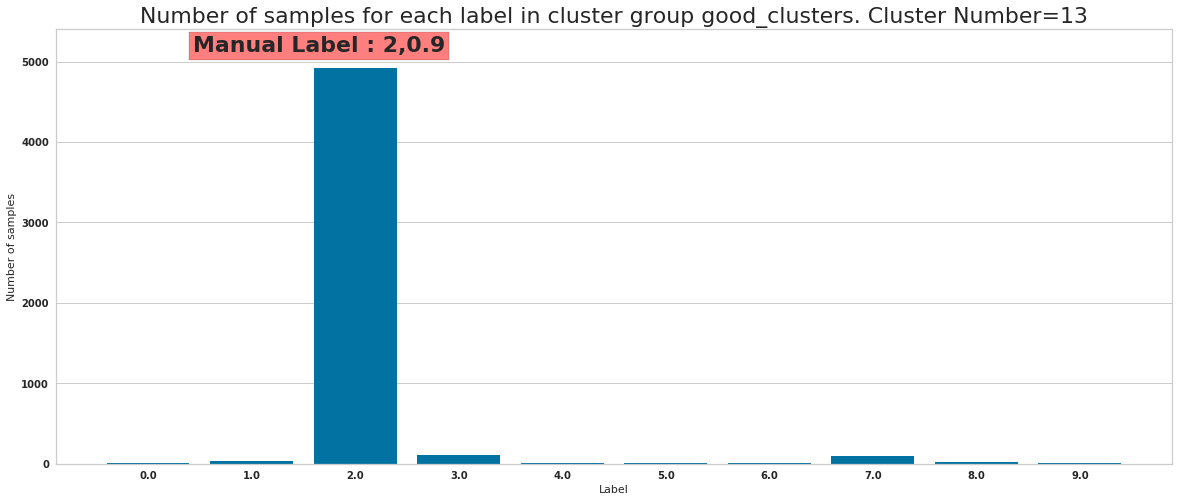

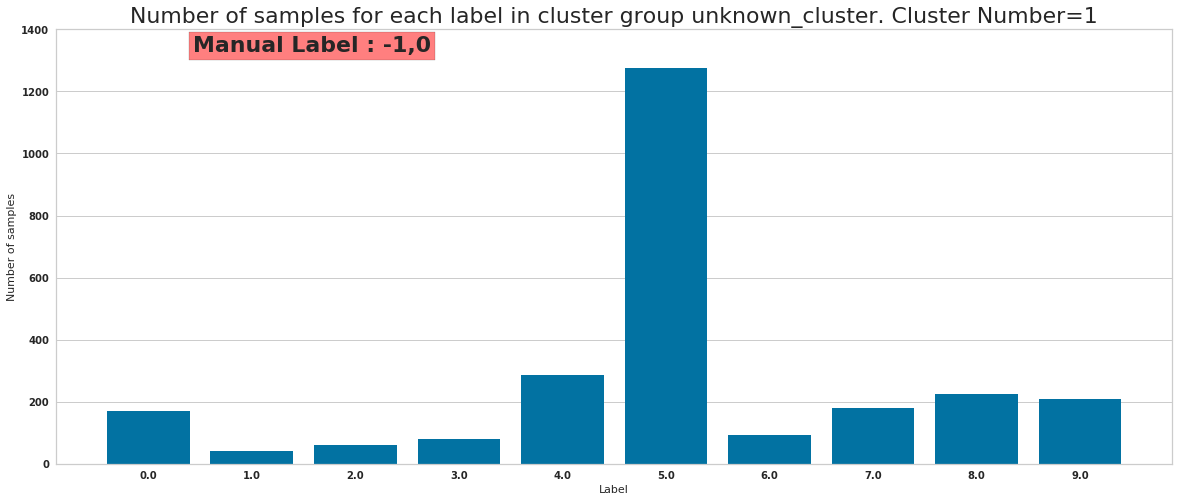

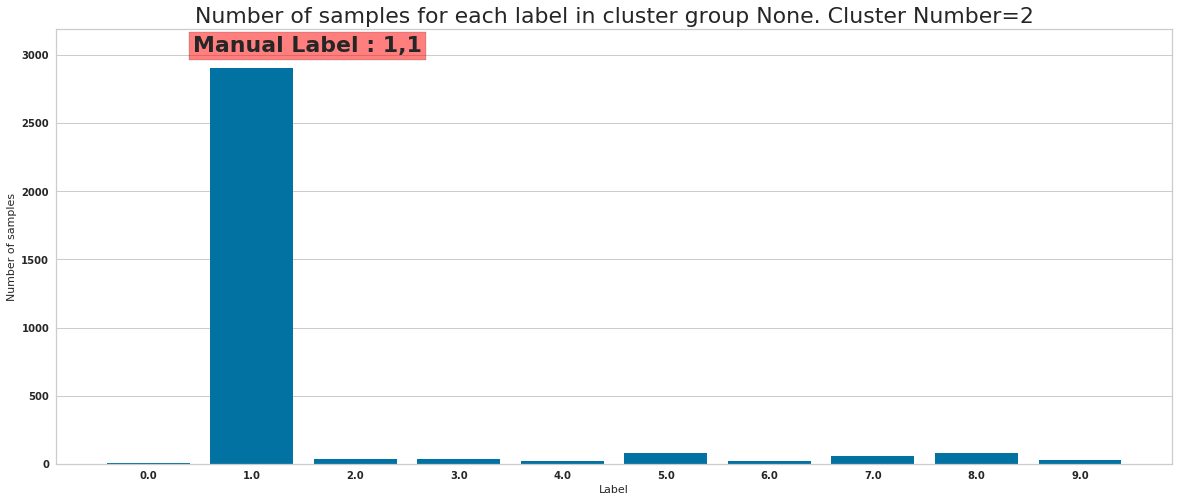

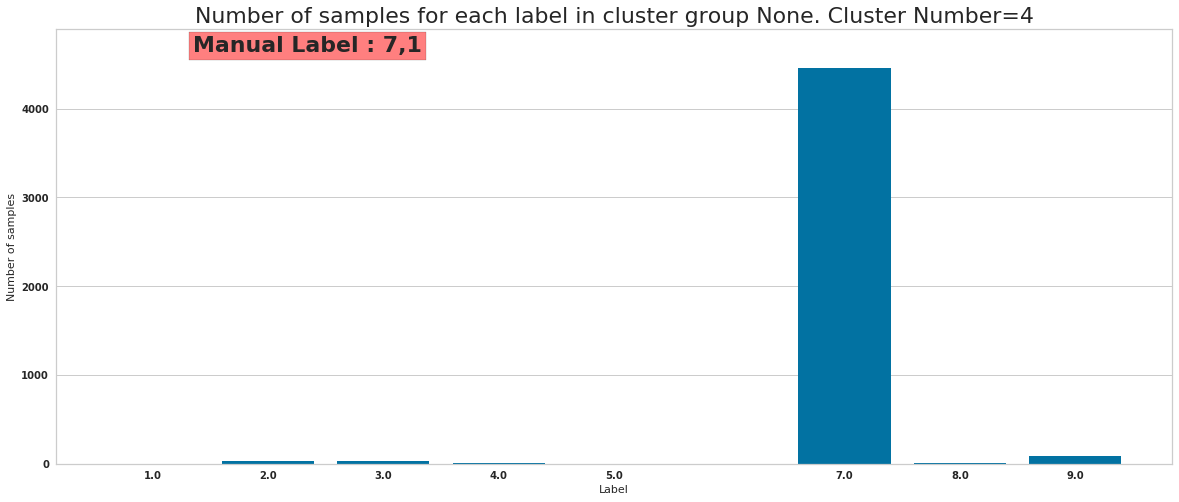

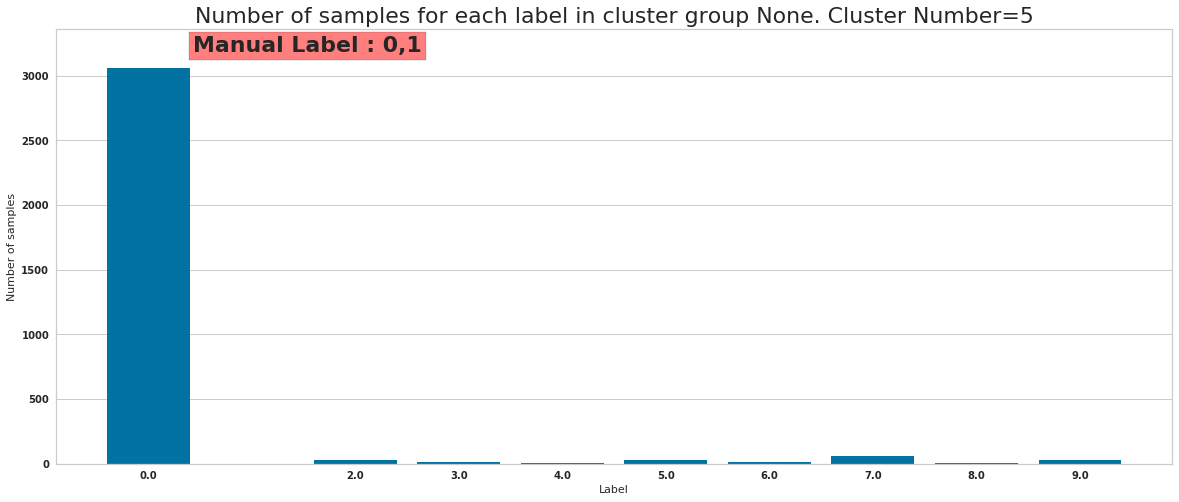

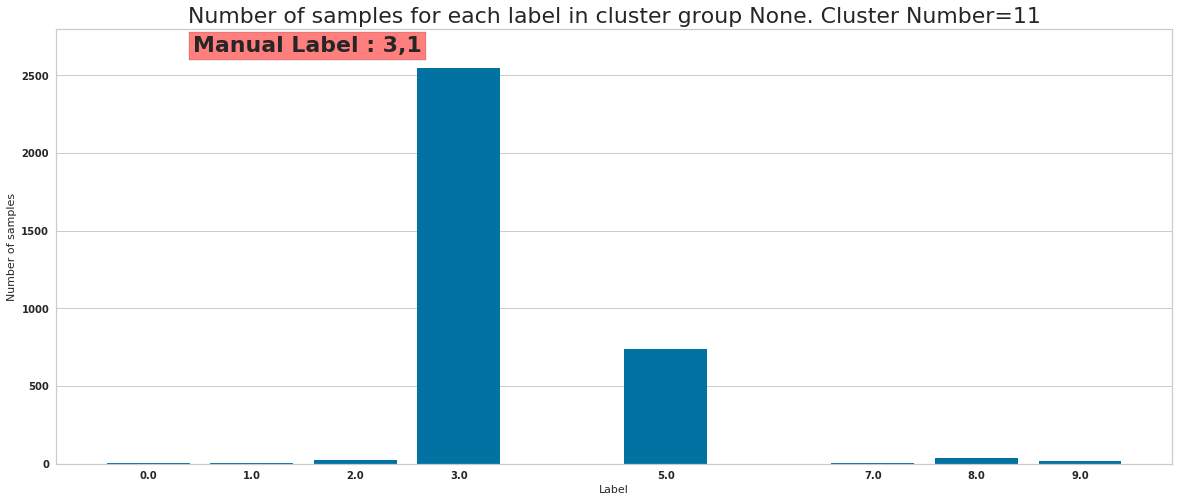

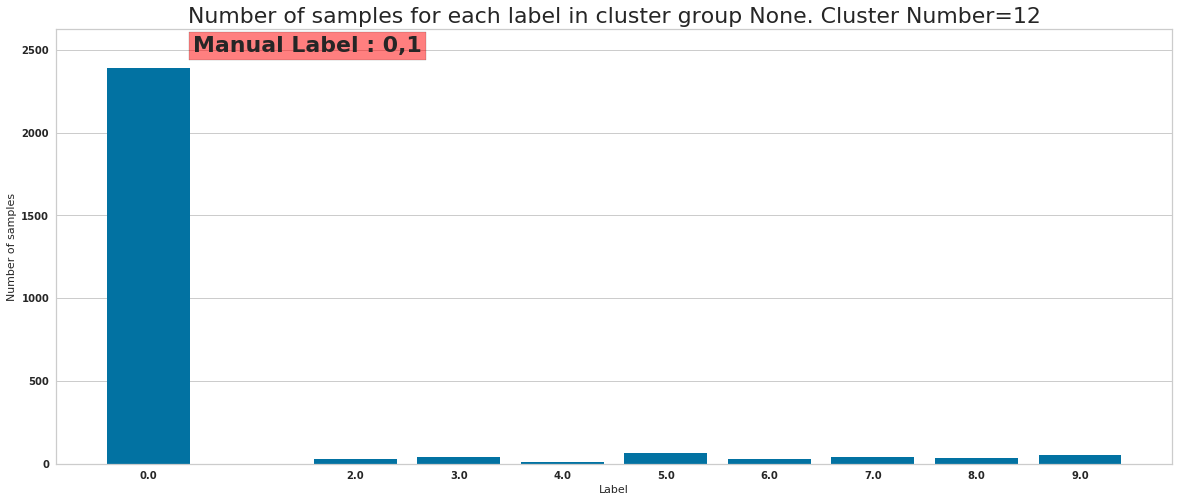

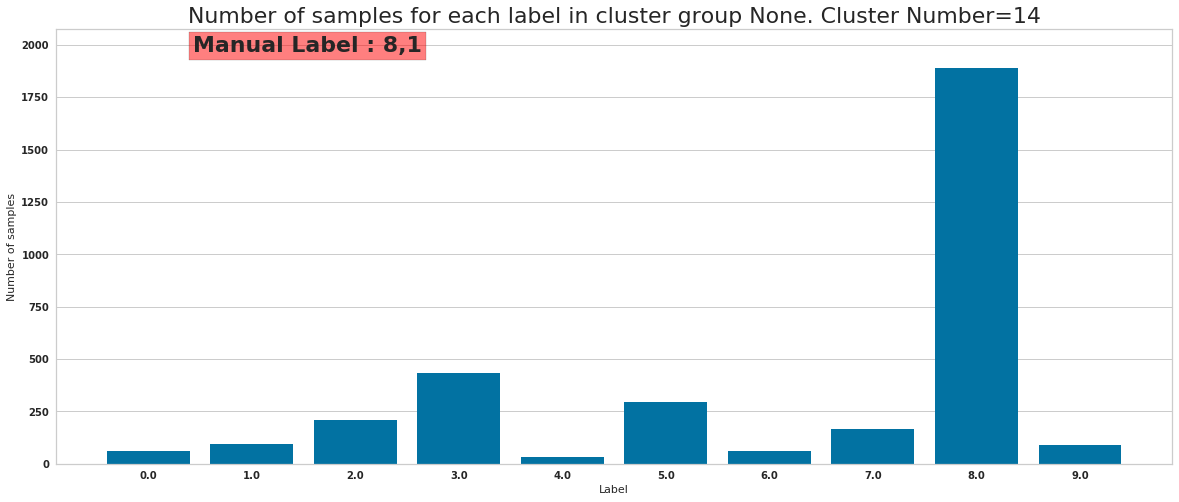

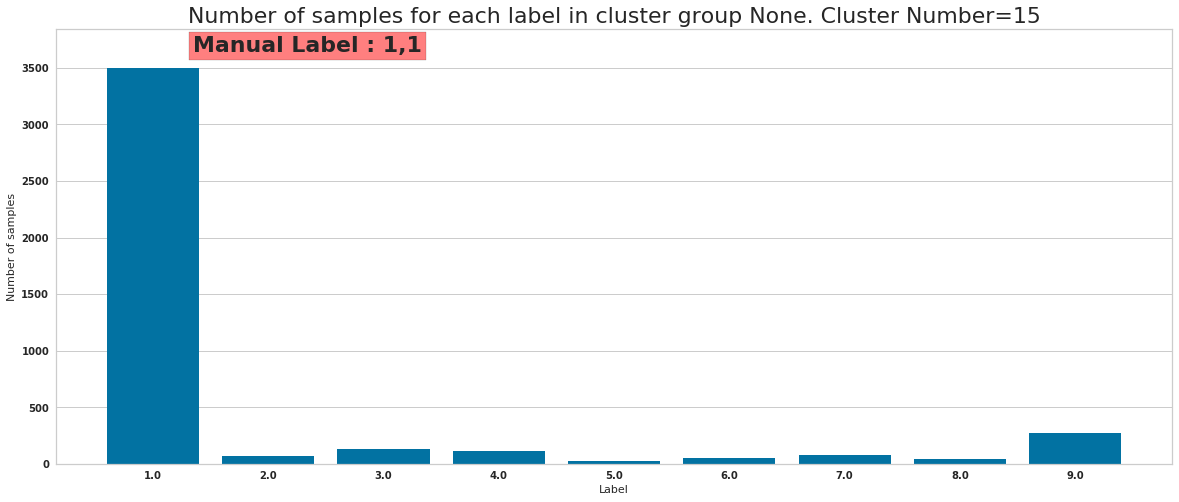

In [122]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [9,-1,1,6,
                                           7,0,9,8,
                                           6,3,8,3,
                                           0,2,8,1
                                          ]
manual_annotation_json["manual_confidence"] = [0.85,0,1,0.7,
                                               1,1,0.8,0.9,
                                               0.95,0.65,0.95,1,
                                               1,0.9,1,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


1
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-6545
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-6545
 [*] Success to read ClassifierModel.model-6545
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


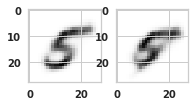

In [123]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


In [124]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1,-1]
level_2_cluster_dict["manual_confidences"] = [0,0]
level2_manual_annotations[1] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [125]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


1
2
Skipping distance computation for unknown cluster
Manual Label 9
(4878, 54) (4878, 32)
Num correct=2136
Cluster 0 Manual Label 9 Percentage correct 43.788437884378844
********************************
unknown
<class 'dict'>
['unknown_cluster']
********************************
Manual Label 1
(3259, 54) (3259, 32)
Num correct=2902
Cluster 2 Manual Label 1 Percentage correct 89.04571954587297
********************************
Manual Label 6
(2766, 54) (2766, 32)
Num correct=1440
Cluster 3 Manual Label 6 Percentage correct 52.060737527114966
********************************
Manual Label 7
(4614, 54) (4614, 32)
Num correct=4453
Cluster 4 Manual Label 7 Percentage correct 96.51061985262245
********************************
Manual Label 0
(3247, 54) (3247, 32)
Num correct=3056
Cluster 5 Manual Label 0 Percentage correct 94.11764705882354
********************************
Manual Label 9
(9998, 54) (5120, 32)
Num correct=4532
Cluster 6 Manual Label 9 Percentage correct 45.329065813162636
******

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

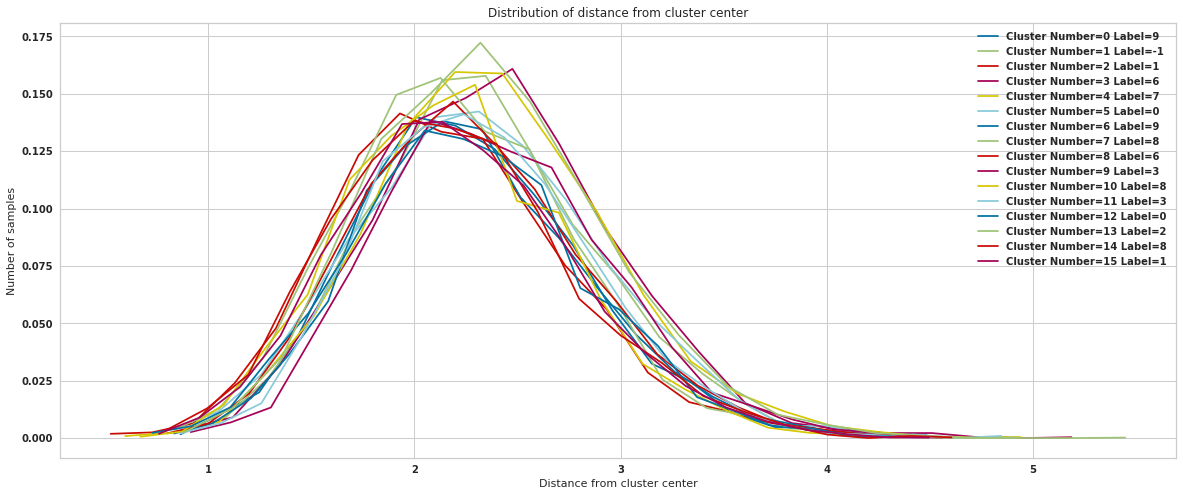

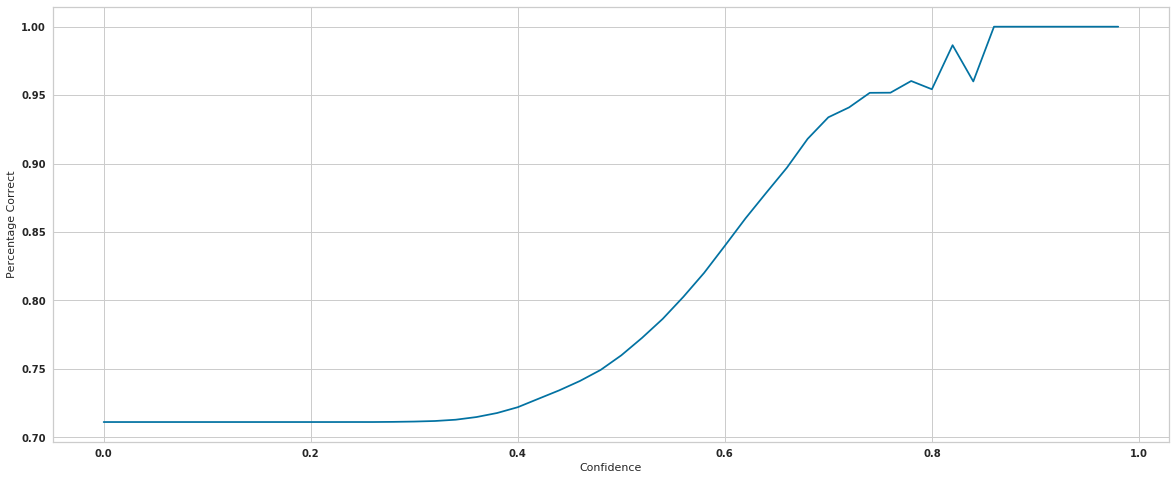

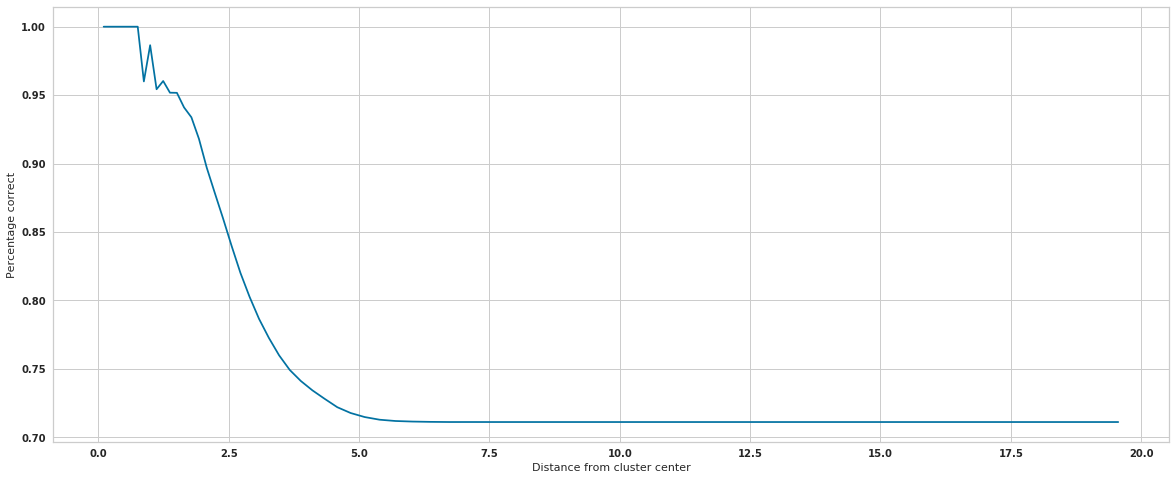

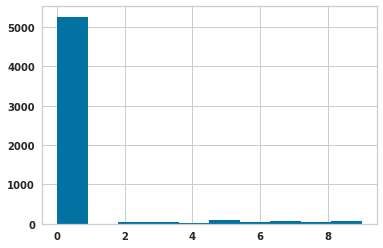

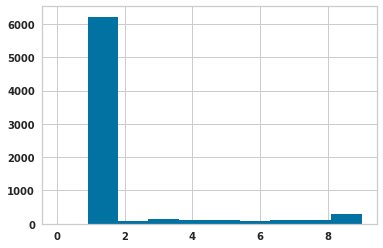

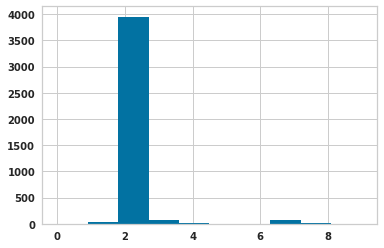

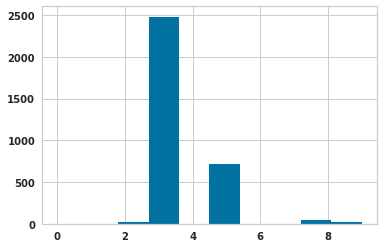

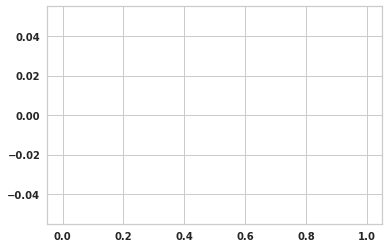

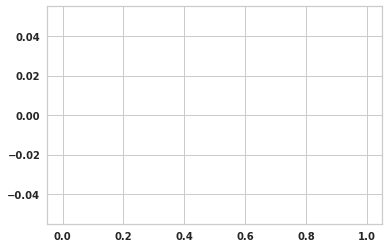

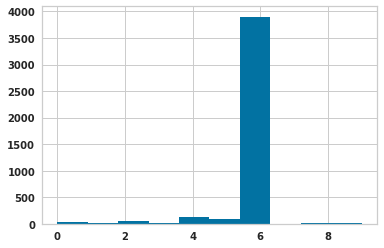

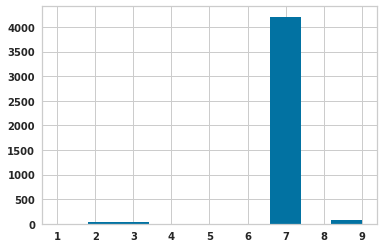

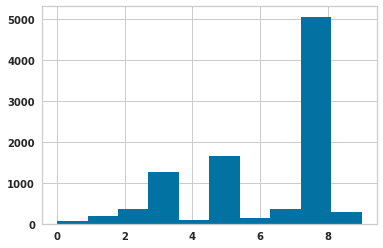

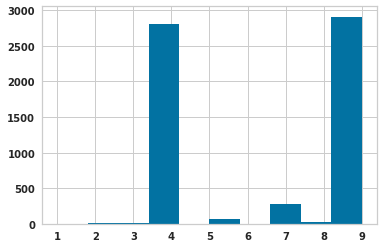

In [126]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [127]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 57217
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:07 and step:0300 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:7 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_07_0300/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:07 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:7 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_07_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:07 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:7 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_07_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-7480
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-7480
 [*] Success to read ClassifierModel.model-7480
 [*] Load SUCCESS
Number of steps completed=7480
Number of epochs completed 8.0
run_id=2 z_min=-4.4770355 z_max=4.1615150000000005
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergenc

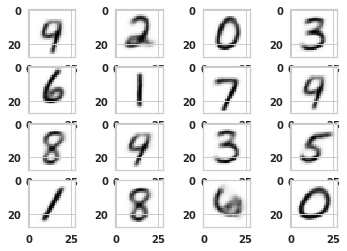

In [128]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


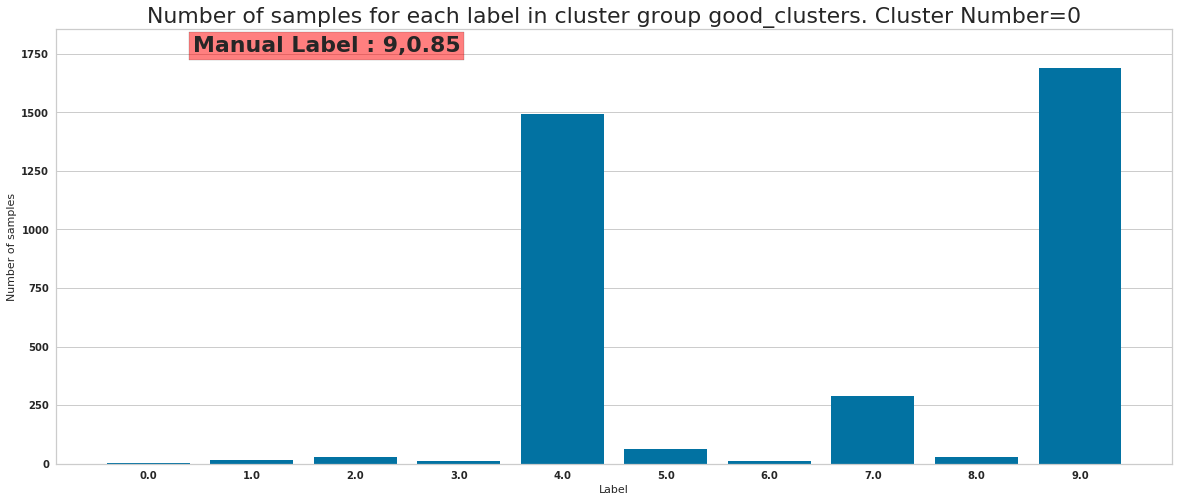

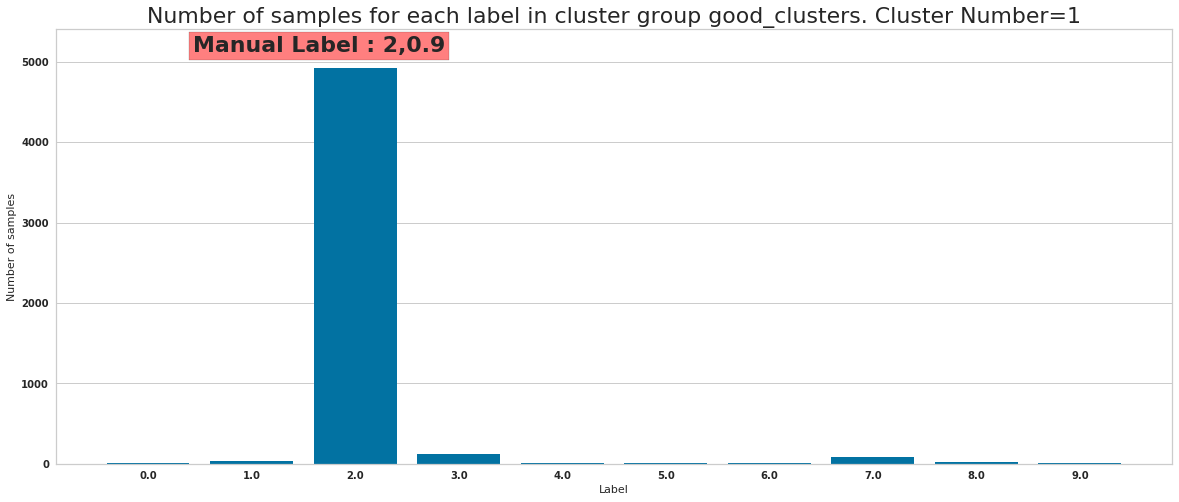

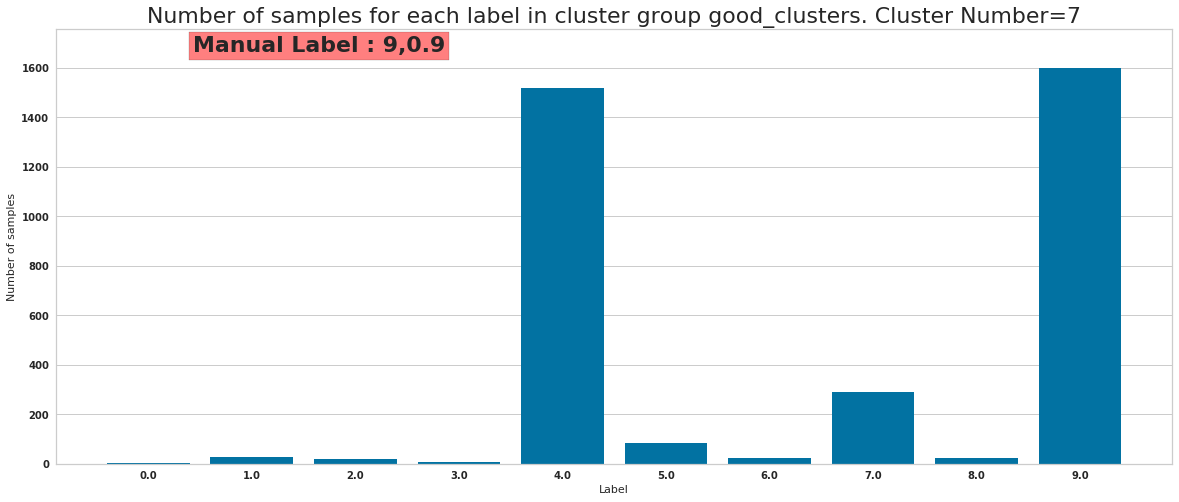

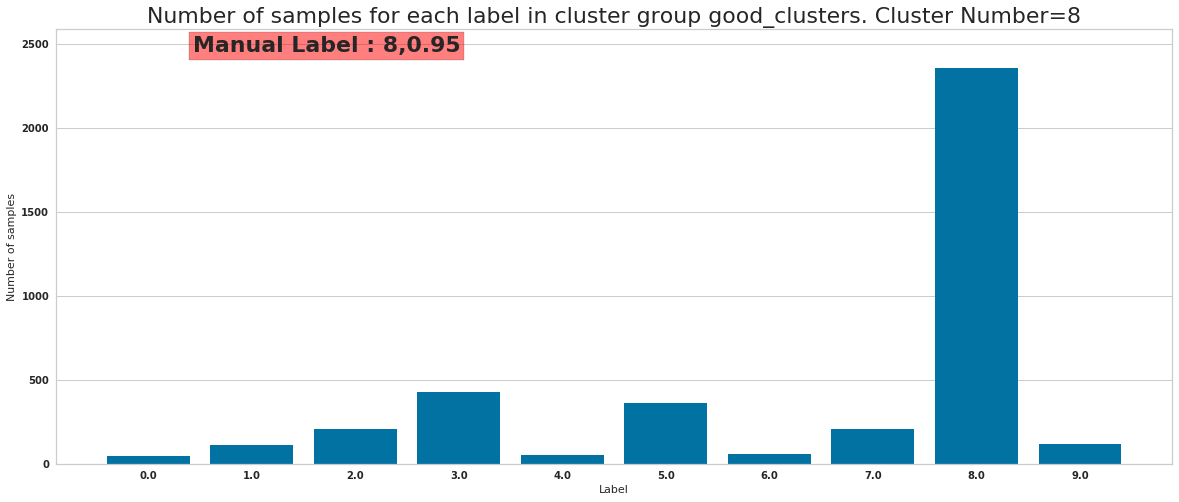

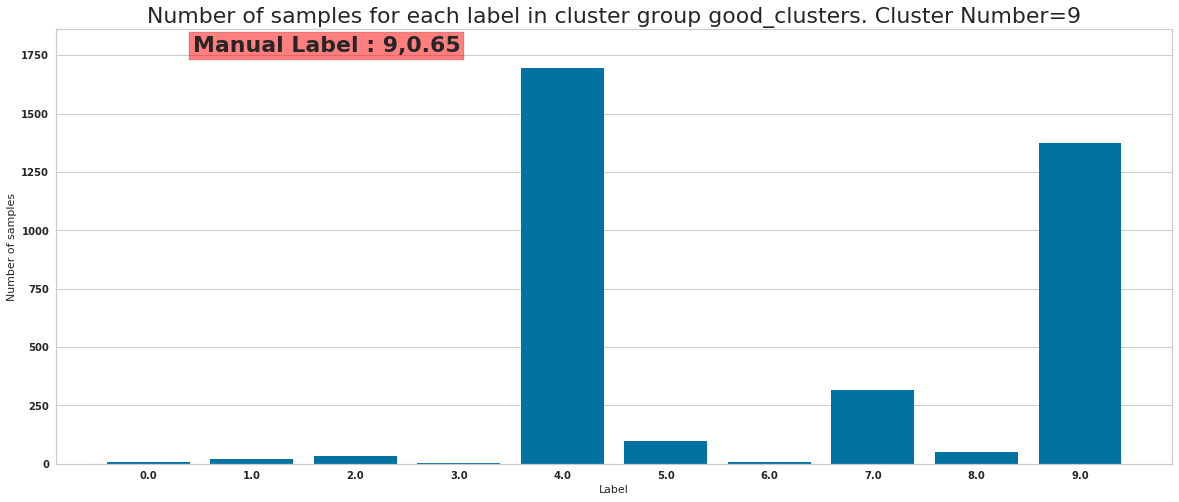

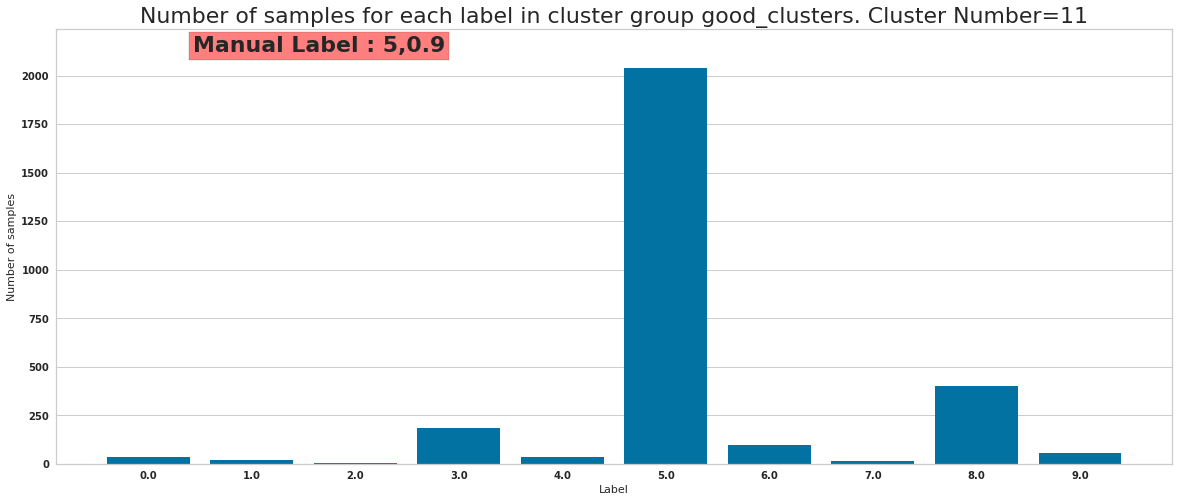

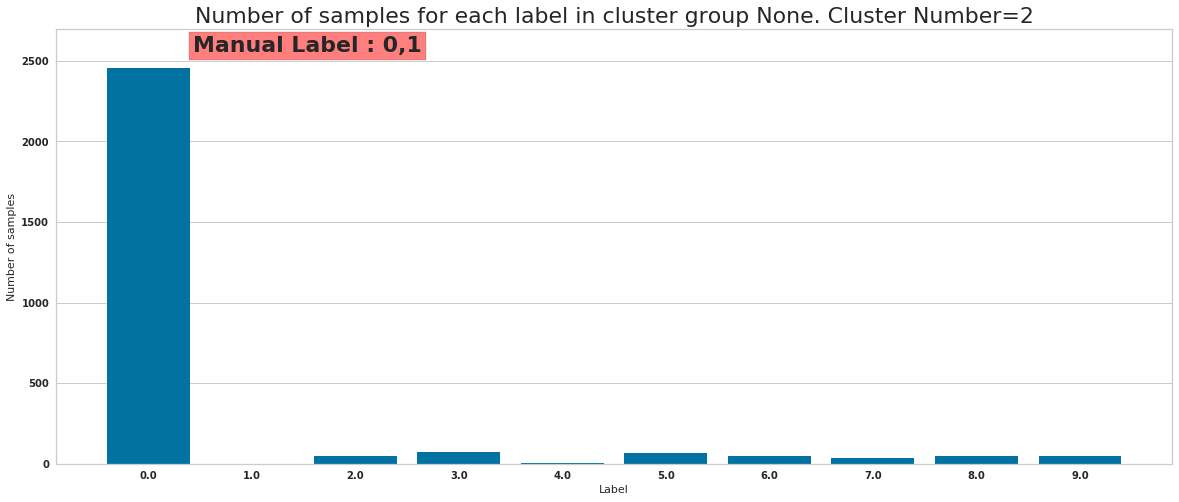

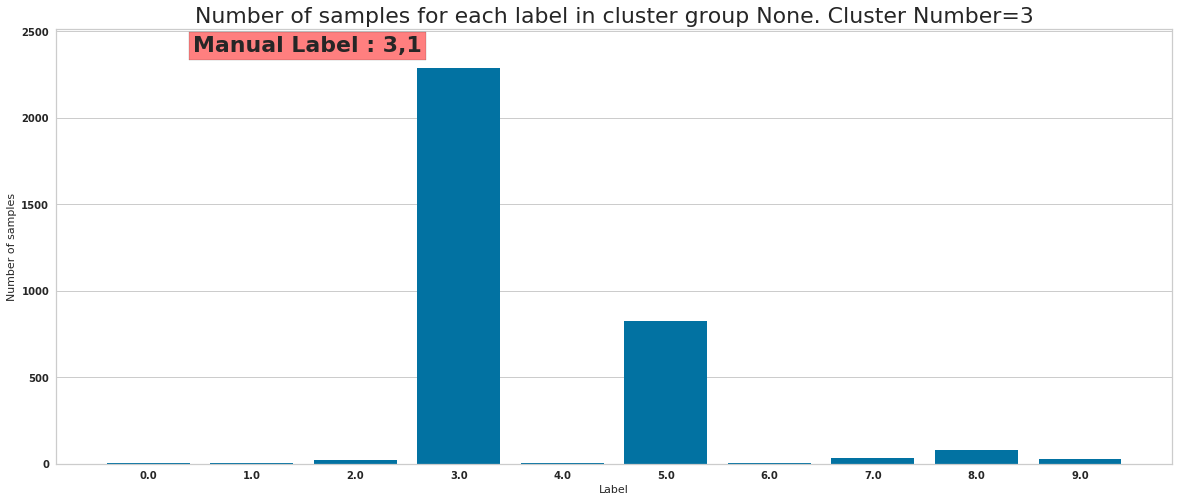

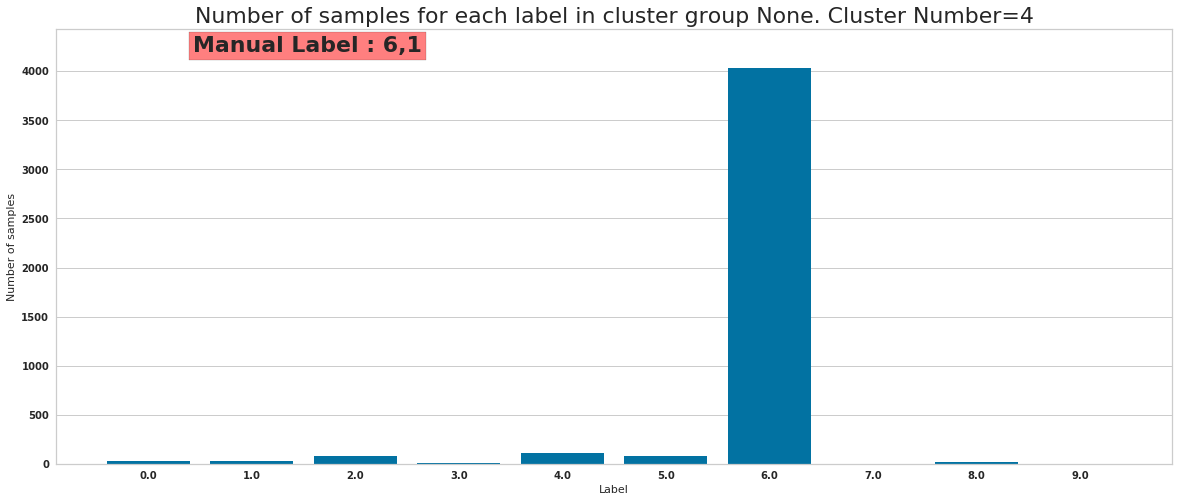

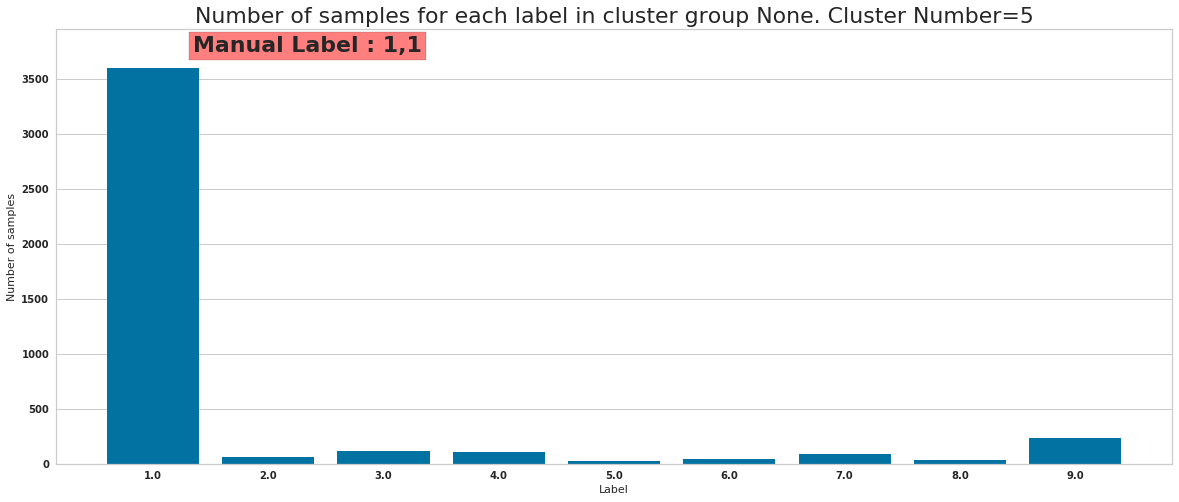

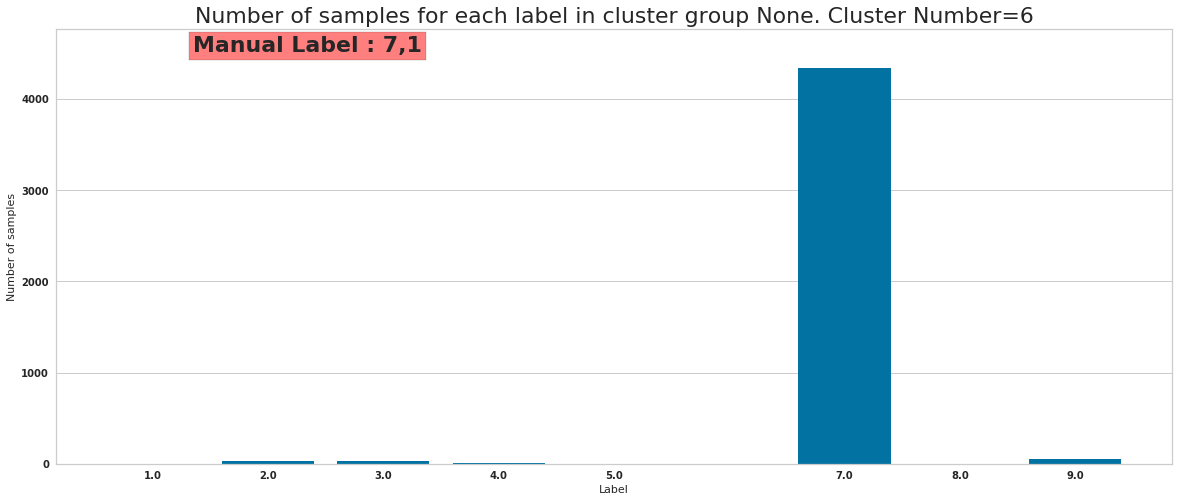

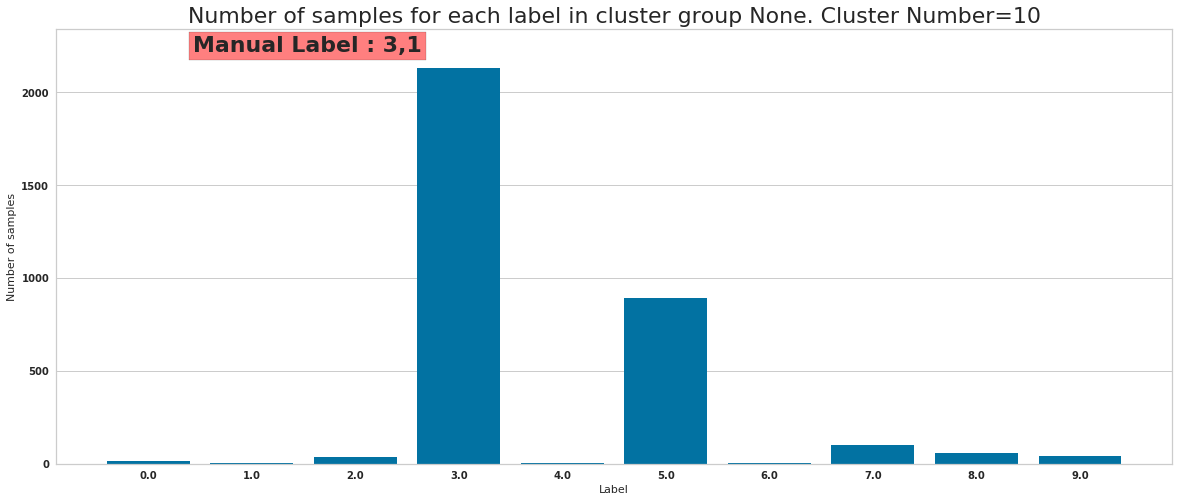

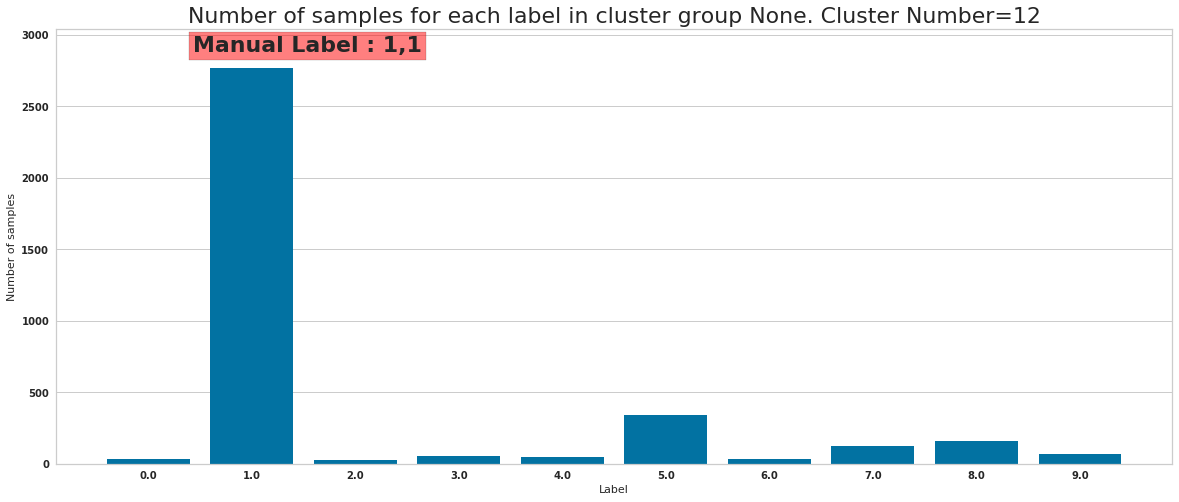

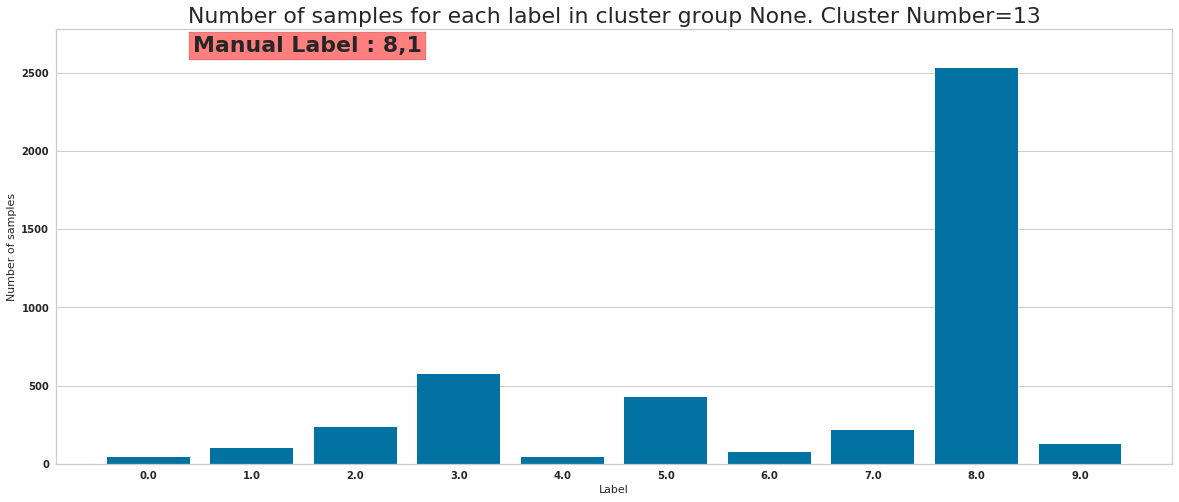

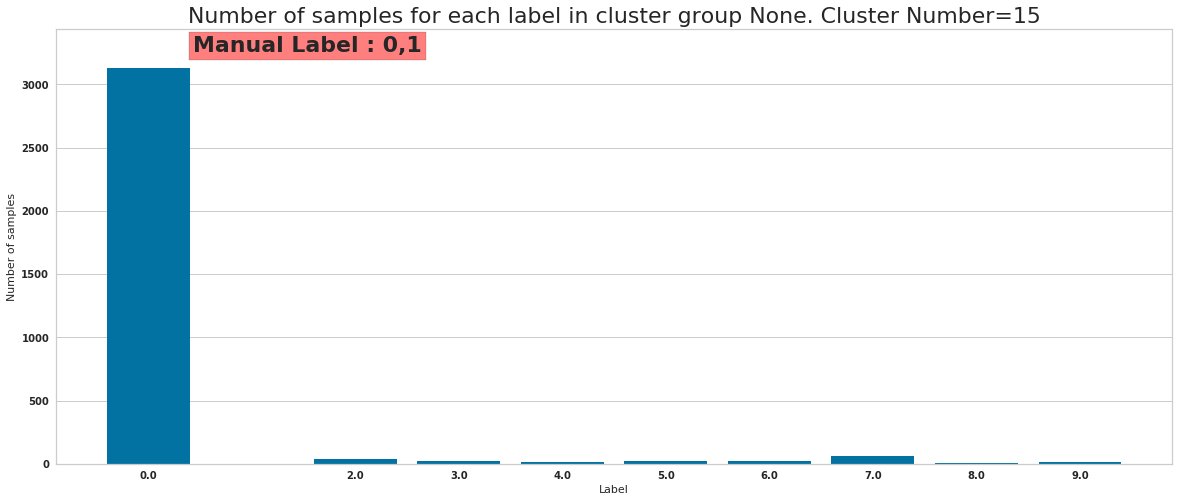

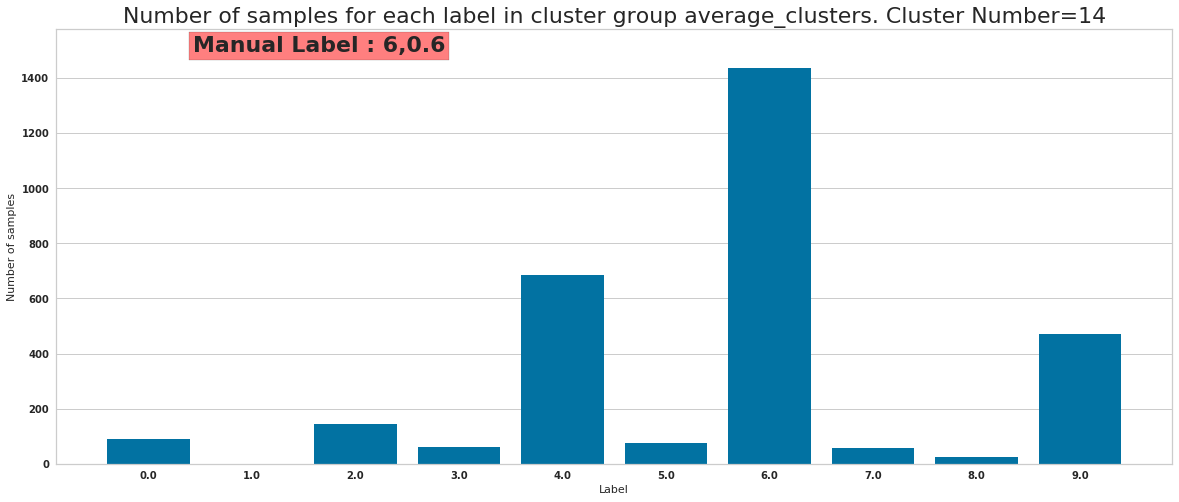

In [129]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [9,2,0,3,
                                           6,1,7,9,
                                           8,9,3,5,
                                           1,8,6,0
                                          ]
manual_annotation_json["manual_confidence"] = [0.85,0.9,1,1,
                                               1,1,1,0.9,
                                               0.95,0.65,1,0.9,
                                               1,1,0.6,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




In [130]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [131]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[1] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [132]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


Manual Label 9
(3640, 52) (3640, 32)
Num correct=1687
Cluster 0 Manual Label 9 Percentage correct 46.34615384615385
********************************
Manual Label 2
(5220, 52) (5220, 32)
Num correct=4917
Cluster 1 Manual Label 2 Percentage correct 94.19540229885058
********************************
Manual Label 0
(2829, 52) (2829, 32)
Num correct=2452
Cluster 2 Manual Label 0 Percentage correct 86.67373630258042
********************************
Manual Label 3
(3291, 52) (3291, 32)
Num correct=2285
Cluster 3 Manual Label 3 Percentage correct 69.43178365238529
********************************
Manual Label 6
(4384, 52) (4384, 32)
Num correct=4028
Cluster 4 Manual Label 6 Percentage correct 91.87956204379562
********************************
Manual Label 1
(4299, 52) (4299, 32)
Num correct=3592
Cluster 5 Manual Label 1 Percentage correct 83.55431495696673
********************************
Manual Label 7
(4472, 52) (4472, 32)
Num correct=4336
Cluster 6 Manual Label 7 Percentage correct 96.95885

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

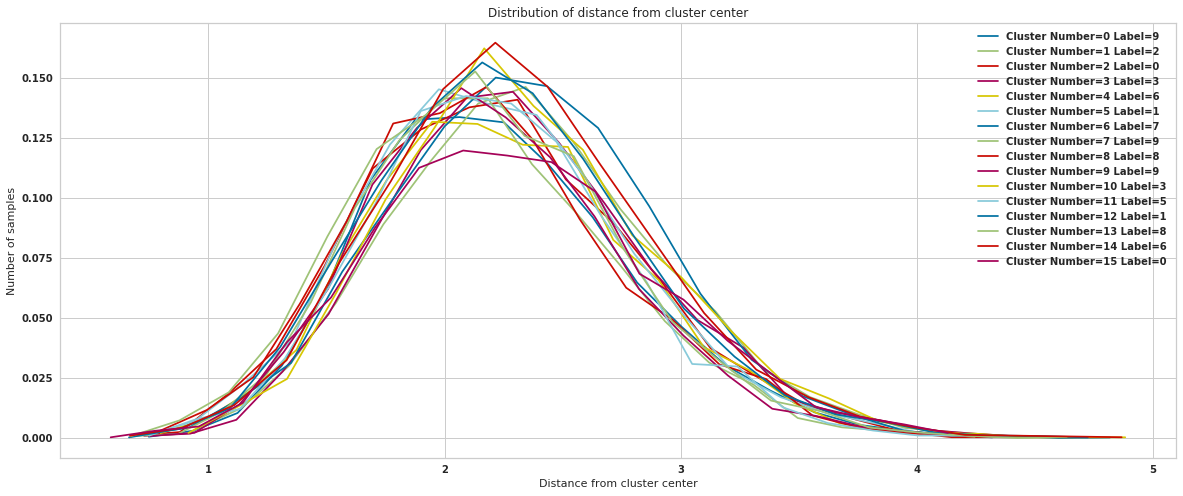

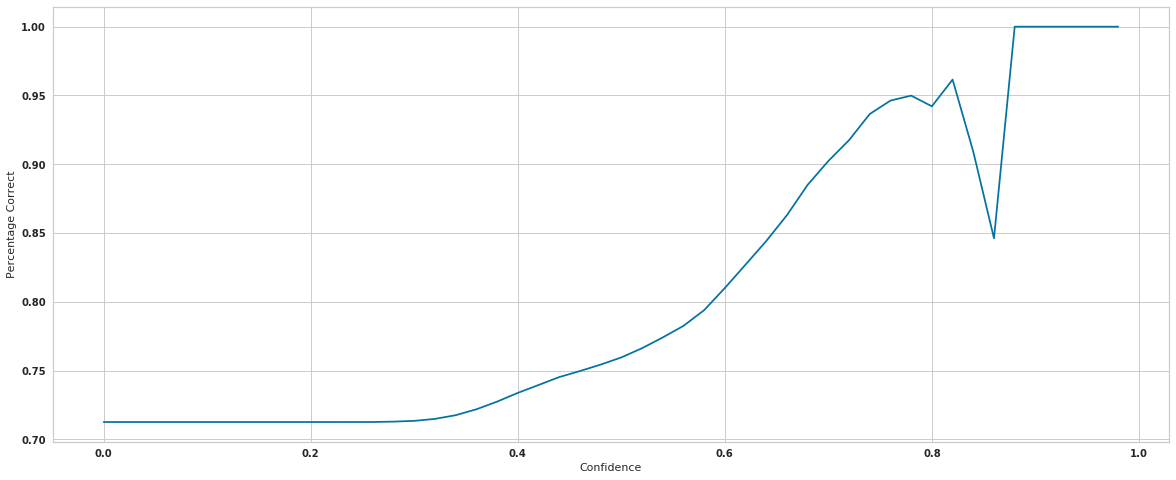

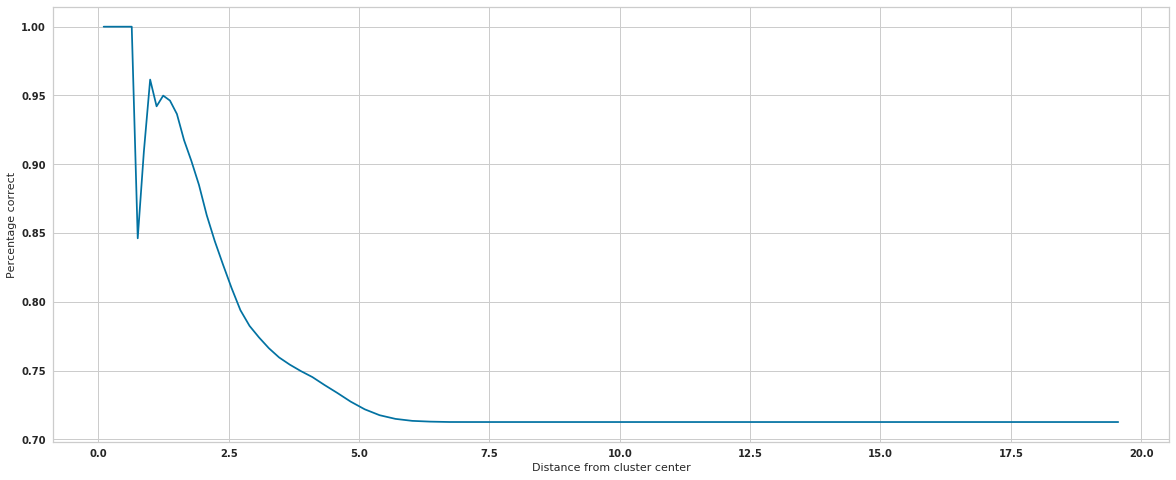

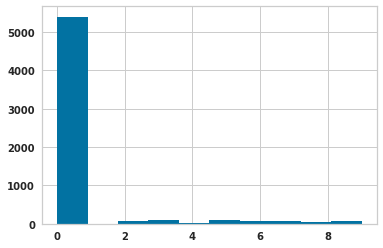

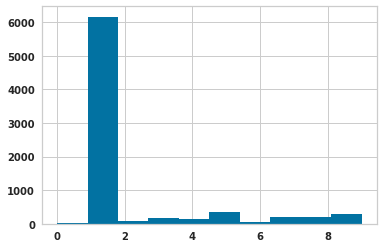

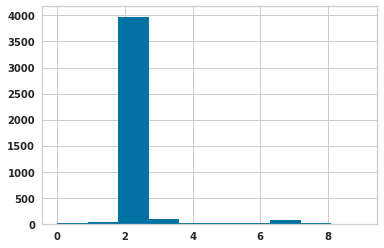

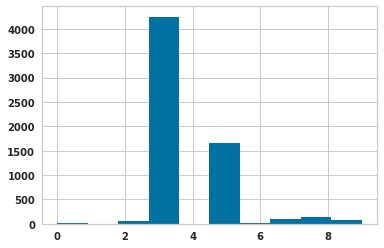

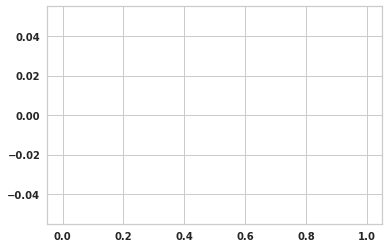

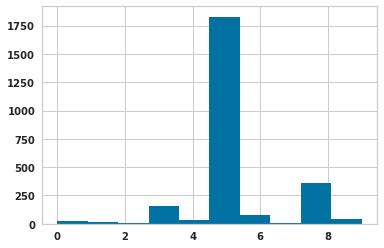

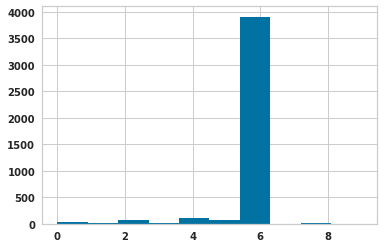

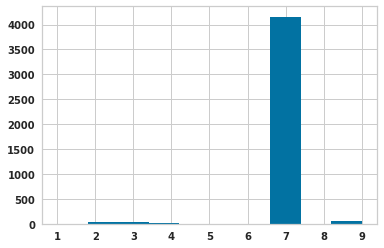

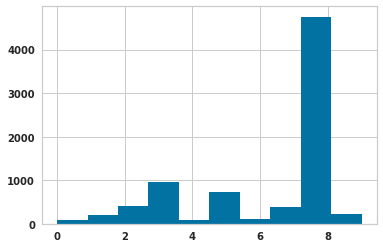

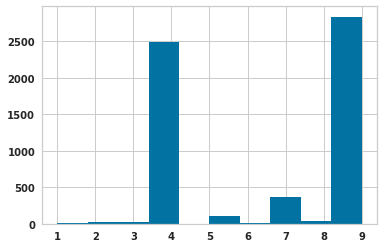

In [133]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [134]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 59840
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Running evaluation after epoch:08 and step:0300 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:8 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_08_0300/
(64, 28, 28, 1)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:08 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:8 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_08_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:08 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:8 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_08_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-8415
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-8415
 [*] Success to read ClassifierModel.model-8415
 [*] Load SUCCESS
Number of steps completed=8415
Number of epochs completed 9.0
run_id=2 z_min=-4.340634 z_max=4.580414
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.


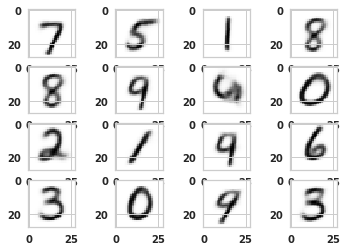

In [135]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


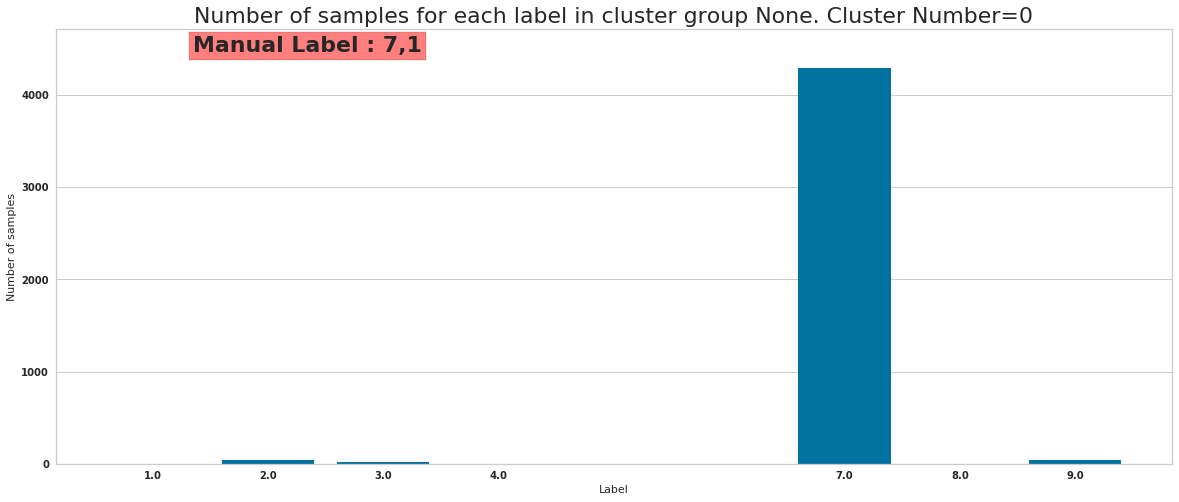

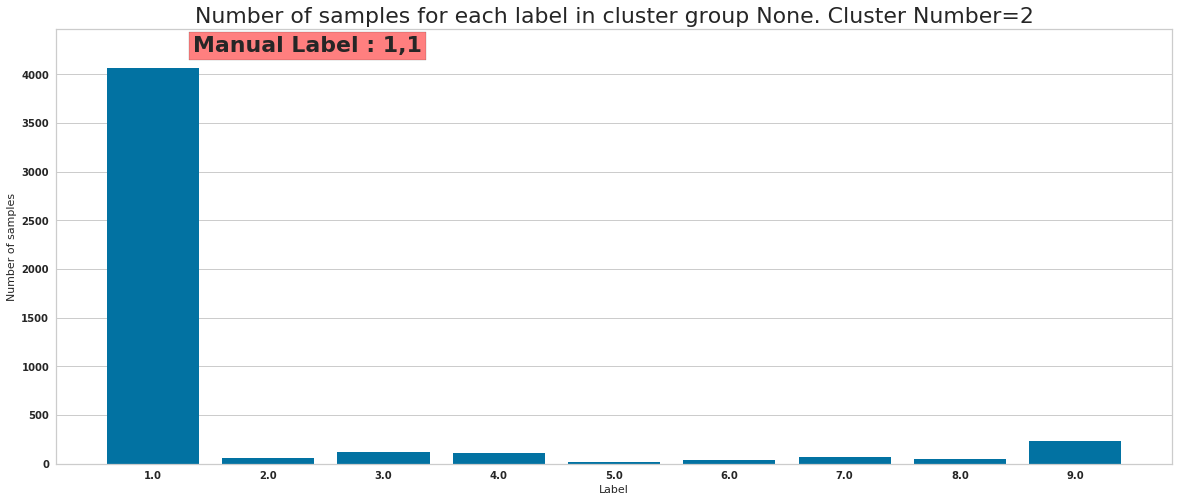

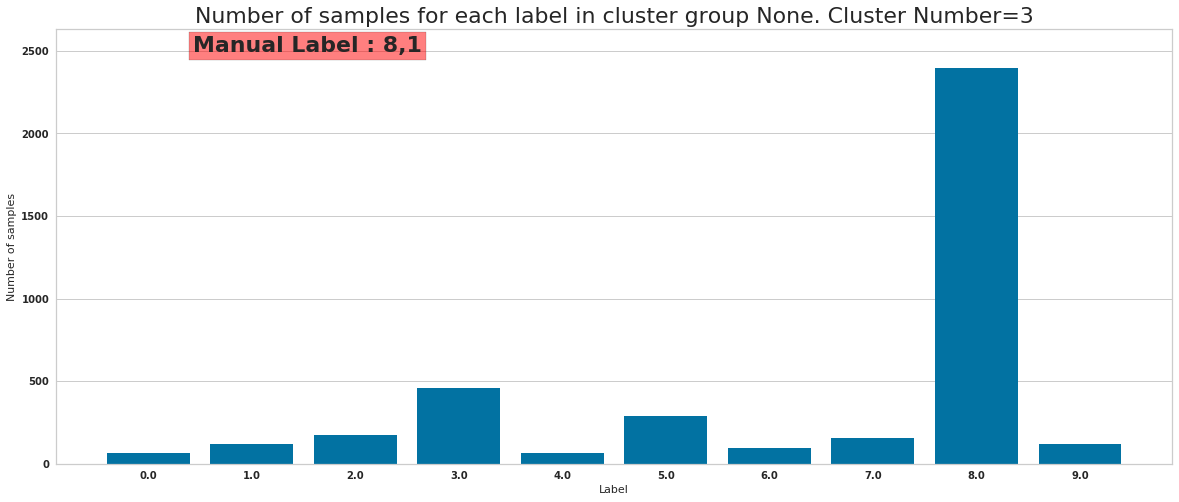

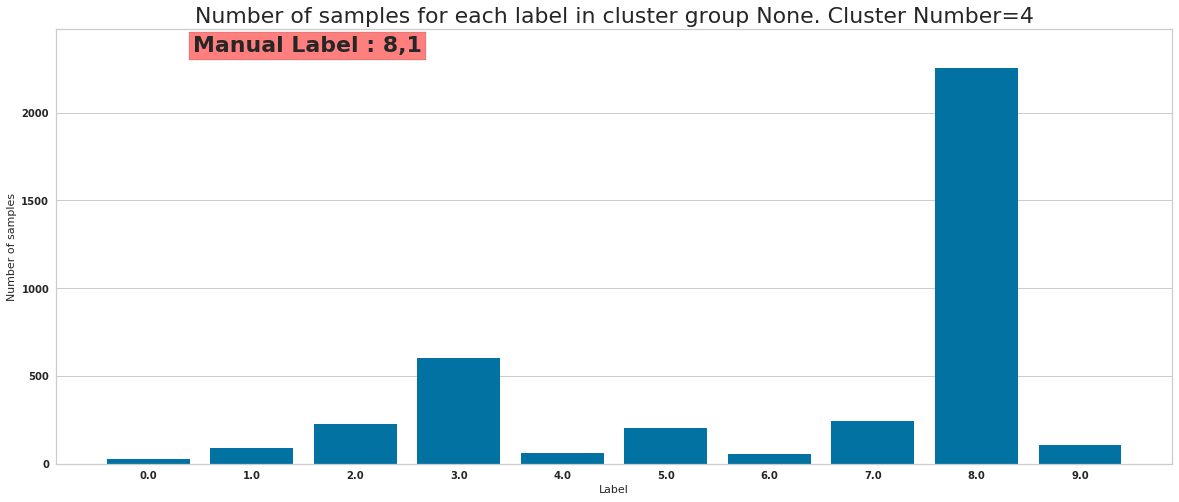

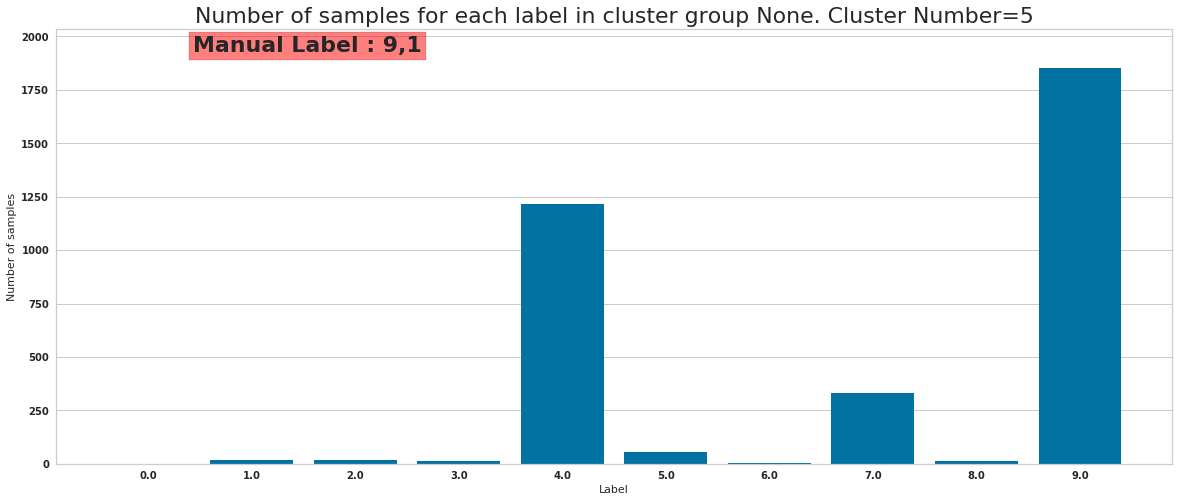

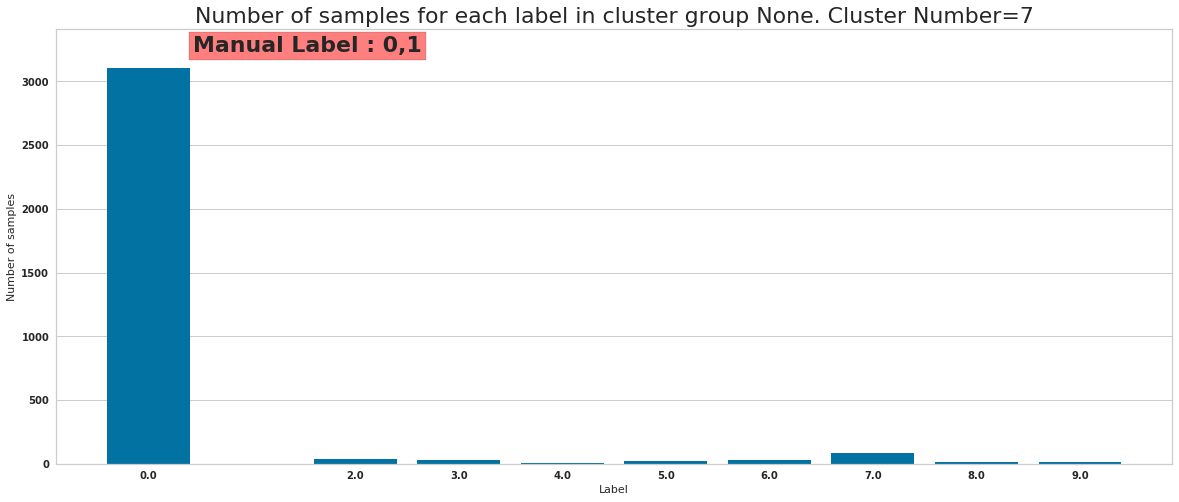

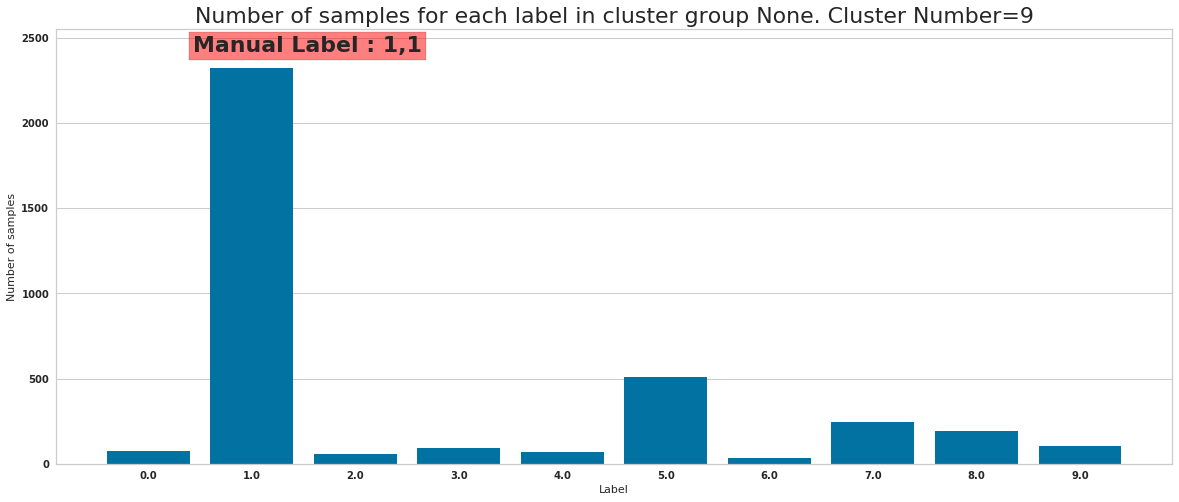

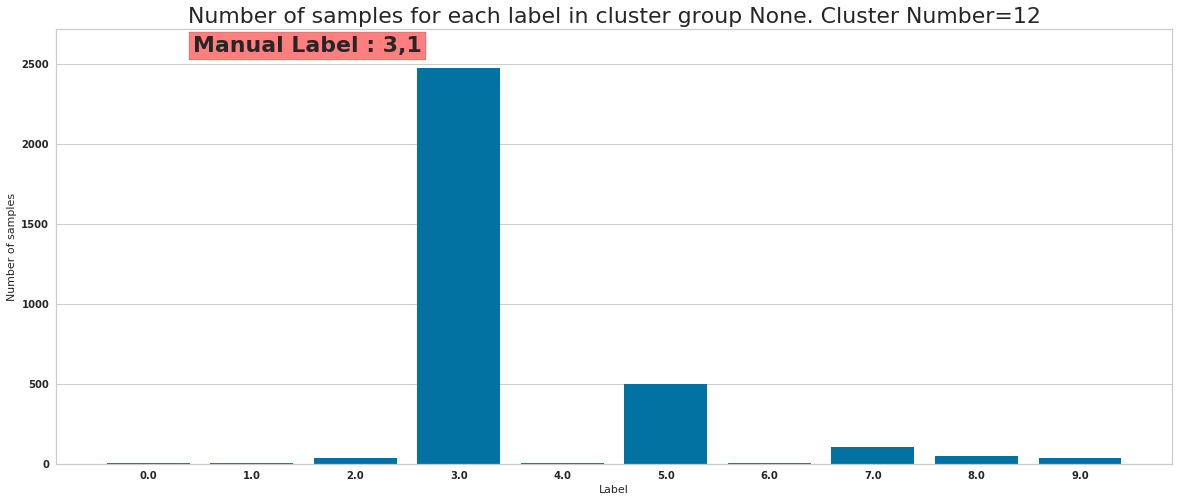

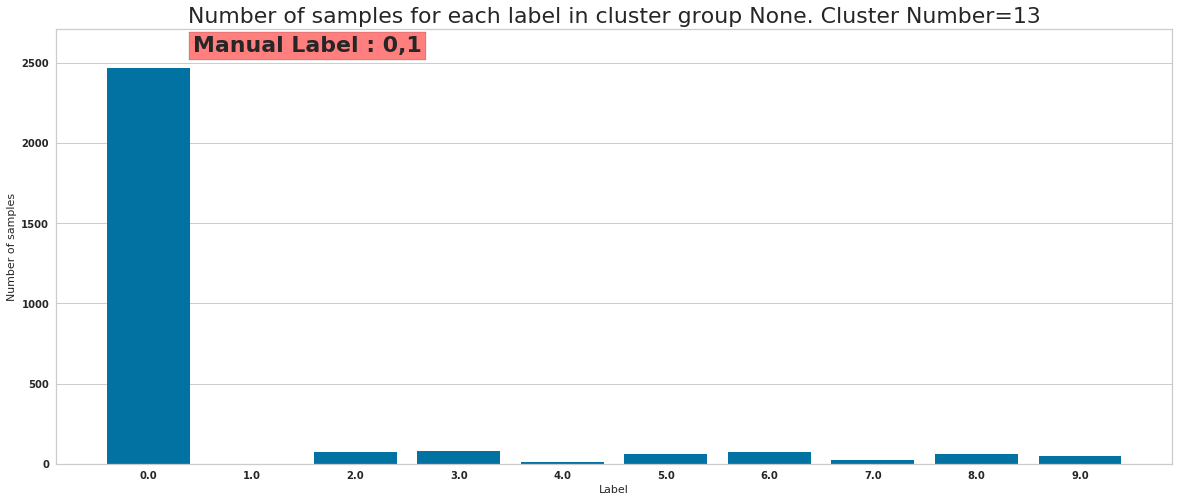

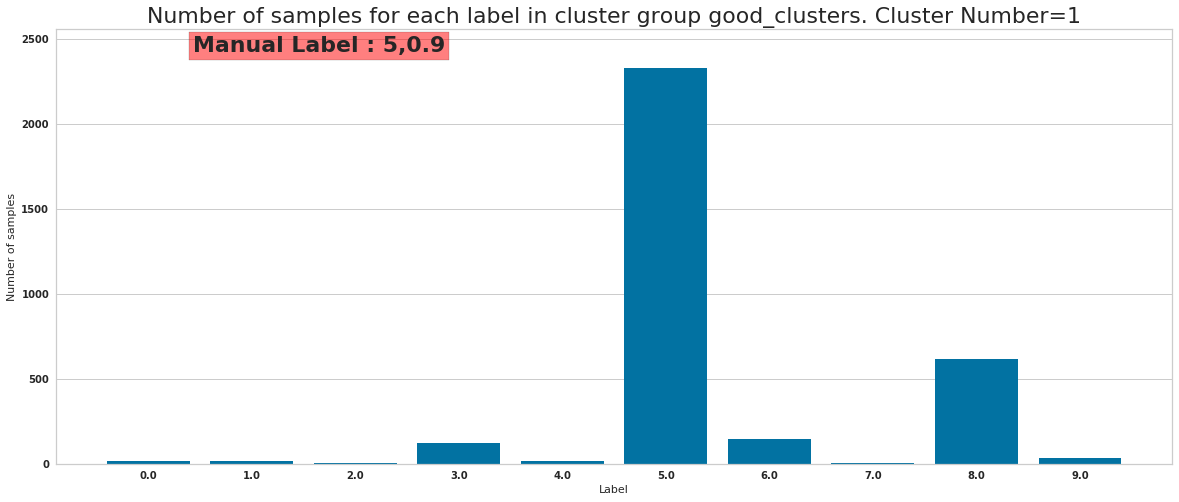

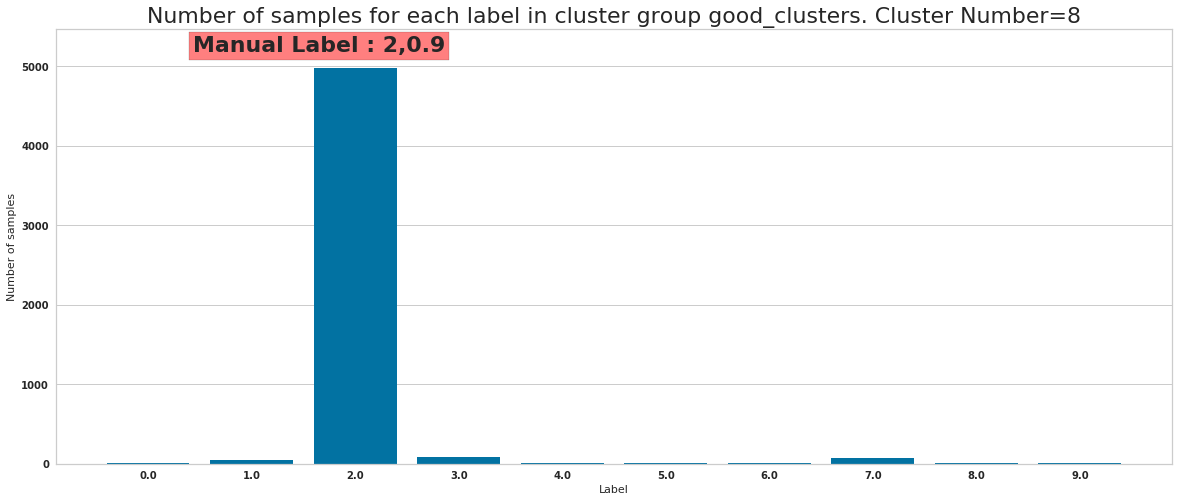

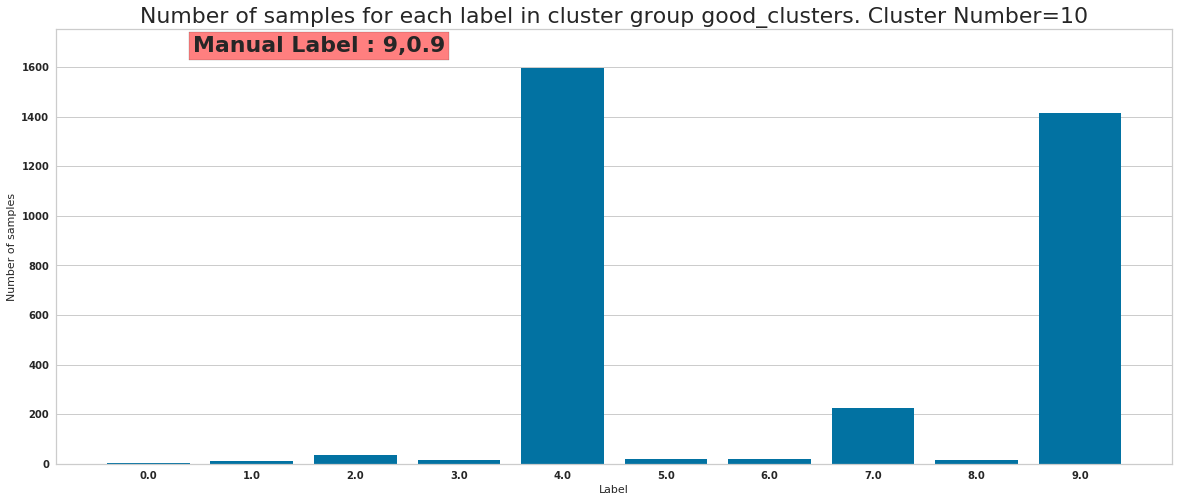

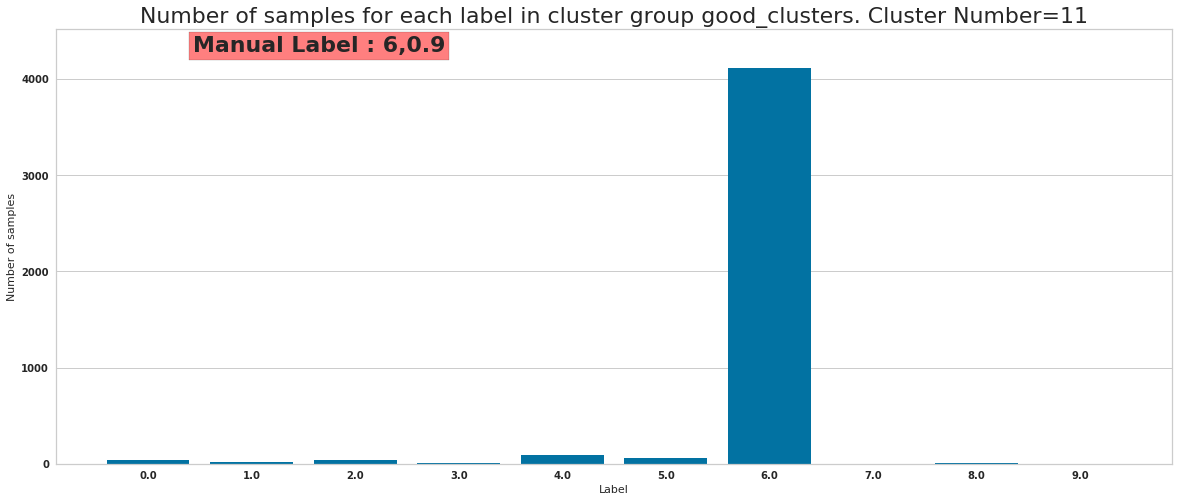

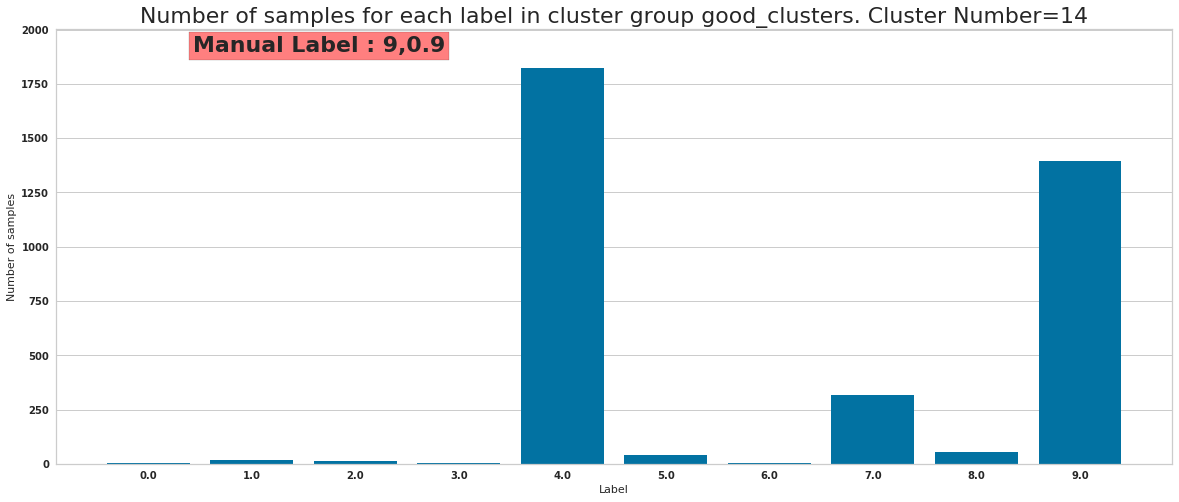

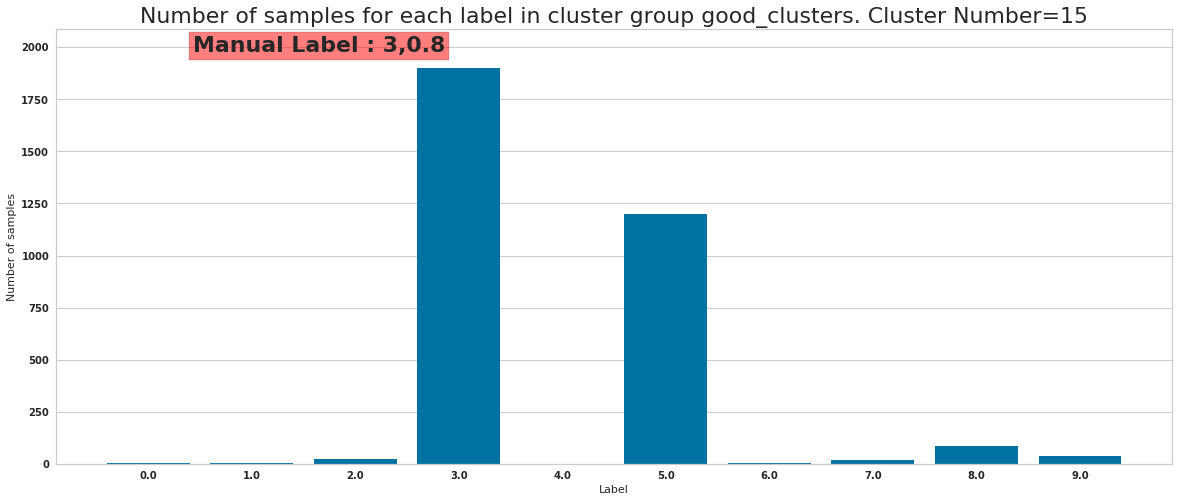

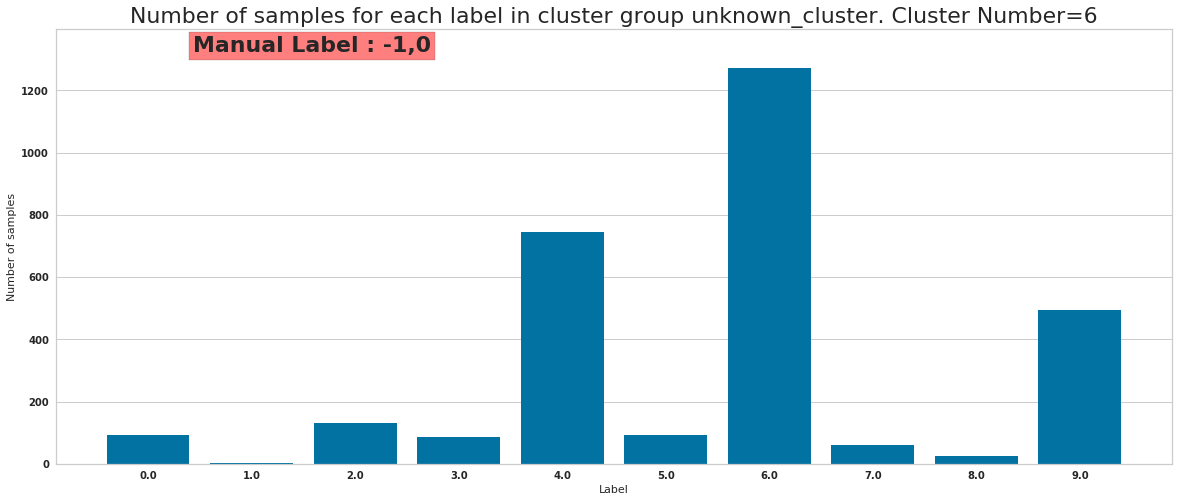

In [136]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7,5,1,8,
                                           8,9,-1,0,
                                           2,1,9,6,
                                           3,0,9,3
                                          ]
manual_annotation_json["manual_confidence"] = [1,0.9,1,1,
                                               1,1,0,1,
                                               0.9,1,0.9,0.9,
                                               1,1,0.9,0.8
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


6
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-8415
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-8415
 [*] Success to read ClassifierModel.model-8415
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


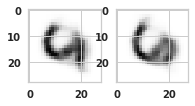

In [137]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


In [138]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1,-1]
level_2_cluster_dict["manual_confidences"] = [0,0]
level2_manual_annotations[6] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [139]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


6
2
Skipping distance computation for unknown cluster
Manual Label 7
(4396, 54) (4396, 32)
Num correct=4285
Cluster 0 Manual Label 7 Percentage correct 97.47497725204731
********************************
Manual Label 5
(3305, 54) (3305, 32)
Num correct=2327
Cluster 1 Manual Label 5 Percentage correct 70.40847201210288
********************************
Manual Label 1
(4762, 54) (4762, 32)
Num correct=4061
Cluster 2 Manual Label 1 Percentage correct 85.27929441411172
********************************
Manual Label 8
(3938, 54) (3938, 32)
Num correct=2393
Cluster 3 Manual Label 8 Percentage correct 60.76688674454038
********************************
Manual Label 8
(7812, 54) (3874, 32)
Num correct=4645
Cluster 4 Manual Label 8 Percentage correct 59.459805427547366
********************************
Manual Label 9
(3523, 54) (3523, 32)
Num correct=1850
Cluster 5 Manual Label 9 Percentage correct 52.512063582174285
********************************
unknown
<class 'dict'>
['unknown_cluster']
*******

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

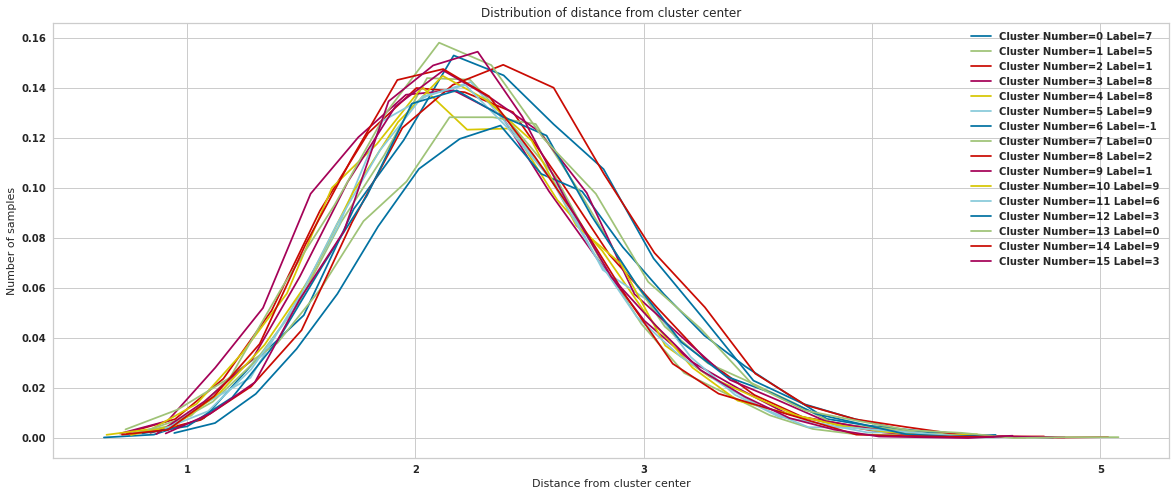

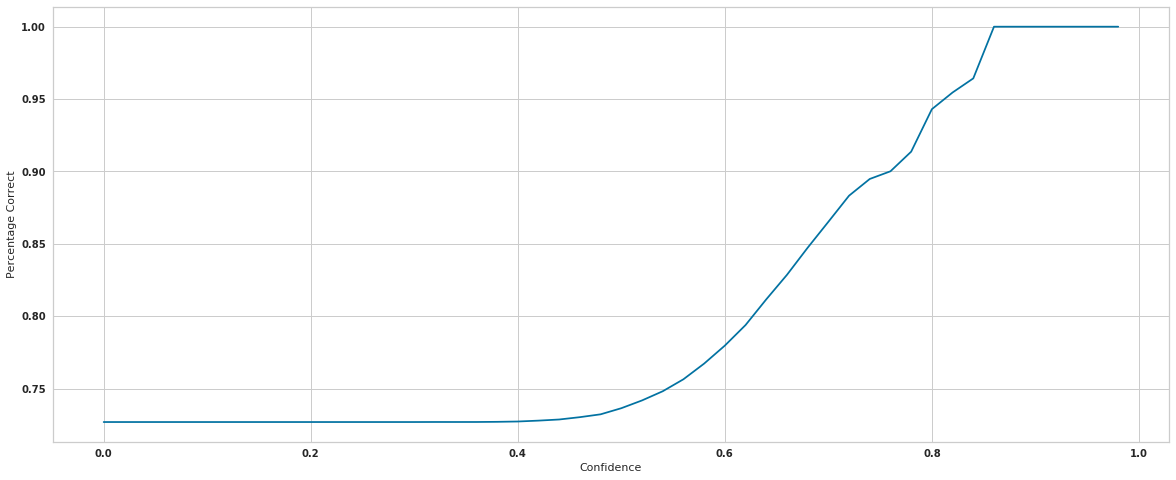

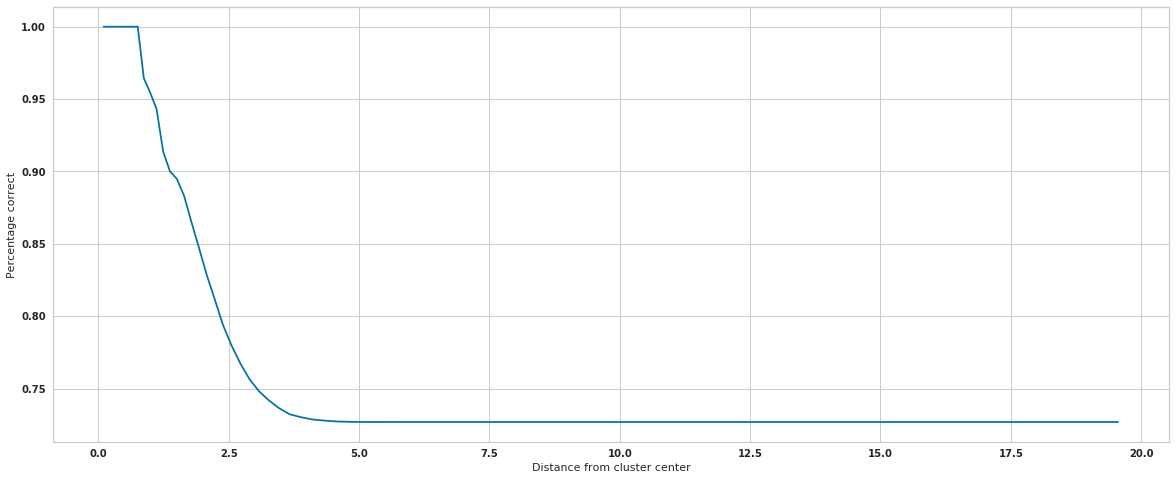

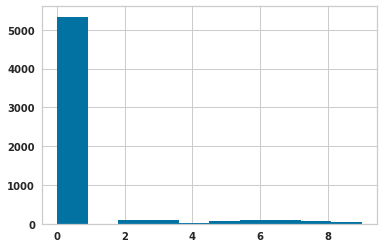

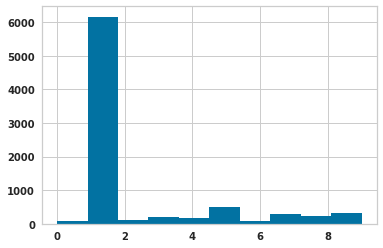

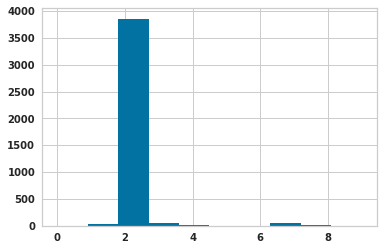

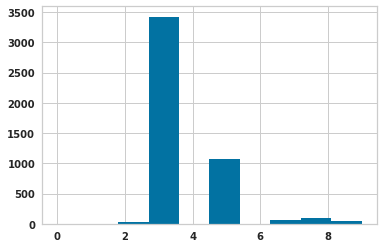

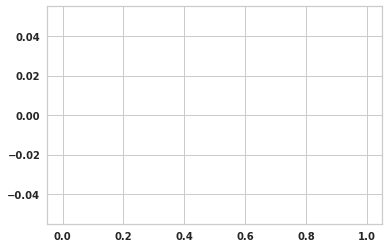

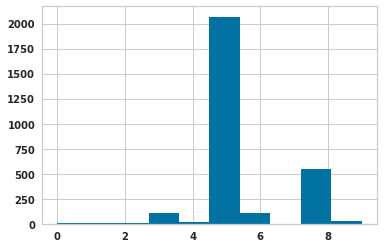

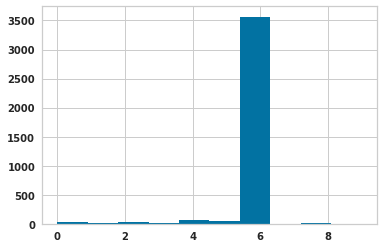

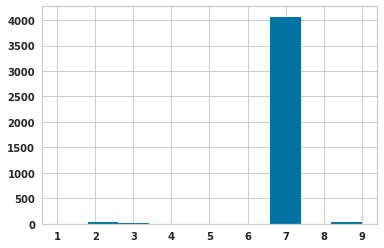

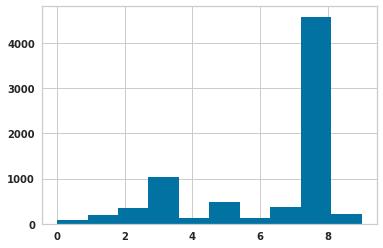

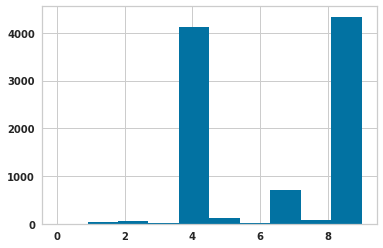

In [140]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [142]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 56841
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:9 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_09_0300/
(64, 28, 28, 1)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:09 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:9 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_09_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:09 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:9 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_09_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [141]:
num_epochs

9